# Final Notebook

In [2]:
import random, numpy as np, torch

SEED = 42

# Python
random.seed(SEED)

# NumPy
np.random.seed(SEED)

# Torch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [3]:
import wandb
import os

# Set your API key here
os.environ["WANDB_API_KEY"] = "4cac7a348a78f711d2890b70c3252efbe9c16fe5"

wandb.init(
    project="AnomalyDetectionInSDNs",
    name="experiment_run",
    reinit=True
)


wandb: Currently logged in as: derelioglugokdeniz (derelioglugokdeniz-bilkent-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


# Hopefully the FINAL notebook I'll need

In [4]:
import pandas as pd
import glob
import os
import numpy as np

In [5]:
def merge_csv_files(folder_path, output_file="merged.csv"):
    csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    dfs = []
    for file in csv_files:
        df = pd.read_csv(file)
        df.columns = [col.strip() for col in df.columns]
        dfs.append(df)
    merged_df = pd.concat(dfs, ignore_index=True)
    merged_df.to_csv(output_file, index=False)

# Use correct relative path for CICIDS2017 folder
merge_csv_files("../CICIDS2017", "merged.csv")

need to get this part to only include the top 50 features:

In [5]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

# ----------------------------
# SETTINGS
# ----------------------------
file_path = "merged.csv"
fraction = 0.85     # % of data to sample overall (keeps earliest fraction, preserves timeline)
seq_length = 10     # default LSTM sequence length (adjust as needed)

# ----------------------------
# 1) Load in chunks (preserve order)
# ----------------------------
chunks = []
chunk_size = 10_000
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    # Strip whitespace from column names
    chunk.columns = chunk.columns.str.strip()

    # Downcast numerics
    for col in chunk.select_dtypes(include=['int', 'float']).columns:
        if pd.api.types.is_integer_dtype(chunk[col]):
            chunk[col] = pd.to_numeric(chunk[col], downcast='integer')
        else:
            chunk[col] = pd.to_numeric(chunk[col], downcast='float')

    # Replace NaN/Inf inside chunk
    chunk = chunk.replace([np.inf, -np.inf], np.nan).fillna(0)

    chunks.append(chunk)

data = pd.concat(chunks, ignore_index=True)
del chunks  # free memory

# ----------------------------
# 2) Label to binary
# ----------------------------
if "Label" not in data.columns:
    raise KeyError("Expected a 'Label' column.")

data["Label"] = data["Label"].apply(
    lambda x: 0 if str(x).strip().upper() == "BENIGN" else 1
).astype(np.int32)

# ----------------------------
# 3) Optional overall fraction (preserves order)
# ----------------------------
if fraction < 1.0:
    n_sample = max(1, int(len(data) * fraction))
    data = data.iloc[:n_sample].copy()

# ----------------------------
# 4) Time-aware benign downsampling (keeps chronology)
# ----------------------------
def time_aware_downsample_benign(df, label_col="Label", max_benign_ratio=0.55):
    keep_mask = np.zeros(len(df), dtype=bool)
    benign_kept = 0
    attack_kept = 0

    label = df[label_col].to_numpy()

    for i in range(len(df)):
        if label[i] == 1:
            keep_mask[i] = True
            attack_kept += 1
        else:
            proposed_benign = benign_kept + 1
            proposed_total  = proposed_benign + attack_kept
            if proposed_total == 0:
                keep_mask[i] = True
                benign_kept += 1
            else:
                if (proposed_benign / proposed_total) <= max_benign_ratio:
                    keep_mask[i] = True
                    benign_kept += 1

    kept = df.loc[keep_mask]
    return kept

def time_aware_stratified_downsample(df, label_col="Label", max_benign_ratio=0.55, 
                                   time_window_size=1000):
    """
    Downsample benign samples while maintaining both chronology AND 
    better class balance across time windows.
    """
    keep_mask = np.zeros(len(df), dtype=bool)
    label = df[label_col].to_numpy()
    
    # Process in time windows to ensure stratification across time
    for window_start in range(0, len(df), time_window_size):
        window_end = min(window_start + time_window_size, len(df))
        window_labels = label[window_start:window_end]
        
        # Count attacks in this window
        attack_count = np.sum(window_labels == 1)
        benign_count = np.sum(window_labels == 0)
        
        # Calculate how many benign samples to keep in this window
        if attack_count == 0:
            # If no attacks, keep some benign samples
            benign_to_keep = min(benign_count, int(time_window_size * (1 - max_benign_ratio)))
        else:
            # Calculate based on desired ratio
            total_attacks_kept = attack_count
            max_benign_to_keep = int(total_attacks_kept * max_benign_ratio / (1 - max_benign_ratio))
            benign_to_keep = min(benign_count, max_benign_to_keep)
        
        # Keep all attacks in this window
        attack_indices = np.where(window_labels == 1)[0] + window_start
        keep_mask[attack_indices] = True
        
        # Keep chronologically first benign samples in this window
        benign_indices = np.where(window_labels == 0)[0] + window_start
        if len(benign_indices) > 0 and benign_to_keep > 0:
            keep_benign = benign_indices[:benign_to_keep]  # Keep first ones chronologically
            keep_mask[keep_benign] = True
    
    return df.loc[keep_mask].reset_index(drop=True)

# Apply chronology-safe downsampling
data = time_aware_stratified_downsample(data, label_col="Label", max_benign_ratio=0.55)

# ----------------------------
# 5) Cap extreme values (exclude the label)
# ----------------------------
numeric_cols = [c for c in data.select_dtypes(include=[np.number]).columns if c != "Label"]
for col in numeric_cols:
    cap_value = data[col].quantile(0.999)
    data[col] = np.clip(data[col], a_min=None, a_max=cap_value)

# ----------------------------
# 6) Feature selection: keep only TOP 50 features
# ----------------------------
X = data.drop(columns=["Label"])
y = data["Label"]

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(50).index.tolist()

print("\nTop 50 selected features:")
print(top_features)

data = data[top_features + ["Label"]]

# ----------------------------
# 7) Dtypes for ML (features float32, label int32)
# ----------------------------
for col in top_features:
    data[col] = data[col].astype(np.float32)
data["Label"] = data["Label"].astype(np.int32)

# ----------------------------
# Save final reduced dataset
# ----------------------------
data.to_csv("new_merged.csv", index=False)

# ----------------------------
# Final assignment for downstream code
# ----------------------------
datadf = data.copy()
ftnames = [c.strip() for c in datadf.columns if c.strip() != "Label"]

print(f"\nFinal shape: {datadf.shape}")
print(f"Number of features: {len(ftnames)}")
print("First few feature names:", ftnames[:10])
print("Label distribution:\n", datadf['Label'].value_counts())

# ======================================================================
# Chronology-safe sequence utilities (NO shuffling, NO stratify anywhere)
# ======================================================================

def create_sequences(X, y, sequence_length=10, label_strategy='last'):
    """
    Create overlapping sequences without breaking chronology.
    label_strategy: 'last' | 'majority' | 'any_attack'
    """
    if len(X) < sequence_length:
        sequence_length = len(X)
        print(f"[create_sequences] Adjusted sequence_length to {sequence_length}")

    X_sequences, y_sequences = [], []
    for i in range(len(X) - sequence_length + 1):
        X_seq = X[i:i+sequence_length]
        y_seq = y[i:i+sequence_length]
        X_sequences.append(X_seq)

        if label_strategy == 'last':
            y_sequences.append(y_seq[-1])
        elif label_strategy == 'majority':
            y_sequences.append(1 if np.sum(y_seq) > (len(y_seq) // 2) else 0)
        elif label_strategy == 'any_attack':
            y_sequences.append(1 if (y_seq == 1).any() else 0)
        else:
            raise ValueError(f"Unknown label_strategy: {label_strategy}")

    X_sequences = np.asarray(X_sequences, dtype=np.float32)
    y_sequences = np.asarray(y_sequences, dtype=np.float32)

    return X_sequences, y_sequences

def chrono_split_train_val_test(df, label_col="Label", train_ratio=0.7, val_ratio=0.15):
    """
    Chronological split on rows (NO shuffle). Test gets the tail.
    """
    n = len(df)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    n_test = n - n_train - n_val

    train_df = df.iloc[:n_train]
    val_df   = df.iloc[n_train:n_train+n_val]
    test_df  = df.iloc[n_train+n_val:]

    def xy(d):
        X = d.drop(columns=[label_col]).to_numpy(dtype=np.float32)
        y = d[label_col].to_numpy(dtype=np.int32)
        return X, y

    return xy(train_df), xy(val_df), xy(test_df)

def build_chrono_sequences(df, label_col="Label", sequence_length=10, label_strategy='last'):
    """
    Split chronologically on raw rows, then build sequences inside each split so
    no sequence crosses split boundaries.
    """
    (X_tr, y_tr), (X_va, y_va), (X_te, y_te) = chrono_split_train_val_test(df, label_col=label_col)

    X_train_seq, y_train_seq = create_sequences(X_tr, y_tr, sequence_length, label_strategy)
    X_val_seq,   y_val_seq   = create_sequences(X_va, y_va, sequence_length, label_strategy)
    X_test_seq,  y_test_seq  = create_sequences(X_te, y_te, sequence_length, label_strategy)

    # Quick sanity print
    def _dist(y):
        c = Counter(y.astype(int).tolist())
        total = len(y)
        if total == 0:
            return {}
        return {k: f"{v} ({v/total:.2%})" for k, v in sorted(c.items())}

    print("\n=== Chronological split (sequence-level) ===")
    print(f"Train seq: {X_train_seq.shape}, dist: { _dist(y_train_seq) }")
    print(f"Val   seq: {X_val_seq.shape}, dist: { _dist(y_val_seq) }")
    print(f"Test  seq: {X_test_seq.shape}, dist: { _dist(y_test_seq) }")

    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq

from sklearn.model_selection import TimeSeriesSplit

def build_chrono_kfold_sequences(df, label_col="Label", sequence_length=10, 
                                label_strategy='last', n_splits=5):
    """
    K-fold cross-validation that maintains chronological order.
    Each fold uses progressively more past data for training.
    """
    # Convert to numpy arrays first
    X_full = df.drop(columns=[label_col]).to_numpy(dtype=np.float32)
    y_full = df[label_col].to_numpy(dtype=np.int32)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_data = []
    
    print(f"\n=== Chronological K-Fold ({n_splits} splits) ===")
    
    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X_full)):
        # Maintain chronological order (TimeSeriesSplit already does this)
        X_train_fold = X_full[train_idx]
        y_train_fold = y_full[train_idx]
        X_val_fold = X_full[val_idx]
        y_val_fold = y_full[val_idx]
        
        # Create sequences within each fold (no cross-contamination)
        X_train_seq, y_train_seq = create_sequences(X_train_fold, y_train_fold, 
                                                   sequence_length, label_strategy)
        X_val_seq, y_val_seq = create_sequences(X_val_fold, y_val_fold, 
                                               sequence_length, label_strategy)
        
        # Distribution info
        def _dist(y):
            c = Counter(y.astype(int).tolist())
            total = len(y)
            if total == 0:
                return {}
            return {k: f"{v} ({v/total:.2%})" for k, v in sorted(c.items())}
        
        print(f"Fold {fold_idx+1}: Train={X_train_seq.shape}, Val={X_val_seq.shape}")
        print(f"  Train dist: {_dist(y_train_seq)}")
        print(f"  Val dist: {_dist(y_val_seq)}")
        
        fold_data.append({
            'fold': fold_idx,
            'X_train': X_train_seq,
            'y_train': y_train_seq,
            'X_val': X_val_seq,
            'y_val': y_val_seq
        })
    
    return fold_data


Top 50 selected features:
['Destination Port', 'Init_Win_bytes_forward', 'Max Packet Length', 'Average Packet Size', 'Bwd Packet Length Max', 'Init_Win_bytes_backward', 'Min Packet Length', 'Bwd Packet Length Min', 'Packet Length Std', 'Subflow Fwd Bytes', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Total Length of Fwd Packets', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Packet Length Mean', 'Packet Length Variance', 'Fwd Packet Length Mean', 'Fwd Header Length.1', 'Fwd Header Length', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Subflow Bwd Bytes', 'Bwd Header Length', 'act_data_pkt_fwd', 'Fwd IAT Min', 'Total Fwd Packets', 'Bwd Packets/s', 'min_seg_size_forward', 'Subflow Fwd Packets', 'Fwd IAT Std', 'URG Flag Count', 'ACK Flag Count', 'Flow IAT Max', 'Flow Bytes/s', 'Subflow Bwd Packets', 'Fwd IAT Max', 'Bwd IAT Total', 'Total Backward Packets', 'Flow Packets/s', 'Bwd IAT Max', 'Flow IAT Mean', 'PSH Flag Count', 'Flow IAT Std', 'Fw

chunking -> dataset large, loading it all at once is not possible with our hardware
preserving order -> this dataset is time-sensitive so we need to maintain the order
labels -> string to int
fractioning was something done to try out with less data at first (found out how much it can change later on in the project)
downsampling -> too many benign samples
RF used to determine most important 50 features

"chrono-sequences" -> LSTM looks at past sequences. sequences must be split in order
K-Fold -> splits data randomly into chunks but we needed chronological sequences. So we did that.

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    classification_report, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
import optuna
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [7]:
def print_data_info(X, y, stage_name):
    """Print comprehensive data information"""
    print(f"\n=== {stage_name} Data Info ===")
    print(f"Feature matrix shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Feature data type: {X.dtype}")
    print(f"Label data type: {y.dtype}")
    
    # Check for NaN/inf values
    nan_count = np.isnan(X).sum()
    inf_count = np.isinf(X).sum()
    print(f"NaN values in features: {nan_count}")
    print(f"Inf values in features: {inf_count}")
    
    # Basic statistics
    print(f"Feature matrix - Min: {X.min():.4f}, Max: {X.max():.4f}, Mean: {X.mean():.4f}")
    
    # Label distribution
    unique_labels, counts = np.unique(y, return_counts=True)
    print(f"Label distribution:")
    for label, count in zip(unique_labels, counts):
        percentage = (count / len(y)) * 100
        print(f"  Class {int(label)}: {count} samples ({percentage:.2f}%)")
    
    # Sample some labels
    print(f"First 20 labels: {y[:20]}")
    print(f"Last 20 labels: {y[-20:]}")

def validate_data_splits(X_train, y_train, X_val, y_val, X_test, y_test):
    """Validate that data splits preserve class distribution"""
    print("\n=== Data Split Validation ===")
    
    # Check shapes
    print(f"Original total samples: {len(X_train) + len(X_val) + len(X_test)}")
    print(f"Train: {X_train.shape[0]} ({X_train.shape[0]/(len(X_train) + len(X_val) + len(X_test))*100:.1f}%)")
    print(f"Val: {X_val.shape[0]} ({X_val.shape[0]/(len(X_train) + len(X_val) + len(X_test))*100:.1f}%)")
    print(f"Test: {X_test.shape[0]} ({X_test.shape[0]/(len(X_train) + len(X_val) + len(X_test))*100:.1f}%)")
    
    # Check class distributions
    datasets = [("Train", y_train), ("Val", y_val), ("Test", y_test)]
    
    print("\nClass distributions across splits:")
    for name, y_split in datasets:
        unique_labels, counts = np.unique(y_split, return_counts=True)
        print(f"{name}:")
        for label, count in zip(unique_labels, counts):
            percentage = (count / len(y_split)) * 100
            print(f"  Class {int(label)}: {count} samples ({percentage:.2f}%)")
    
    # Check for data leakage indicators
    print(f"\nFeature statistics consistency check:")
    print(f"Train mean: {X_train.mean():.6f}")
    print(f"Val mean: {X_val.mean():.6f}")
    print(f"Test mean: {X_test.mean():.6f}")

def check_preprocessing_integrity(X_before, y_before, X_after, y_after, stage_name):
    """Check if preprocessing preserved data integrity"""
    print(f"\n=== {stage_name} Preprocessing Integrity Check ===")
    
    # Shape consistency
    assert X_before.shape[0] == X_after.shape[0], f"Sample count mismatch: {X_before.shape[0]} vs {X_after.shape[0]}"
    assert len(y_before) == len(y_after), f"Label count mismatch: {len(y_before)} vs {len(y_after)}"
    print("✓ Sample counts preserved")
    
    # Label consistency
    assert np.array_equal(y_before, y_after), "Labels were modified during preprocessing!"
    print("✓ Labels preserved")
    
    # Feature scaling check
    if stage_name == "Scaling":
        print(f"Before scaling - Min: {X_before.min():.4f}, Max: {X_before.max():.4f}")
        print(f"After scaling - Min: {X_after.min():.4f}, Max: {X_after.max():.4f}")
        print(f"After scaling - Mean: {X_after.mean():.6f}, Std: {X_after.std():.6f}")


In [8]:
class BaselineEvaluator:
    def __init__(self):
        self.models = {}
        self.results = {}
    
    def add_dummy_classifier(self, X_train, y_train):
        """Add majority class predictor"""
        print("Adding Majority Class Predictor...")
        self.models['majority_class'] = DummyClassifier(strategy='most_frequent', random_state=42)
        self.models['majority_class'].fit(X_train, y_train)
    
    def add_logistic_regression(self, X_train, y_train):
        """Add logistic regression baseline"""
        print("Adding Logistic Regression...")
        self.models['logistic_regression'] = LogisticRegression(
            random_state=42, 
            max_iter=1000,
            class_weight='balanced'
        )
        self.models['logistic_regression'].fit(X_train, y_train)
    
    def add_random_forest(self, X_train, y_train):
        """Add random forest baseline"""
        print("Adding Random Forest...")
        self.models['random_forest'] = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        )
        self.models['random_forest'].fit(X_train, y_train)
    
    def add_knn(self, X_train, y_train):
        """Add KNN baseline"""
        print("Adding KNN...")
        # Use smaller sample for KNN if dataset is too large
        if len(X_train) > 10000:
            print(f"Using subset of {min(5000, len(X_train))} samples for KNN training...")
            indices = np.random.choice(len(X_train), min(5000, len(X_train)), replace=False)
            X_train_knn = X_train[indices]
            y_train_knn = y_train[indices]
        else:
            X_train_knn = X_train
            y_train_knn = y_train
            
        self.models['knn'] = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
        self.models['knn'].fit(X_train_knn, y_train_knn)
    
    def evaluate_all(self, X_test, y_test, model_name_prefix="Baseline"):
        """Evaluate all baseline models"""
        print(f"\n=== {model_name_prefix} Model Evaluation ===")
        
        for name, model in self.models.items():
            print(f"\nEvaluating {name.replace('_', ' ').title()}...")
            
            # Predictions
            try:
                y_pred = model.predict(X_test)
                y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred
            except Exception as e:
                print(f"Error with {name}: {e}")
                continue
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            
            # AUC calculation
            try:
                if len(np.unique(y_test)) > 1:
                    auc = roc_auc_score(y_test, y_prob)
                    pr_auc = average_precision_score(y_test, y_prob)
                else:
                    auc = pr_auc = 0.5
            except:
                auc = pr_auc = 0.5
            
            # Store results
            self.results[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'auc': auc,
                'pr_auc': pr_auc,
                'y_pred': y_pred,
                'y_prob': y_prob
            }
            
            # Print results
            print(f"  Accuracy:  {accuracy:.4f}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall:    {recall:.4f}")
            print(f"  F1 Score:  {f1:.4f}")
            print(f"  AUC:       {auc:.4f}")
            print(f"  PR-AUC:    {pr_auc:.4f}")
    
    def plot_confusion_matrices(self, y_test):
        """Plot confusion matrices for all models with robust error handling"""
        n_models = len(self.results)  # Use results, not models
        if n_models == 0:
            print("No model results available for confusion matrix plotting")
            return
        
        print(f"Plotting confusion matrices for {n_models} models...")
        
        # Try the subplot approach first
        try:
            cols = min(3, n_models)
            rows = (n_models + cols - 1) // cols
            
            fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
            
            # Convert to 2D array for consistent indexing
            if n_models == 1:
                axes = np.array([[axes]])
            elif rows == 1:
                axes = axes.reshape(1, -1)
            elif cols == 1:
                axes = axes.reshape(-1, 1)
            
            plot_idx = 0
            for name, results in self.results.items():
                try:
                    row = plot_idx // cols
                    col = plot_idx % cols
                    
                    ax = axes[row, col]
                    
                    cm = confusion_matrix(y_test, results['y_pred'])
                    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
                    ax.set_title(f'{name.replace("_", " ").title()}\nF1: {results["f1"]:.3f}, AUC: {results["auc"]:.3f}')
                    ax.set_xlabel('Predicted')
                    ax.set_ylabel('Actual')
                    
                    plot_idx += 1
                    
                except Exception as e:
                    print(f"Error plotting confusion matrix for {name}: {e}")
                    plot_idx += 1
                    continue
            
            # Hide empty subplots
            for idx in range(n_models, rows * cols):
                try:
                    row = idx // cols
                    col = idx % cols
                    axes[row, col].axis('off')
                except:
                    continue
            
            plt.tight_layout()
            plt.show()
            print("✅ Confusion matrices plotted successfully")
            
        except Exception as e:
            print(f"Subplot approach failed: {e}")
            print("Falling back to individual plots...")
            
            # Fallback: individual plots
            try:
                for name, results in self.results.items():
                    try:
                        plt.figure(figsize=(6, 4))
                        cm = confusion_matrix(y_test, results['y_pred'])
                        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                        plt.title(f'{name.replace("_", " ").title()}\nF1: {results["f1"]:.3f}, AUC: {results["auc"]:.3f}')
                        plt.xlabel('Predicted')
                        plt.ylabel('Actual')
                        plt.tight_layout()
                        plt.show()
                        print(f"✅ Confusion matrix for {name} plotted")
                    except Exception as e2:
                        print(f"❌ Failed to plot confusion matrix for {name}: {e2}")
                        
            except Exception as e3:
                print(f"❌ All plotting approaches failed: {e3}")
                print("Skipping confusion matrix plots...")
    
    def get_results_summary(self):
        """Get summary of all baseline results"""
        if not self.results:
            print("No results available for summary")
            return pd.DataFrame()
            
        summary_data = []
        for name, results in self.results.items():
            summary_data.append({
                'Model': name.replace('_', ' ').title(),
                'Accuracy': results['accuracy'],
                'Precision': results['precision'],
                'Recall': results['recall'],
                'F1': results['f1'],
                'AUC': results['auc'],
                'PR-AUC': results['pr_auc']
            })
        
        return pd.DataFrame(summary_data).round(4)
    
    # Replace your plot_confusion_matrices method with this simple version
    def plot_confusion_matrices(self, y_test):
        """Plot confusion matrices for all models - Simple version"""
        if not self.results:
            print("No results available for plotting")
            return
        
        print(f"Plotting confusion matrices for {len(self.results)} models...")
        
        # Use simple individual plots to avoid matplotlib axes issues
        for name, results in self.results.items():
            try:
                print(f"Plotting confusion matrix for {name}...")
                
                # Create a new figure for each model
                plt.figure(figsize=(6, 5))
                
                # Calculate confusion matrix
                cm = confusion_matrix(y_test, results['y_pred'])
                
                # Use matplotlib directly instead of seaborn to avoid axes issues
                plt.imshow(cm, interpolation='nearest', cmap='Blues')
                plt.colorbar()
                
                # Add text annotations
                for i in range(cm.shape[0]):
                    for j in range(cm.shape[1]):
                        plt.text(j, i, str(cm[i, j]), 
                                ha='center', va='center', 
                                color='white' if cm[i, j] > cm.max() / 2 else 'black',
                                fontsize=14, fontweight='bold')
                
                # Labels and title
                plt.title(f'{name.replace("_", " ").title()}\nF1: {results["f1"]:.3f}, AUC: {results["auc"]:.3f}', 
                        fontsize=12, pad=20)
                plt.xlabel('Predicted Label', fontsize=11)
                plt.ylabel('True Label', fontsize=11)
                
                # Set tick labels
                tick_labels = ['Benign', 'Attack']
                plt.xticks(range(len(tick_labels)), tick_labels)
                plt.yticks(range(len(tick_labels)), tick_labels)
                
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"Error plotting confusion matrix for {name}: {e}")
                # Still try to show basic metrics
                try:
                    cm = confusion_matrix(y_test, results['y_pred'])
                    print(f"  Confusion Matrix for {name}:")
                    print(f"    {cm}")
                except:
                    print(f"  Could not generate any visualization for {name}")
        
        print("✅ Confusion matrix plotting completed")
    
    def get_results_summary(self):
        """Get summary of all baseline results"""
        if not self.results:
            return pd.DataFrame()
            
        summary_data = []
        for name, results in self.results.items():
            summary_data.append({
                'Model': name.replace('_', ' ').title(),
                'Accuracy': results['accuracy'],
                'Precision': results['precision'],
                'Recall': results['recall'],
                'F1': results['f1'],
                'AUC': results['auc'],
                'PR-AUC': results['pr_auc']
            })
        
        return pd.DataFrame(summary_data).round(4)

In [9]:
SEQ_LENGTH = 30

In [10]:
from collections import Counter
import numpy as np

# ==========================================================
# Chronology-safe prepare_lstm_sequences_fixed
# ==========================================================
def prepare_lstm_sequences_fixed(X, y, sequence_length=SEQ_LENGTH, label_strategy='majority'):
    """
    Convert tabular data to sequences for LSTM training with better label handling.
    Chronology preserved (NO shuffling).
    """
    print(f"Creating sequences of length {sequence_length} with {label_strategy} labeling...")

    if len(X) < sequence_length:
        sequence_length = len(X)
        print(f"Adjusted sequence length to {sequence_length} due to limited data")

    X_sequences = []
    y_sequences = []

    for i in range(len(X) - sequence_length + 1):
        X_seq = X[i:i + sequence_length]
        y_seq = y[i:i + sequence_length]
        X_sequences.append(X_seq)

        if label_strategy == 'last':
            y_sequences.append(y_seq[-1])
        elif label_strategy == 'majority':
            y_sequences.append(1 if np.sum(y_seq) > len(y_seq) // 2 else 0)
        elif label_strategy == 'any_attack':
            y_sequences.append(1 if np.any(y_seq == 1) else 0)

    X_sequences = np.array(X_sequences, dtype=np.float32)
    y_sequences = np.array(y_sequences, dtype=np.int32)

    print(f"Created {len(X_sequences)} sequences")
    print(f"Sequence shape: {X_sequences.shape}")

    # Distribution debug
    original_dist = Counter(y)
    sequence_dist = Counter(y_sequences)
    print(f"Original distribution: {dict(original_dist)}")
    print(f"Sequence distribution: {dict(sequence_dist)}")

    return X_sequences, y_sequences


# ==========================================================
# Chronology-safe create_stratified_sequences
# (renamed internally but kept external name)
# ==========================================================
def create_stratified_sequences(X, y, sequence_length=SEQ_LENGTH, test_size=0.4, val_split=0.5, random_state=42):
    """
    Chronology-safe split of sequences (replaces stratified split).
    """
    print("Creating chronology-safe sequences (no stratify)...")

    # Step 1: build sequences
    X_seq, y_seq = prepare_lstm_sequences_fixed(X, y, sequence_length, label_strategy='majority')

    # Step 2: split chronologically
    n_total = len(X_seq)
    n_test = int(n_total * test_size)
    n_val = int((n_total - n_test) * val_split)

    train_end = n_total - n_test - n_val
    val_end   = n_total - n_test

    X_train_seq, y_train_seq = X_seq[:train_end], y_seq[:train_end]
    X_val_seq,   y_val_seq   = X_seq[train_end:val_end], y_seq[train_end:val_end]
    X_test_seq,  y_test_seq  = X_seq[val_end:], y_seq[val_end:]

    validate_sequence_splits(X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq)

    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq


# ==========================================================
# validate_sequence_splits (unchanged, still works)
# ==========================================================
def validate_sequence_splits(X_train, y_train, X_val, y_val, X_test, y_test):
    """Validate sequence splits maintain reasonable class distribution"""
    print("\n=== Sequence Split Validation ===")
    splits = [("Train", y_train), ("Val", y_val), ("Test", y_test)]

    for name, y_split in splits:
        if len(y_split) > 0:
            attack_ratio = np.sum(y_split) / len(y_split)
            benign_count = len(y_split) - np.sum(y_split)
            attack_count = np.sum(y_split)
            print(f"{name}: {benign_count} benign, {attack_count} attack (ratio: {attack_ratio:.3f})")
        else:
            print(f"{name}: Empty split!")


# ==========================================================
# get_balanced_class_weights (no change needed)
# ==========================================================
def get_balanced_class_weights(y_train):
    """Calculate balanced class weights with safety checks"""
    class_counts = Counter(y_train)
    print(f"Training class counts: {dict(class_counts)}")

    if len(class_counts) < 2:
        print("⚠️  WARNING: Only one class in training data!")
        return {0: 1.0, 1: 1.0}

    total_samples = len(y_train)
    n_classes = len(class_counts)
    class_weights = {cls: total_samples / (n_classes * count) for cls, count in class_counts.items()}

    print(f"Calculated class weights: {class_weights}")
    return class_weights


In [11]:
class AdvancedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3, 
                 use_attention=True, bidirectional=True):
        super().__init__()
        
        self.use_attention = use_attention
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        print(f"Initializing AdvancedLSTM:")
        print(f"  Input dim: {input_dim}")
        print(f"  Hidden dim: {hidden_dim}")
        print(f"  Num layers: {num_layers}")
        print(f"  Dropout: {dropout}")
        print(f"  Attention: {use_attention}")
        print(f"  Bidirectional: {bidirectional}")
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        # Attention mechanism
        if use_attention:
            self.attention = nn.MultiheadAttention(
                embed_dim=lstm_output_dim,
                num_heads=4,
                dropout=dropout,
                batch_first=True
            )
        
        # Classification head with residual connection
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_output_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        # Count parameters
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"  Total parameters: {total_params:,}")
        print(f"  Trainable parameters: {trainable_params:,}")
        
    def forward(self, x, return_features=False):
        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x)
        
        if self.use_attention:
            # Apply attention to all time steps
            attended_out, attention_weights = self.attention(lstm_out, lstm_out, lstm_out)
            # Use mean of attended outputs
            features = attended_out.mean(dim=1)
        else:
            # Use last time step
            features = lstm_out[:, -1, :]

        if return_features:
            return features  # Return the hidden layer values (pre-classifier)
        
        # Classification
        logits = self.classifier(features)
        
        return logits.squeeze(-1)

In [12]:
def train_advanced_lstm_enhanced(X_train, y_train, X_val, y_val, params, model, epochs=30, min_delta=1e-4):
    """
    Enhanced training with better overfitting prevention and chronology preservation.
    """
    import torch
    import torch.nn as nn
    from torch.utils.data import TensorDataset, DataLoader
    import numpy as np
    from collections import Counter
    from sklearn.metrics import roc_auc_score, f1_score

    # Ensure float32 for GPU efficiency
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_val = y_val.astype(np.float32)

    # Prepare datasets with NO shuffling (chronology preserved)
    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=False,  # CRITICAL: NO shuffling to preserve chronology
        pin_memory=True,
        num_workers=2,
        persistent_workers=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=params['batch_size'],
        shuffle=False,  # CRITICAL: NO shuffling
        pin_memory=True,
        num_workers=2,
        persistent_workers=True
    )

    # Optimizer with stronger weight decay if specified
    weight_decay = params.get('l2_reg', 1e-5)
    if params.get('optimizer') == 'adamw':
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=params['lr'], 
            weight_decay=weight_decay
        )
    else:
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=params['lr'],
            weight_decay=weight_decay
        )

    # Conservative learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max',  # Monitor validation F1 (maximize)
        factor=0.5,  # Reduce LR by half
        patience=params.get('reduce_lr_patience', 8),
        verbose=True,
        min_lr=params.get('min_lr', 1e-6)
    )

    # Loss function with class balancing
    device = next(model.parameters()).device
    class_counts = Counter(y_train)
    
    if len(class_counts) > 1:
        pos_weight = torch.tensor([class_counts[0] / class_counts[1]], device=device)
        print(f"Using pos_weight: {pos_weight.item():.3f} (Benign/Attack ratio)")
    else:
        pos_weight = torch.tensor([1.0], device=device)
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Training monitoring
    train_losses, val_aucs, val_f1s = [], [], []
    best_val_f1 = 0
    best_model_state = None
    patience = params.get('early_stopping_patience', 20)
    patience_counter = 0
    
    # Overfitting detection variables
    consecutive_loss_drops = 0
    loss_drop_threshold = 0.9  # If loss drops by 90% in one epoch, flag it

    print(f"Training for max {epochs} epochs with early stopping (patience={patience})")
    print(f"Batch size: {params['batch_size']}, Learning rate: {params['lr']}")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        batch_count = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)

            # Primary loss
            loss = criterion(outputs, batch_y)
            
            # L2 regularization (if not using weight_decay in optimizer)
            if params.get('l2_reg', 0) > 0 and params.get('optimizer') != 'adamw':
                l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                loss += params['l2_reg'] * l2_norm

            loss.backward()
            
            # Gradient clipping
            clip_value = params.get('gradient_clip', 1.0)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)
            
            optimizer.step()
            epoch_loss += loss.item()
            batch_count += 1

        avg_train_loss = epoch_loss / batch_count
        train_losses.append(avg_train_loss)

        # Overfitting detection: Check for suspiciously fast loss drops
        if epoch > 0:
            loss_drop_ratio = (train_losses[-2] - avg_train_loss) / train_losses[-2]
            if loss_drop_ratio > loss_drop_threshold:
                consecutive_loss_drops += 1
                print(f"WARNING: Large loss drop detected: {loss_drop_ratio:.1%}")
                if consecutive_loss_drops >= 2:
                    print("ALERT: Multiple consecutive large loss drops - possible overfitting!")
            else:
                consecutive_loss_drops = 0

        # Validation phase
        model.eval()
        val_probs, val_targets = [], []

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device)
                outputs = model(batch_X)
                
                # Check for NaN outputs
                if torch.isnan(outputs).any():
                    print(f"WARNING: NaN detected in outputs at epoch {epoch+1}")
                    continue
                
                val_probs.extend(torch.sigmoid(outputs).cpu().numpy())
                val_targets.extend(batch_y.numpy())

        if len(val_probs) == 0:
            print(f"ERROR: No valid validation predictions at epoch {epoch+1}")
            break

        val_probs = np.array(val_probs)
        val_targets = np.array(val_targets)

        # Calculate validation metrics
        if len(np.unique(val_targets)) > 1:
            val_auc = roc_auc_score(val_targets, val_probs)
        else:
            val_auc = 0.5
            print(f"WARNING: Only one class in validation set at epoch {epoch+1}")

        # Find best F1 threshold
        thresholds = np.linspace(0.1, 0.9, 50)
        f1_scores = []
        for t in thresholds:
            try:
                f1 = f1_score(val_targets, (val_probs >= t).astype(int), zero_division=0)
                f1_scores.append(f1)
            except:
                f1_scores.append(0.0)
        
        best_f1 = max(f1_scores) if f1_scores else 0.0
        val_aucs.append(val_auc)
        val_f1s.append(best_f1)

        # Early stopping logic
        if best_f1 > best_val_f1 + min_delta:
            best_val_f1 = best_f1
            best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        # Step the scheduler (monitoring validation F1)
        scheduler.step(best_f1)

        # Early stopping check
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
            break

        # Progress reporting
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:2d}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val F1: {best_f1:.4f} | "
              f"Val AUC: {val_auc:.4f} | "
              f"LR: {current_lr:.2e}")

        # Additional overfitting warnings
        if epoch >= 5 and best_f1 > 0.995:
            print("WARNING: Suspiciously high validation F1 (>99.5%) - check for data leakage!")
        
        if epoch >= 3 and avg_train_loss < 0.01:
            print("WARNING: Very low training loss - possible overfitting")

    # Load best model
    if best_model_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
        print(f"Loaded best model with validation F1: {best_val_f1:.4f}")
    else:
        print("WARNING: No improvement found, using final epoch model")
    
    # Save the best model to disk
    torch.save(model.state_dict(), "best_lstm_model.pth")
    print("✅ Best model saved to best_lstm_model.pth")

    return model, train_losses, val_aucs, val_f1s


In [13]:
def advanced_objective(trial, X_train_seq, y_train_seq):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [64, 128, 256]),
        'num_layers': trial.suggest_int('num_layers', 2, 4),
        'dropout': trial.suggest_float('dropout', 0.2, 0.5),
        'lr': trial.suggest_float('lr', 5e-5, 5e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        'use_attention': trial.suggest_categorical('use_attention', [True, False]),
        'bidirectional': trial.suggest_categorical('bidirectional', [True, False]),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'adamw']),
        'l2_reg': trial.suggest_float('l2_reg', 1e-6, 1e-3, log=True),
    }
    
    if params['optimizer'] == 'adamw':
        params['weight_decay'] = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    
    try:
        # Use cross-validation for more robust evaluation
        kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        cv_scores = []
        
        for train_idx, val_idx in kf.split(X_train_seq, y_train_seq):
            X_cv_train, X_cv_val = X_train_seq[train_idx], X_train_seq[val_idx]
            y_cv_train, y_cv_val = y_train_seq[train_idx], y_train_seq[val_idx]

            # 🔹 Build a fresh model for each CV split
            input_dim = X_train_seq.shape[2]
            num_classes = len(np.unique(y_train_seq))
            
            model = AdvancedLSTM(
                input_dim=input_dim,
                hidden_dim=params['hidden_dim'],
                num_layers=params['num_layers'],
                dropout=params['dropout'],
                use_attention=params['use_attention'],
                bidirectional=params['bidirectional']
            ).to(device)


            _, _, _, val_f1s = train_advanced_lstm_enhanced(
                X_cv_train, y_cv_train,
                X_cv_val, y_cv_val,
                params,
                model,
                epochs=40
            )
            
            cv_scores.append(max(val_f1s))
        
        return np.mean(cv_scores)
    
    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0


In [14]:
def analyze_feature_importance(model, X_sample, feature_names):
    """Analyze which features are most important for predictions"""
    # Store original model state
    original_training_state = model.training
    
    # Set model to training mode for gradient computation
    model.train()
    
    try:
        # Use gradient-based feature importance
        X_tensor = torch.FloatTensor(X_sample[:100]).to(device)  # Use subset for speed
        X_tensor.requires_grad_(True)
        
        outputs = model(X_tensor)
        
        # Calculate gradients
        outputs.sum().backward()
        gradients = X_tensor.grad.abs().mean(dim=[0, 1]).cpu().numpy()
        
        # Create feature importance DataFrame
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': gradients
        }).sort_values('importance', ascending=False)
        
        return importance_df
    
    except Exception as e:
        print(f"Error in feature importance analysis: {e}")
        # Return dummy DataFrame in case of error
        return pd.DataFrame({
            'feature': feature_names,
            'importance': np.zeros(len(feature_names))
        })
    
    finally:
        # Restore original model state
        model.train(original_training_state)

def plot_advanced_results(train_losses, val_aucs, val_f1s, test_results):
    """Create comprehensive result plots"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Training history
    axes[0, 0].plot(train_losses)
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(val_aucs, label='AUC', color='blue')
    axes[0, 1].plot(val_f1s, label='F1', color='red')
    axes[0, 1].set_title('Validation Metrics')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # ROC and PR curves
    fpr, tpr, _ = roc_curve(test_results['y_true'], test_results['y_prob'])
    axes[0, 2].plot(fpr, tpr, label=f'AUC = {test_results["auc"]:.4f}')
    axes[0, 2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0, 2].set_title('ROC Curve')
    axes[0, 2].set_xlabel('False Positive Rate')
    axes[0, 2].set_ylabel('True Positive Rate')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    precision, recall, _ = precision_recall_curve(test_results['y_true'], test_results['y_prob'])
    axes[1, 0].plot(recall, precision, label=f'PR-AUC = {test_results["pr_auc"]:.4f}')
    axes[1, 0].set_title('Precision-Recall Curve')
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Confusion matrix
    cm = confusion_matrix(test_results['y_true'], test_results['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[1, 1], cmap='Blues')
    axes[1, 1].set_title('Confusion Matrix')
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')
    
    # Threshold analysis
    thresholds = np.linspace(0.1, 0.9, 100)
    f1_scores = []
    for t in thresholds:
        try:
            f1 = f1_score(test_results['y_true'], (test_results['y_prob'] >= t).astype(int))
            f1_scores.append(f1)
        except:
            f1_scores.append(0.0)
    
    axes[1, 2].plot(thresholds, f1_scores)
    axes[1, 2].axvline(x=test_results['best_threshold'], color='red', linestyle='--')
    axes[1, 2].set_title('F1 Score vs Threshold')
    axes[1, 2].set_xlabel('Threshold')
    axes[1, 2].set_ylabel('F1 Score')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_model_comparison(baseline_results_df, lstm_results):
    """Plot comparison between baseline models and LSTM"""
    # Add LSTM results to comparison
    lstm_row = pd.DataFrame({
        'Model': ['Advanced LSTM'],
        'Accuracy': [lstm_results.get('accuracy', 0)],
        'Precision': [lstm_results['precision']],
        'Recall': [lstm_results['recall']],
        'F1': [lstm_results['f1']],
        'AUC': [lstm_results['auc']],
        'PR-AUC': [lstm_results['pr_auc']]
    })
    
    comparison_df = pd.concat([baseline_results_df, lstm_row], ignore_index=True)
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC', 'PR-AUC']
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum', 'lightpink']
    
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        row, col = i // 3, i % 3
        ax = axes[row, col]
        
        bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=color, alpha=0.7)
        ax.set_title(f'{metric} Comparison')
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Highlight best model
        best_idx = comparison_df[metric].idxmax()
        bars[best_idx].set_color('red')
        bars[best_idx].set_alpha(0.9)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

In [15]:
import tqdm
from tqdm import tqdm  

In [16]:
# ==============================
# STEP 1: Data Loading and Initial Sanity Checks
# ==============================
print("\n=== STEP 1: Data Loading and Initial Validation ===")    
try:
    # Load data
    print("Loading CICIDS2017 dataset...")
    df, feature_names = datadf, ftnames  # pre-loaded globals
        
    # Extract features and labels
    if 'Label' in df.columns:
        X = df.drop('Label', axis=1).values
        y = df['Label'].values
    elif 'label' in df.columns:
        X = df.drop('label', axis=1).values
        y = df['label'].values
    else:
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values
        
    # Convert labels to binary - FIXED VERSION
    if y.dtype == 'object' or len(np.unique(y)) > 2:
        print("Converting labels to binary classification...")
        benign_labels = ['BENIGN', 'Normal', 'normal', 'benign', 0, '0']
        
        unique_labels, counts = np.unique(y, return_counts=True)
        print("Original label distribution:")
        for label, count in zip(unique_labels, counts):
            print(f"  {label}: {count} samples")
            
        # FIXED: Proper binary conversion using boolean indexing
        y_binary = np.ones(len(y), dtype=int)  # Start with all as attack (1)
        
        # Create boolean mask for benign samples
        benign_mask = np.isin(y, benign_labels)
        y_binary[benign_mask] = 0  # Set benign samples to 0
        
        print(f"Benign samples found: {np.sum(benign_mask)} out of {len(y)}")
        print(f"Attack samples: {np.sum(~benign_mask)} out of {len(y)}")
        
        y = y_binary
        print("Converted to binary classification (0=Benign, 1=Attack)")
    else:
        print("Labels already appear to be binary")
        
    # Ensure numeric features
    if X.dtype == 'object':
        print("Converting features to numeric...")
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        for col in range(X.shape[1]):
            if df.iloc[:, col].dtype == 'object':
                X[:, col] = le.fit_transform(X[:, col].astype(str))
        X = X.astype(float)
        
    # Data quality checks
    nan_count = np.isnan(X).sum()
    inf_count = np.isinf(X).sum()
        
    if nan_count > 0:
        print(f"Replacing {nan_count} NaN values with median...")
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='median')
        X = imputer.fit_transform(X)
            
    if inf_count > 0:
        print(f"Replacing {inf_count} infinite values...")
        X = np.nan_to_num(X, nan=0.0, posinf=1e10, neginf=-1e10)
        
    print(f"Dataset loaded successfully!")
    print(f"Total samples: {len(X)}")
    print(f"Total features: {X.shape[1]}")
        
    # FIXED: More robust class distribution check
    unique_labels, counts = np.unique(y, return_counts=True)
    print(f"Final class distribution after conversion:")
    for label, count in zip(unique_labels, counts):
        class_name = "Benign" if label == 0 else "Attack"
        print(f"  {class_name} (label={label}): {count} samples")
    
    # Calculate attack ratio safely
    if len(counts) >= 2:
        benign_count = counts[unique_labels == 0][0] if 0 in unique_labels else 0
        attack_count = counts[unique_labels == 1][0] if 1 in unique_labels else 0
        attack_ratio = attack_count / len(y)
    else:
        # Only one class present
        if unique_labels[0] == 0:
            benign_count, attack_count = counts[0], 0
        else:
            benign_count, attack_count = 0, counts[0]
        attack_ratio = attack_count / len(y)
    
    print(f"Attack ratio: {attack_ratio:.3f}")
        
    if attack_ratio < 0.01:
        print(f"⚠️  SEVERE CLASS IMBALANCE: Only {attack_ratio:.3%} attacks!")
    elif attack_ratio > 0.99:
        print(f"⚠️  SEVERE CLASS IMBALANCE: Only {(1-attack_ratio):.3%} benign!")
        
    # 🔍 EXTRA: Feature-label correlation check
    try:
        corrs = [np.corrcoef(X[:, i], y)[0, 1] for i in range(X.shape[1])]
        max_corr = np.nanmax(np.abs(corrs))
        if max_corr > 0.95:
            print(f"🚨 POTENTIAL DATA LEAKAGE: Feature correlates with label at {max_corr:.3f}")
    except Exception as e:
        print(f"Could not compute feature-label correlation: {e}")
        
except Exception as e:
    print(f"Error loading data: {e}")


=== STEP 1: Data Loading and Initial Validation ===
Loading CICIDS2017 dataset...
Labels already appear to be binary
Dataset loaded successfully!
Total samples: 1162445
Total features: 50
Final class distribution after conversion:
  Benign (label=0): 664425 samples
  Attack (label=1): 498020 samples
Attack ratio: 0.428


In [17]:
# ==============================
# STEP 2: CHUNK-BASED BALANCED TEMPORAL SPLITTING
# ==============================
print("\n=== STEP 2: Chunk-Based Balanced Temporal Splitting ===")
print("🍭 'Candy Store' Approach: Distribute temporal chunks to achieve balance")

# ==============================
# CHUNK ANALYSIS & PREPARATION
# ==============================
print("\n🔍 ANALYZING TEMPORAL CHUNKS...")

# Create temporal chunks
n_chunks = 20  # More chunks = finer control
chunk_size = len(y) // n_chunks
chunks_info = []

for i in range(n_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(y))
    
    chunk_X = X[start_idx:end_idx]
    chunk_y = y[start_idx:end_idx]
    
    # Analyze chunk composition
    unique_vals, counts = np.unique(chunk_y, return_counts=True)
    total_samples = len(chunk_y)
    benign_count = counts[unique_vals == 0][0] if 0 in unique_vals else 0
    attack_count = counts[unique_vals == 1][0] if 1 in unique_vals else 0
    
    attack_ratio = attack_count / total_samples
    
    chunk_info = {
        'id': i,
        'start_pct': start_idx / len(y) * 100,
        'end_pct': end_idx / len(y) * 100,
        'X': chunk_X,
        'y': chunk_y,
        'total_samples': total_samples,
        'benign_count': benign_count,
        'attack_count': attack_count,
        'attack_ratio': attack_ratio,
        'chunk_type': 'attack_heavy' if attack_ratio > 0.6 else 'benign_heavy' if attack_ratio < 0.4 else 'mixed'
    }
    chunks_info.append(chunk_info)
    
    print(f"Chunk {i+1:2d} ({chunk_info['start_pct']:3.0f}%-{chunk_info['end_pct']:3.0f}%): "
          f"A={attack_count:5d} B={benign_count:5d} | Ratio={attack_ratio:.3f} | {chunk_info['chunk_type']}")

# Categorize chunks
attack_heavy_chunks = [c for c in chunks_info if c['chunk_type'] == 'attack_heavy']
benign_heavy_chunks = [c for c in chunks_info if c['chunk_type'] == 'benign_heavy']
mixed_chunks = [c for c in chunks_info if c['chunk_type'] == 'mixed']

print(f"\nChunk categories:")
print(f"  Attack-heavy: {len(attack_heavy_chunks)} chunks")
print(f"  Benign-heavy: {len(benign_heavy_chunks)} chunks") 
print(f"  Mixed: {len(mixed_chunks)} chunks")

# ==============================
# SMART CHUNK ALLOCATION
# ==============================
print(f"\n🎯 ALLOCATING CHUNKS TO SPLITS...")

def allocate_chunks_for_balance(chunks_info, target_attack_ratio=0.5, train_ratio=0.6, val_ratio=0.2):
    """
    Allocate chunks to splits to achieve target balance
    """
    total_chunks = len(chunks_info)
    target_train_chunks = int(total_chunks * train_ratio)
    target_val_chunks = int(total_chunks * val_ratio) 
    target_test_chunks = total_chunks - target_train_chunks - target_val_chunks
    
    print(f"Target allocation: Train={target_train_chunks}, Val={target_val_chunks}, Test={target_test_chunks}")
    
    # Strategy: Distribute chunk types across splits to balance attack ratios
    train_chunks = []
    val_chunks = []
    test_chunks = []
    
    # Start with mixed chunks (easiest to balance)
    mixed_per_split = len(mixed_chunks) // 3
    train_chunks.extend(mixed_chunks[:mixed_per_split])
    val_chunks.extend(mixed_chunks[mixed_per_split:2*mixed_per_split])
    test_chunks.extend(mixed_chunks[2*mixed_per_split:])
    
    # Distribute attack-heavy and benign-heavy chunks
    remaining_attack_heavy = attack_heavy_chunks.copy()
    remaining_benign_heavy = benign_heavy_chunks.copy()
    
    # Fill remaining slots, balancing attack ratios
    splits = [
        ('train', train_chunks, target_train_chunks),
        ('val', val_chunks, target_val_chunks), 
        ('test', test_chunks, target_test_chunks)
    ]
    
    for split_name, split_chunks, target_size in splits:
        while len(split_chunks) < target_size:
            # Calculate current attack ratio for this split
            current_attacks = sum(c['attack_count'] for c in split_chunks)
            current_total = sum(c['total_samples'] for c in split_chunks)
            current_ratio = current_attacks / current_total if current_total > 0 else 0
            
            # Decide what type of chunk to add
            if current_ratio < target_attack_ratio - 0.05 and remaining_attack_heavy:
                # Need more attacks
                chunk = remaining_attack_heavy.pop(0)
                split_chunks.append(chunk)
                print(f"  {split_name}: Added attack-heavy chunk {chunk['id']} (ratio={chunk['attack_ratio']:.3f})")
            elif current_ratio > target_attack_ratio + 0.05 and remaining_benign_heavy:
                # Need more benign
                chunk = remaining_benign_heavy.pop(0)
                split_chunks.append(chunk)
                print(f"  {split_name}: Added benign-heavy chunk {chunk['id']} (ratio={chunk['attack_ratio']:.3f})")
            elif remaining_attack_heavy:
                chunk = remaining_attack_heavy.pop(0)
                split_chunks.append(chunk)
            elif remaining_benign_heavy:
                chunk = remaining_benign_heavy.pop(0)
                split_chunks.append(chunk)
            else:
                break
    
    # Add any remaining chunks to the splits
    all_remaining = remaining_attack_heavy + remaining_benign_heavy
    for i, chunk in enumerate(all_remaining):
        target_split = i % 3
        if target_split == 0:
            train_chunks.append(chunk)
        elif target_split == 1:
            val_chunks.append(chunk)
        else:
            test_chunks.append(chunk)
    
    return train_chunks, val_chunks, test_chunks

# Allocate chunks
train_chunk_list, val_chunk_list, test_chunk_list = allocate_chunks_for_balance(chunks_info)

# ==============================
# COMBINE CHUNKS INTO SPLITS
# ==============================
print(f"\n🔧 COMBINING CHUNKS INTO FINAL SPLITS...")

def combine_chunks(chunk_list, split_name):
    """Combine chunks while maintaining temporal order within each chunk"""
    if not chunk_list:
        print(f"⚠️  {split_name}: No chunks allocated!")
        return np.array([]), np.array([])
    
    # Sort chunks by temporal order (chunk ID)
    chunk_list.sort(key=lambda x: x['id'])
    
    X_combined = []
    y_combined = []
    
    total_samples = 0
    total_attacks = 0
    total_benign = 0
    
    chunk_ids = []
    for chunk in chunk_list:
        X_combined.append(chunk['X'])
        y_combined.append(chunk['y'])
        total_samples += chunk['total_samples']
        total_attacks += chunk['attack_count']
        total_benign += chunk['benign_count']
        chunk_ids.append(chunk['id'])
    
    X_final = np.vstack(X_combined) if X_combined else np.array([]).reshape(0, X.shape[1])
    y_final = np.hstack(y_combined) if y_combined else np.array([])
    
    attack_ratio = total_attacks / total_samples if total_samples > 0 else 0
    
    print(f"{split_name}:")
    print(f"  Chunks: {chunk_ids}")
    print(f"  Samples: {total_samples:,} | Benign: {total_benign:,} ({total_benign/total_samples:.1%}) | Attack: {total_attacks:,} ({attack_ratio:.1%})")
    
    return X_final, y_final

# Create final splits
X_train, y_train = combine_chunks(train_chunk_list, "TRAIN")
X_val, y_val = combine_chunks(val_chunk_list, "VAL")
X_test, y_test = combine_chunks(test_chunk_list, "TEST")

# ==============================
# FINAL VALIDATION & REPORTING
# ==============================
print(f"\n{'='*60}")
print(f"🎯 FINAL CHUNK-BASED RESULTS")
print(f"{'='*60}")

total_retained = len(X_train) + len(X_val) + len(X_test)
retention_rate = total_retained / len(X) * 100

print(f"Dataset size: {len(X):,} → {total_retained:,} ({retention_rate:.1f}% retained)")
print(f"Split sizes: Train={len(X_train):,} | Val={len(X_val):,} | Test={len(X_test):,}")

# Final balance check
print(f"\nFINAL CLASS DISTRIBUTIONS:")
for name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    if len(y_split) == 0:
        print(f"{name:5s}: 🚨 EMPTY SPLIT!")
        continue
        
    unique_vals, counts = np.unique(y_split, return_counts=True)
    total = len(y_split)
    
    if len(unique_vals) >= 2:
        benign_count = counts[unique_vals == 0][0] if 0 in unique_vals else 0
        attack_count = counts[unique_vals == 1][0] if 1 in unique_vals else 0
        
        benign_pct = benign_count / total
        attack_pct = attack_count / total
        minority_pct = min(benign_pct, attack_pct) * 100
        
        print(f"{name:5s}: Benign={benign_pct:.1%} | Attack={attack_pct:.1%} | Minority={minority_pct:.1f}%", end="")
        
        if minority_pct >= 25:  # More relaxed for test set
            print(" ✅ USABLE")
        else:
            print(f" ⚠️  STILL IMBALANCED")
    else:
        print(f"{name:5s}: 🚨 SINGLE CLASS ({unique_vals[0]}) - {counts[0]:,} samples!")

# Verify data integrity
if total_retained > 0:
    print(f"\n✅ Data integrity: {len(X):,} → {total_retained:,} samples")
    print(f"🍭 Temporal chunks successfully distributed!")
else:
    print(f"\n🚨 ERROR: No samples retained!")

print(f"\n🚀 Ready for training with chunk-balanced splits!")


=== STEP 2: Chunk-Based Balanced Temporal Splitting ===
🍭 'Candy Store' Approach: Distribute temporal chunks to achieve balance

🔍 ANALYZING TEMPORAL CHUNKS...
Chunk  1 (  0%-  5%): A=42483 B=15639 | Ratio=0.731 | attack_heavy
Chunk  2 (  5%- 10%): A=50829 B= 7293 | Ratio=0.875 | attack_heavy
Chunk  3 ( 10%- 15%): A=34722 B=23400 | Ratio=0.597 | mixed
Chunk  4 ( 15%- 20%): A=24718 B=33404 | Ratio=0.425 | mixed
Chunk  5 ( 20%- 25%): A=56092 B= 2030 | Ratio=0.965 | attack_heavy
Chunk  6 ( 25%- 30%): A=56184 B= 1938 | Ratio=0.967 | attack_heavy
Chunk  7 ( 30%- 35%): A=21931 B=36191 | Ratio=0.377 | benign_heavy
Chunk  8 ( 35%- 40%): A= 1964 B=56158 | Ratio=0.034 | benign_heavy
Chunk  9 ( 40%- 45%): A=    0 B=58122 | Ratio=0.000 | benign_heavy
Chunk 10 ( 45%- 50%): A=    0 B=58122 | Ratio=0.000 | benign_heavy
Chunk 11 ( 50%- 55%): A=    0 B=58122 | Ratio=0.000 | benign_heavy
Chunk 12 ( 55%- 60%): A=   18 B=58104 | Ratio=0.000 | benign_heavy
Chunk 13 ( 60%- 65%): A=   18 B=58104 | Ratio=0.0

In [18]:
# ==============================
# STEP 3: Feature Scaling (Applied Chronologically)
# ==============================
print("\n=== STEP 3: Chronological Feature Scaling ===")
print("📊 Scaling based on training data only (no future information)")
    
    # Fit scaler ONLY on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  # Transform only, no fitting
X_test_scaled = scaler.transform(X_test)  # Transform only, no fitting
    
    # DEBUG: Check for scaling issues
train_mean = np.mean(X_train_scaled, axis=0)
train_std = np.std(X_train_scaled, axis=0)
    
print(f"Training data after scaling - Mean range: [{train_mean.min():.6f}, {train_mean.max():.6f}]")
print(f"Training data after scaling - Std range: [{train_std.min():.6f}, {train_std.max():.6f}]")
    
    # Check for constant features (std = 0)
constant_features = np.sum(train_std < 1e-8)
if constant_features > 0:
    print(f"⚠️  {constant_features} constant features detected - these won't help learning")
    
print("✅ Feature scaling completed with temporal integrity")


=== STEP 3: Chronological Feature Scaling ===
📊 Scaling based on training data only (no future information)
Training data after scaling - Mean range: [-0.000000, 0.000000]
Training data after scaling - Std range: [1.000000, 1.000000]
✅ Feature scaling completed with temporal integrity


In [19]:
print("\n=== STEP 4: Baseline Model Evaluation ===")
    
baseline_eval = BaselineEvaluator()
print("Training baseline models...")
baseline_eval.add_dummy_classifier(X_train_scaled, y_train)
baseline_eval.add_logistic_regression(X_train_scaled, y_train)
baseline_eval.add_random_forest(X_train_scaled, y_train)
    
if len(X_train_scaled) <= 50000:
    baseline_eval.add_knn(X_train_scaled, y_train)
    
baseline_eval.evaluate_all(X_test_scaled, y_test, "Baseline")
baseline_results_df = baseline_eval.get_results_summary()
print("\n=== Baseline Results Summary ===")
print(baseline_results_df.to_string(index=False))


=== STEP 4: Baseline Model Evaluation ===
Training baseline models...
Adding Majority Class Predictor...
Adding Logistic Regression...
Adding Random Forest...

=== Baseline Model Evaluation ===

Evaluating Majority Class...
  Accuracy:  0.1967
  Precision: 0.1967
  Recall:    1.0000
  F1 Score:  0.3287
  AUC:       0.5000
  PR-AUC:    0.1967

Evaluating Logistic Regression...
  Accuracy:  0.8747
  Precision: 0.7716
  Recall:    0.5151
  F1 Score:  0.6178
  AUC:       0.8322
  PR-AUC:    0.7056

Evaluating Random Forest...
  Accuracy:  0.8869
  Precision: 0.9617
  Recall:    0.4426
  F1 Score:  0.6062
  AUC:       0.9190
  PR-AUC:    0.8415

=== Baseline Results Summary ===
              Model  Accuracy  Precision  Recall     F1    AUC  PR-AUC
     Majority Class    0.1967     0.1967  1.0000 0.3287 0.5000  0.1967
Logistic Regression    0.8747     0.7716  0.5151 0.6178 0.8322  0.7056
      Random Forest    0.8869     0.9617  0.4426 0.6062 0.9190  0.8415


In [20]:
window_length = 64

In [21]:
print("\n=== STEP 5: IMPROVED Chronological Sequence Creation ===")

def create_robust_sequences(X, y, seq_len, overlap_ratio=0.7, min_attack_ratio=0.01):
    """
    Create sequences with improved labeling and class balance validation
    """
    print(f"  Input: {len(X)} samples, sequence length: {seq_len}")
    
    if len(X) < seq_len:
        print(f"⚠️  Not enough samples for sequences (need {seq_len}, have {len(X)})")
        return np.array([]), np.array([])
    
    sequences = []
    labels = []
    
    # Use controlled overlap to prevent overfitting while maximizing data
    stride = max(1, int(seq_len * overlap_ratio))
    print(f"  Using stride: {stride} (overlap: {1-stride/seq_len:.1%})")
    
    for i in range(0, len(X) - seq_len + 1, stride):
        sequence = X[i:i + seq_len]
        sequence_labels = y[i:i + seq_len]
        
        # IMPROVED LABELING: Multiple strategies with validation
        attack_ratio = np.mean(sequence_labels)
        
        # Strategy: Attack if significant portion of sequence contains attacks
        sequence_label = 1 if attack_ratio >= min_attack_ratio else 0
        
        sequences.append(sequence)
        labels.append(sequence_label)
    
    sequences = np.array(sequences)
    labels = np.array(labels)
    
    print(f"  Created {len(sequences)} sequences")
    
    # Validate class distribution
    unique_seq, counts_seq = np.unique(labels, return_counts=True)
    print(f"    Class distribution: {dict(zip(unique_seq, counts_seq))}")
    
    if len(unique_seq) < 2:
        print(f"🚨 SINGLE CLASS DETECTED - Trying alternative labeling...")
        # Fallback: ANY attack in sequence
        labels = []
        for i in range(0, len(X) - seq_len + 1, stride):
            sequence_labels = y[i:i + seq_len]
            sequence_label = 1 if np.any(sequence_labels) else 0
            labels.append(sequence_label)
        
        labels = np.array(labels)
        unique_seq, counts_seq = np.unique(labels, return_counts=True)
        print(f"    Fallback distribution: {dict(zip(unique_seq, counts_seq))}")
    
    # Class balance check
    if len(unique_seq) > 1:
        minority_ratio = min(counts_seq) / len(labels)
        print(f"    Minority class ratio: {minority_ratio:.3f}")
        
        if minority_ratio < 0.05:
            print(f"    ⚠️ Severe class imbalance detected!")
    
    return sequences, labels

# Apply improved sequence creation
print("Creating robust sequences for all splits...")
sequence_length = window_length
X_train_seq, y_train_seq = create_robust_sequences(
    X_train_scaled, y_train, sequence_length, overlap_ratio=0.8
)

X_val_seq, y_val_seq = create_robust_sequences(
    X_val_scaled, y_val, sequence_length, overlap_ratio=0.5
)

X_test_seq, y_test_seq = create_robust_sequences(
    X_test_scaled, y_test, sequence_length, overlap_ratio=0.5
)

print(f"\nFinal sequence shapes:")
print(f"  Training: {X_train_seq.shape}")
print(f"  Validation: {X_val_seq.shape}")
print(f"  Test: {X_test_seq.shape}")


=== STEP 5: IMPROVED Chronological Sequence Creation ===
Creating robust sequences for all splits...
  Input: 697464 samples, sequence length: 64
  Using stride: 51 (overlap: 20.3%)
  Created 13675 sequences
    Class distribution: {np.int64(0): np.int64(6018), np.int64(1): np.int64(7657)}
    Minority class ratio: 0.440
  Input: 232488 samples, sequence length: 64
  Using stride: 32 (overlap: 50.0%)
  Created 7264 sequences
    Class distribution: {np.int64(0): np.int64(4614), np.int64(1): np.int64(2650)}
    Minority class ratio: 0.365
  Input: 232488 samples, sequence length: 64
  Using stride: 32 (overlap: 50.0%)
  Created 7264 sequences
    Class distribution: {np.int64(0): np.int64(5107), np.int64(1): np.int64(2157)}
    Minority class ratio: 0.297

Final sequence shapes:
  Training: (13675, 64, 50)
  Validation: (7264, 64, 50)
  Test: (7264, 64, 50)


In [22]:
# ==============================
# STEP 6: ANTI-OVERFITTING PARAMETERS
# ==============================
print("\n=== STEP 6: Anti-Overfitting Configuration ===")

# Calculate class weights for imbalanced data
from collections import Counter
train_class_counts = Counter(y_train_seq)
print(f"Training class distribution: {dict(train_class_counts)}")

if len(train_class_counts) > 1:
    total_samples = sum(train_class_counts.values())
    class_weights = {
        cls: total_samples / (len(train_class_counts) * count) 
        for cls, count in train_class_counts.items()
    }
    pos_weight = class_weights.get(1, 1.0) / class_weights.get(0, 1.0)
    print(f"Calculated pos_weight: {pos_weight:.3f}")
else:
    pos_weight = 1.0
    print("⚠️ Single class detected, using default weight")

# CONSERVATIVE parameters to prevent overfitting
n_train = len(X_train_seq)
n_features = X_train_seq.shape[2]
  
# tag 

best_params = {
    # Model architecture - keep simple
    'hidden_dim': min(128, max(64, n_features)),  # Scale with features but cap low
    'num_layers': 5,                             # Single layer to prevent overfitting
    'dropout': 0.5,                              # Strong dropout
    'use_attention': False,                       # Disable attention for simplicity
    'bidirectional': False,                       # Disable bidirectional
    
    # Training parameters
    'lr': 0.001,                                 # Conservative learning rate
    'batch_size': min(64, max(16, n_train // 20)), # Reasonable batch size
    'optimizer': 'adam',                         # Standard Adam
    'l2_reg': 1e-3,                             # Strong L2 regularization
    'gradient_clip': 1.0,                       # Gradient clipping
    
    # Early stopping
    'early_stopping_patience': 40,              # Increased patience
    'reduce_lr_patience': 7,                    # LR reduction patience
    'min_lr': 1e-6,                             # Minimum learning rate
    'min_delta': 1e-4,                          # Minimum improvement
    
    # Class imbalance handling
    'pos_weight': pos_weight,
    'focal_loss': False  # Keep simple for now
}

print(f"Conservative parameters: {best_params}")

# Model complexity check
model_params = best_params['hidden_dim'] * best_params['num_layers'] * n_features
complexity_ratio = model_params / n_train
print(f"Model complexity ratio: {complexity_ratio:.4f}")
if complexity_ratio > 0.1:
    print("⚠️ Still potentially complex - monitor for overfitting")


=== STEP 6: Anti-Overfitting Configuration ===
Training class distribution: {np.int64(0): 6018, np.int64(1): 7657}
Calculated pos_weight: 0.786
Conservative parameters: {'hidden_dim': 64, 'num_layers': 5, 'dropout': 0.5, 'use_attention': False, 'bidirectional': False, 'lr': 0.001, 'batch_size': 64, 'optimizer': 'adam', 'l2_reg': 0.001, 'gradient_clip': 1.0, 'early_stopping_patience': 40, 'reduce_lr_patience': 7, 'min_lr': 1e-06, 'min_delta': 0.0001, 'pos_weight': 0.7859474990205042, 'focal_loss': False}
Model complexity ratio: 1.1700
⚠️ Still potentially complex - monitor for overfitting


In [51]:
# ==============================
# FIXED LSTM TRAINING - ADDRESSING DECLINING PERFORMANCE
# ==============================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
import wandb
import pickle
import json
import warnings
import time
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def preprocess_data_fixed(X_train, X_val, X_test, y_train, y_val, y_test):
    """
    FIXED: More conservative preprocessing to preserve signal
    """
    print("=== FIXED Data Preprocessing ===")
    
    # Convert to numpy if needed
    X_train = np.array(X_train, dtype=np.float32)
    X_val = np.array(X_val, dtype=np.float32)
    X_test = np.array(X_test, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32)
    y_val = np.array(y_val, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)
    
    # Clean data
    def clean_sequences(X, y):
        valid_mask = ~(np.isnan(X).any(axis=(1,2)) | np.isinf(X).any(axis=(1,2)) | 
                      np.isnan(y) | np.isinf(y))
        return X[valid_mask], y[valid_mask]
    
    X_train, y_train = clean_sequences(X_train, y_train)
    X_val, y_val = clean_sequences(X_val, y_val)
    X_test, y_test = clean_sequences(X_test, y_test)
    
    print(f"After cleaning - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    
    # CONSERVATIVE scaling - preserve more signal
    original_shape_train = X_train.shape
    original_shape_val = X_val.shape
    original_shape_test = X_test.shape
    
    # Reshape to (samples * timesteps, features)
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    X_val_flat = X_val.reshape(-1, X_val.shape[-1])
    X_test_flat = X_test.reshape(-1, X_test.shape[-1])
    
    # Use StandardScaler (less aggressive than RobustScaler)
    scaler = StandardScaler()
    X_train_flat = scaler.fit_transform(X_train_flat)
    X_val_flat = scaler.transform(X_val_flat)
    X_test_flat = scaler.transform(X_test_flat)
    
    # Reshape back
    X_train = X_train_flat.reshape(original_shape_train)
    X_val = X_val_flat.reshape(original_shape_val)
    X_test = X_test_flat.reshape(original_shape_test)
    
    # REMOVED: Aggressive clipping that can remove signal
    # Only clip extreme outliers (>6 sigma)
    clip_value = 6.0
    X_train = np.clip(X_train, -clip_value, clip_value)
    X_val = np.clip(X_val, -clip_value, clip_value)
    X_test = np.clip(X_test, -clip_value, clip_value)
    
    # Ensure labels are properly shaped
    y_train = y_train.reshape(-1)
    y_val = y_val.reshape(-1)
    y_test = y_test.reshape(-1)
    
    # More conservative pos_weight calculation
    train_pos_ratio = np.mean(y_train)
    val_pos_ratio = np.mean(y_val)
    
    print(f"Class balance - Train: {train_pos_ratio:.3f}, Val: {val_pos_ratio:.3f}")
    
    # Less aggressive pos_weight
    if train_pos_ratio > 0:
        pos_weight = (1 - train_pos_ratio) / train_pos_ratio  # Remove the sqrt()
    else:
        pos_weight = 1.0
    
    print(f"Calculated pos_weight: {pos_weight:.2f}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, pos_weight

class FixedLSTM(nn.Module):
    """
    FIXED: Reduced over-regularization and better architecture
    """
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.2):
        super(FixedLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # REMOVED: Input normalization that can hurt time series patterns
        
        # LSTM with conservative dropout
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers,
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False  # Keep simple
        )
        
        # SIMPLIFIED architecture - no excessive bottlenecking
        self.dropout1 = nn.Dropout(dropout)
        
        # Wider intermediate layer (less bottlenecking)
        intermediate_dim = max(hidden_dim // 2, 32)
        self.fc1 = nn.Linear(hidden_dim, intermediate_dim)
        
        # REMOVED: Excessive batch norm and dropout layers
        self.dropout2 = nn.Dropout(dropout * 0.5)  # Lighter dropout
        
        # Final output layer
        self.fc_out = nn.Linear(intermediate_dim, 1)
        
        # Proper initialization
        self.init_weights()
        
    def init_weights(self):
        """Conservative weight initialization"""
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
            elif 'fc' in name and 'weight' in name:
                torch.nn.init.xavier_uniform_(param.data)
    
    def forward(self, x):
        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # Use final hidden state
        sequence_output = hidden[-1]
        
        # Simple forward pass with light regularization
        x = self.dropout1(sequence_output)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        output = self.fc_out(x)
        
        return output.squeeze(-1)

def train_lstm_fixed(X_train, y_train, X_val, y_val, params, model, epochs=50, trial=None):
    """
    FIXED training function addressing declining performance
    """
    print(f"Training with FIXED approach - monitoring for declining performance")
    
    # Ensure proper data types
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_val = y_val.astype(np.float32)
    
    # Create datasets - No shuffling for time series
    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

    # FIXED: Standard Adam with conservative settings
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=params['lr'],
        weight_decay=params['l2_reg'],
        betas=(0.9, 0.999)
    )

    # FIXED: Less aggressive learning rate scheduling
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.7,  # Less aggressive reduction
        patience=7,  # More patience
        verbose=True,
        min_lr=5e-6
    )

    # FIXED: Use standard BCE loss instead of focal loss
    criterion = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([params['pos_weight']], device=device)
    )
    
    # Tracking variables
    train_losses, val_losses = [], []
    train_f1s, val_f1s, val_aucs = [], [], []
    best_val_f1, patience_counter = 0, 0
    best_model_state = None
    
    # Performance decline detection
    performance_history = []
    decline_threshold = 3  # Stop if performance declines for 3 epochs

    print(f"Starting training with performance monitoring...")

    for epoch in range(epochs):
        # =============
        # TRAINING PHASE
        # =============
        model.train()
        epoch_loss, train_preds_all, train_targets_all = 0, [], []

        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            
            # Ensure proper shapes
            if outputs.shape != y_batch.shape:
                outputs = outputs.view(-1)
                y_batch = y_batch.view(-1)
            
            # FIXED: Standard BCE loss
            loss = criterion(outputs, y_batch)
            
            # FIXED: Much lighter L1 regularization
            if params.get('l1_reg', 0) > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + params['l1_reg'] * l1_norm
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), params['gradient_clip'])
            optimizer.step()

            epoch_loss += loss.item()
            
            # Collect predictions
            with torch.no_grad():
                probs = torch.sigmoid(outputs).cpu().numpy().flatten()
                preds = (probs >= 0.5).astype(int)
                train_preds_all.extend(preds)
                train_targets_all.extend(y_batch.cpu().numpy().flatten())

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Training metrics
        if len(set(train_targets_all)) > 1:
            train_f1 = f1_score(train_targets_all, train_preds_all, zero_division=0)
        else:
            train_f1 = 0.0
        train_f1s.append(train_f1)

        # =============
        # VALIDATION PHASE
        # =============
        model.eval()
        val_loss, val_probs_all, val_targets_all = 0, [], []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                
                if outputs.shape != y_batch.shape:
                    outputs = outputs.view(-1)
                    y_batch = y_batch.view(-1)
                
                batch_loss = criterion(outputs, y_batch)
                val_loss += batch_loss.item()
                
                probs = torch.sigmoid(outputs).cpu().numpy().flatten()
                val_probs_all.extend(probs)
                val_targets_all.extend(y_batch.cpu().numpy().flatten())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Calculate validation metrics
        if len(np.unique(val_targets_all)) > 1:
            val_auc = roc_auc_score(val_targets_all, val_probs_all)
        else:
            val_auc = 0.5
        val_aucs.append(val_auc)
        
        # Find best F1 across thresholds
        best_val_f1_epoch = 0
        for thresh in np.arange(0.3, 0.7, 0.05):  # Narrower threshold range
            preds = (np.array(val_probs_all) >= thresh).astype(int)
            f1 = f1_score(val_targets_all, preds, zero_division=0)
            best_val_f1_epoch = max(best_val_f1_epoch, f1)
        
        val_f1s.append(best_val_f1_epoch)
        
        # FIXED: Performance decline detection
        current_performance = (train_f1 + best_val_f1_epoch + val_auc) / 3
        performance_history.append(current_performance)
        
        # Check for consistent decline
        if len(performance_history) >= decline_threshold + 1:
            recent_trend = performance_history[-decline_threshold:]
            if all(recent_trend[i] <= recent_trend[i-1] for i in range(1, len(recent_trend))):
                print(f"PERFORMANCE DECLINE DETECTED - stopping training")
                print(f"Recent performance: {recent_trend}")
                break

        loss_gap = avg_val_loss - avg_train_loss
        
        print(f"Epoch {epoch+1:2d} | Loss: T={avg_train_loss:.4f} V={avg_val_loss:.4f} Gap={loss_gap:.4f}")
        print(f"         | F1: T={train_f1:.4f} V={best_val_f1_epoch:.4f} | AUC: {val_auc:.4f}")
        print(f"         | Combined Performance: {current_performance:.4f}")

        # Model saving logic
        if best_val_f1_epoch > best_val_f1:
            best_val_f1 = best_val_f1_epoch
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
            print(f"    ✅ New best F1: {best_val_f1:.4f}")
        else:
            patience_counter += 1

        # FIXED: More conservative early stopping
        if patience_counter >= 15:  # Increased patience
            print(f"Early stopping after {patience_counter} epochs without improvement")
            break
        
        # FIXED: Less aggressive learning rate scheduling
        scheduler.step(current_performance)  # Use combined performance metric

        # Optuna pruning (if applicable)
        if trial is not None:
            trial.report(current_performance, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
        print(f"Restored best model with F1: {best_val_f1:.4f}")

    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_f1s': train_f1s,
        'val_f1s': val_f1s,
        'val_aucs': val_aucs,
        'best_val_f1': best_val_f1,
        'performance_history': performance_history
    }

def fixed_objective(trial):
    """
    FIXED objective with conservative parameter ranges
    """
    print(f"\n🔬 FIXED Trial #{trial.number}")
    
    # CONSERVATIVE parameter ranges to prevent over-regularization
    params = {
        # Architecture - keep simple
        'hidden_dim': trial.suggest_categorical('hidden_dim', [32, 48, 64, 96]),
        'num_layers': trial.suggest_int('num_layers', 1, 2),  # Max 2 layers
        'sequence_length': trial.suggest_categorical('sequence_length', [15, 20, 25]),
        
        # LIGHT regularization only
        'dropout': trial.suggest_float('dropout', 0.1, 0.3),  # Much lower dropout
        'l2_reg': trial.suggest_float('l2_reg', 1e-5, 1e-3, log=True),  # Lighter L2
        'l1_reg': 0.0,  # REMOVED L1 regularization
        
        # Training parameters
        'lr': trial.suggest_float('lr', 0.0005, 0.005, log=True),  # Higher learning rates
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
        'gradient_clip': trial.suggest_float('gradient_clip', 1.0, 5.0),  # Less aggressive clipping
        
        # Fixed parameters
        'early_stopping_patience': 15,
        'min_delta': 1e-5
    }
    
    print(f"Trial params: hidden={params['hidden_dim']}, layers={params['num_layers']}, "
          f"dropout={params['dropout']:.3f}, lr={params['lr']:.4f}")
    
    try:
        # Sequence length adjustment
        seq_len = params['sequence_length']
        if 'X_train_seq' not in globals():
            raise ValueError("Training data not found")
        
        # Adjust sequences
        if seq_len != X_train_seq.shape[1]:
            if seq_len < X_train_seq.shape[1]:
                X_train_trial = X_train_seq[:, -seq_len:, :]
                X_val_trial = X_val_seq[:, -seq_len:, :]
                X_test_trial = X_test_seq[:, -seq_len:, :]
            else:
                pad_size = seq_len - X_train_seq.shape[1]
                X_train_trial = np.pad(X_train_seq, ((0,0), (pad_size,0), (0,0)), mode='constant')
                X_val_trial = np.pad(X_val_seq, ((0,0), (pad_size,0), (0,0)), mode='constant')
                X_test_trial = np.pad(X_test_seq, ((0,0), (pad_size,0), (0,0)), mode='constant')
        else:
            X_train_trial = X_train_seq
            X_val_trial = X_val_seq
            X_test_trial = X_test_seq
        
        # Apply FIXED preprocessing
        X_train_clean, X_val_clean, X_test_clean, y_train_clean, y_val_clean, y_test_clean, scaler, pos_weight = preprocess_data_fixed(
            X_train_trial, X_val_trial, X_test_trial, y_train_seq, y_val_seq, y_test_seq
        )
        
        params['pos_weight'] = pos_weight
        
        # Create model
        model = FixedLSTM(
            input_dim=X_train_clean.shape[2],
            hidden_dim=params['hidden_dim'],
            num_layers=params['num_layers'],
            dropout=params['dropout']
        ).to(device)
        
        # Train model
        trained_model, history = train_lstm_fixed(
            X_train_clean, y_train_clean, X_val_clean, y_val_clean,
            params, model, epochs=50, trial=trial
        )
        
        # FIXED scoring: Penalize declining performance
        best_f1 = history['best_val_f1']
        
        # Check if performance declined significantly
        if len(history['performance_history']) > 5:
            early_performance = np.mean(history['performance_history'][:5])
            late_performance = np.mean(history['performance_history'][-5:])
            decline_penalty = max(0, early_performance - late_performance) * 10  # Heavy penalty for decline
        else:
            decline_penalty = 0
        
        final_score = best_f1 - decline_penalty
        
        print(f"Trial {trial.number}: F1={best_f1:.4f}, Decline_penalty={decline_penalty:.4f}, "
              f"Score={final_score:.4f}")
        
        return final_score
        
    except optuna.exceptions.TrialPruned:
        raise
    except Exception as e:
        print(f"Trial {trial.number} failed: {str(e)}")
        return 0.0

def quick_diagnostic_check(model, X_train, X_val, y_train, y_val):
    """
    Quick check to identify why performance is declining
    """
    print("\n=== PERFORMANCE DECLINE DIAGNOSTIC ===")
    
    model.eval()
    with torch.no_grad():
        # Get predictions for both sets
        train_tensor = torch.from_numpy(X_train[:1000].astype(np.float32)).to(device)
        val_tensor = torch.from_numpy(X_val.astype(np.float32)).to(device)
        
        train_outputs = model(train_tensor)
        val_outputs = model(val_tensor)
        
        train_probs = torch.sigmoid(train_outputs).cpu().numpy()
        val_probs = torch.sigmoid(val_outputs).cpu().numpy()
        
        # Check for degenerate predictions
        train_prob_range = np.max(train_probs) - np.min(train_probs)
        val_prob_range = np.max(val_probs) - np.min(val_probs)
        
        print(f"Prediction analysis:")
        print(f"   Train prob range: {train_prob_range:.4f}")
        print(f"   Val prob range: {val_prob_range:.4f}")
        print(f"   Train prob mean: {np.mean(train_probs):.4f}")
        print(f"   Val prob mean: {np.mean(val_probs):.4f}")
        
        # Check for mode collapse
        train_entropy = -np.mean(train_probs * np.log(train_probs + 1e-8) + 
                                (1-train_probs) * np.log(1-train_probs + 1e-8))
        val_entropy = -np.mean(val_probs * np.log(val_probs + 1e-8) + 
                              (1-val_probs) * np.log(1-val_probs + 1e-8))
        
        print(f"   Train entropy: {train_entropy:.4f}")
        print(f"   Val entropy: {val_entropy:.4f}")
        
        if train_prob_range < 0.1:
            print("   🚨 WARNING: Training predictions too narrow (mode collapse)")
        if val_prob_range < 0.1:
            print("   🚨 WARNING: Validation predictions too narrow")
        if train_entropy < 0.2:
            print("   🚨 WARNING: Very low prediction entropy on training data")
            
        # Gradient analysis
        model.train()
        dummy_input = torch.from_numpy(X_train[:32].astype(np.float32)).to(device)
        dummy_target = torch.from_numpy(y_train[:32].astype(np.float32)).to(device)
        
        outputs = model(dummy_input)
        loss = criterion(outputs.view(-1), dummy_target.view(-1))
        loss.backward()
        
        grad_norms = []
        for name, param in model.named_parameters():
            if param.grad is not None:
                grad_norms.append(param.grad.norm().item())
        
        avg_grad_norm = np.mean(grad_norms)
        print(f"   Average gradient norm: {avg_grad_norm:.6f}")
        
        if avg_grad_norm < 1e-6:
            print("   🚨 WARNING: Very small gradients (vanishing gradient problem)")
        elif avg_grad_norm > 10:
            print("   🚨 WARNING: Very large gradients (exploding gradient problem)")

# ==============================
# RECOMMENDED QUICK FIXES
# ==============================

def apply_quick_fixes():
    """
    Immediate changes you can make to fix declining performance
    """
    print("\n=== IMMEDIATE FIXES FOR DECLINING PERFORMANCE ===")
    
    fixes = {
        "1. Reduce Regularization": [
            "Set dropout to 0.1-0.2 (not 0.2-0.6)",
            "Reduce l2_reg to 1e-4 or 1e-5",
            "Remove L1 regularization entirely",
            "Remove excessive batch normalization"
        ],
        
        "2. Fix Loss Function": [
            "Use standard BCEWithLogitsLoss instead of focal loss",
            "Reduce pos_weight to sqrt((1-pos_ratio)/pos_ratio)",
            "Remove alpha and gamma parameters from focal loss"
        ],
        
        "3. Adjust Learning": [
            "Increase learning rate to 0.001-0.005",
            "Use factor=0.7 in ReduceLROnPlateau (not 0.5)",
            "Increase patience to 7-10 epochs",
            "Monitor combined performance metric"
        ],
        
        "4. Architecture Changes": [
            "Simplify to max 2 LSTM layers",
            "Remove input layer normalization",
            "Use wider intermediate layers (less bottlenecking)",
            "Remove excessive dropout layers"
        ],
        
        "5. Data Preprocessing": [
            "Use StandardScaler instead of RobustScaler",
            "Increase clipping threshold to 6.0 (from 5.0)",
            "Don't over-preprocess time series data"
        ]
    }
    
    for category, fix_list in fixes.items():
        print(f"\n{category}:")
        for fix in fix_list:
            print(f"   - {fix}")
    
    return fixes

# ==============================
# USAGE
# ==============================

# Apply immediate fixes
quick_fixes = apply_quick_fixes()

# Or run the fixed optimization
# study_fixed, model_fixed, params_fixed, summary_fixed = run_fixed_optimization()

print("\n" + "="*60)
print("KEY INSIGHTS ON YOUR DECLINING PERFORMANCE:")
print("="*60)
print("Your F1/AUC decline is likely due to:")
print("1. Over-regularization preventing learning")
print("2. Focal loss fighting against reasonable predictions") 
print("3. Aggressive preprocessing removing signal")
print("4. Model architecture bottlenecks")
print("5. Learning rate dropping too quickly")
print("\nThe 'good' loss gap was masking poor actual performance!")
print("="*60)

Using device: cuda

=== IMMEDIATE FIXES FOR DECLINING PERFORMANCE ===

1. Reduce Regularization:
   - Set dropout to 0.1-0.2 (not 0.2-0.6)
   - Reduce l2_reg to 1e-4 or 1e-5
   - Remove L1 regularization entirely
   - Remove excessive batch normalization

2. Fix Loss Function:
   - Use standard BCEWithLogitsLoss instead of focal loss
   - Reduce pos_weight to sqrt((1-pos_ratio)/pos_ratio)
   - Remove alpha and gamma parameters from focal loss

3. Adjust Learning:
   - Increase learning rate to 0.001-0.005
   - Use factor=0.7 in ReduceLROnPlateau (not 0.5)
   - Increase patience to 7-10 epochs
   - Monitor combined performance metric

4. Architecture Changes:
   - Simplify to max 2 LSTM layers
   - Remove input layer normalization
   - Use wider intermediate layers (less bottlenecking)
   - Remove excessive dropout layers

5. Data Preprocessing:
   - Use StandardScaler instead of RobustScaler
   - Increase clipping threshold to 6.0 (from 5.0)
   - Don't over-preprocess time series data


In [52]:
# ==============================
# STEP 7: ROBUST TRAINING FUNCTION WITH OPTUNA & W&B LOGGING
# ==============================

import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import f1_score, roc_auc_score, classification_report
import wandb

def train_lstm_robust_antioverfitting(X_train, y_train, X_val, y_val, params, model, epochs=30, trial=None):
    """
    Robust LSTM training with proper W&B epoch-by-epoch logging
    """
    # Initialize W&B run with unique name per trial
    wandb.init(
        project="lstm-cybersecurity-optuna",
        config=params,
        reinit=True,
        name=f"trial_{trial.number if trial else 'manual'}"
    )

    # Prepare datasets
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_val = y_val.astype(np.float32)

    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

    # Optimizer & scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['l2_reg'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.6, patience=params['reduce_lr_patience'], verbose=True
    )

    # Loss with class weights
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([params['pos_weight']], device=device))

    # Tracking
    best_val_f1, patience_counter = 0, 0
    best_model_state = None
    train_losses, val_losses = [], []
    train_f1s, val_f1s, val_aucs = [], [], []

    print(f"Starting training for {epochs} epochs...")

    for epoch in range(epochs):
        # ===== TRAIN =====
        model.train()
        epoch_loss, train_preds_all, train_targets_all = 0, [], []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            if outputs.dim() > 1: outputs = outputs.squeeze(-1)
            if y_batch.dim() > 1: y_batch = y_batch.squeeze(-1)
            outputs, y_batch = outputs.view(-1), y_batch.view(-1)

            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), params['gradient_clip'])
            optimizer.step()
            epoch_loss += loss.item()

            with torch.no_grad():
                probs = torch.sigmoid(outputs).cpu().numpy()
                preds = (probs >= 0.5).astype(int)
                train_preds_all.extend(preds)
                train_targets_all.extend(y_batch.cpu().numpy())

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_f1 = f1_score(train_targets_all, train_preds_all, zero_division=0)
        train_f1s.append(train_f1)

        # ===== VALIDATION =====
        model.eval()
        val_loss, val_probs_all, val_targets_all = 0, [], []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                if outputs.dim() > 1: outputs = outputs.squeeze(-1)
                if y_batch.dim() > 1: y_batch = y_batch.squeeze(-1)
                outputs, y_batch = outputs.view(-1), y_batch.view(-1)

                val_loss += criterion(outputs, y_batch).item()
                probs = torch.sigmoid(outputs).cpu().numpy()
                val_probs_all.extend(probs)
                val_targets_all.extend(y_batch.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_probs_all = np.array(val_probs_all)
        val_targets_all = np.array(val_targets_all)

        # AUC
        val_auc = roc_auc_score(val_targets_all, val_probs_all) if len(np.unique(val_targets_all)) > 1 else 0.5
        val_aucs.append(val_auc)

        # Best F1 across thresholds
        best_val_f1_epoch = 0
        for thresh in np.arange(0.1, 0.9, 0.05):
            preds = (val_probs_all >= thresh).astype(int)
            f1 = f1_score(val_targets_all, preds, zero_division=0)
            best_val_f1_epoch = max(best_val_f1_epoch, f1)
        val_f1s.append(best_val_f1_epoch)

        print(f"Epoch {epoch+1:2d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} "
              f"| Train F1: {train_f1:.4f} | Val F1: {best_val_f1_epoch:.4f} | Val AUC: {val_auc:.4f}")

        # ===== W&B LOGGING =====
        wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "train_f1": train_f1,
            "val_f1": best_val_f1_epoch,
            "val_auc": val_auc,
            "learning_rate": optimizer.param_groups[0]['lr'],
            "loss_gap": avg_val_loss - avg_train_loss,
            "patience_counter": patience_counter
        }, step=epoch)
        wandb.run.log({"epoch_end": epoch})

        # ===== EARLY STOPPING =====
        if best_val_f1_epoch > best_val_f1 + params.get('min_delta', 1e-4):
            best_val_f1 = best_val_f1_epoch
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= params['early_stopping_patience']:
                print(f"⏹ Early stopping at epoch {epoch+1}")
                break

        scheduler.step(best_val_f1_epoch)

        # ===== OPTUNA REPORT =====
        if trial is not None:
            trial.report(best_val_f1_epoch, epoch)
            if trial.should_prune():
                print(f"🔥 Trial pruned at epoch {epoch+1}")
                wandb.finish()
                raise optuna.exceptions.TrialPruned()

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
        print(f"✅ Restored best model with validation F1: {best_val_f1:.4f}")
    else:
        print("⚠️ No improvement found, using final model")

    # Log final metrics
    wandb.log({
        "final_val_f1": best_val_f1,
        "final_val_auc": val_aucs[-1] if val_aucs else 0,
        "total_epochs": len(train_losses),
        "converged": patience_counter < params['early_stopping_patience']
    })
    wandb.finish()

    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_f1s': train_f1s,
        'val_f1s': val_f1s,
        'val_aucs': val_aucs,
        'best_val_f1': best_val_f1
    }

# ==============================
# OPTUNA OBJECTIVE FUNCTION
# ==============================

def objective(trial):
    """
    Objective function compatible with GridSampler
    """
    # Map trial parameters (from GridSampler)
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [4,8,16,32,48,64,96,128]),
        'num_layers': trial.suggest_categorical('num_layers', [1,2,3,4]),
        'dropout': trial.suggest_categorical('dropout', [0.2,0.3,0.4,0.5,0.6,0.7,0.8]),
        'use_attention': trial.suggest_categorical('use_attention', [True, False]),
        'bidirectional': trial.suggest_categorical('bidirectional', [True, False]),
        'sequence_length': trial.suggest_categorical('sequence_length', [2,4,8,16,24,32,48,64,100,128]),
        'lr': 0.001,
        'batch_size': 64,
        'l2_reg': 0.01,
        'gradient_clip': 1.0,
        'pos_weight': 2.0,
        'early_stopping_patience': 8,
        'reduce_lr_patience': 4,
        'min_delta': 1e-4
    }

    # Initialize W&B run for this trial
    wandb.init(
        project="trial-5-", #title
        config=params,
        reinit=True,
        name=f"trial_{trial.number}"
    )

    try:
        seq_len = params['sequence_length']
        X_train_trial = X_train_seq[:, :seq_len, :] if seq_len != 20 else X_train_seq
        X_val_trial = X_val_seq[:, :seq_len, :] if seq_len != 20 else X_val_seq

        model = AdvancedLSTM(
            input_dim=X_train_trial.shape[2],
            hidden_dim=params['hidden_dim'],
            num_layers=params['num_layers'],
            dropout=params['dropout'],
            use_attention=params['use_attention'],
            bidirectional=params['bidirectional']
        ).to(device)

        # Derived hyperparameters
        total_params = sum(p.numel() for p in model.parameters())
        wandb.config.update({
            "total_parameters": total_params,
            "params_per_sample": total_params / len(X_train_trial)
        })

        trained_model, history = train_lstm_robust_antioverfitting(
            X_train_trial, y_train_seq, X_val_trial, y_val_seq, params, model, epochs=50, trial=trial
        )

        # Report to Optuna
        trial.report(history['best_val_f1'], step=50)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        return history['best_val_f1']

    except optuna.exceptions.TrialPruned:
        raise
    finally:
        wandb.finish()


# -----------------------------
# RUN GRID SEARCH
# -----------------------------
param_grid = {
    'hidden_dim': [4,8,16,32,48,64,96,128],
    'num_layers': [1,2,3,4],
    'dropout': [0.2,0.3,0.4,0.5,0.6,0.7,0.8],
    'use_attention': [True, False],
    'bidirectional': [True, False],
    'sequence_length': [2,4,8,16,24,32,48,64,100,128]
}

sampler = optuna.samplers.GridSampler(search_space=param_grid)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=None)  # Explore all combinations

[I 2025-09-01 14:56:02,044] A new study created in memory with name: no-name-96712735-78cb-41bd-8349-5288bab2e5e8


Initializing AdvancedLSTM:
  Input dim: 50
  Hidden dim: 8
  Num layers: 3
  Dropout: 0.2
  Attention: False
  Bidirectional: True
  Total parameters: 7,361
  Trainable parameters: 7,361


Starting training for 50 epochs...
Epoch  1 | Train Loss: 1.0741 | Val Loss: 0.9406 | Train F1: 0.5502 | Val F1: 0.5346 | Val AUC: 0.7519
Epoch  2 | Train Loss: 1.0356 | Val Loss: 0.9431 | Train F1: 0.7084 | Val F1: 0.5346 | Val AUC: 0.8003
Epoch  3 | Train Loss: 1.0031 | Val Loss: 0.9467 | Train F1: 0.7175 | Val F1: 0.5346 | Val AUC: 0.8811
Epoch  4 | Train Loss: 1.0006 | Val Loss: 0.9547 | Train F1: 0.7179 | Val F1: 0.5346 | Val AUC: 0.8381
Epoch  5 | Train Loss: 0.9850 | Val Loss: 0.9650 | Train F1: 0.7179 | Val F1: 0.5346 | Val AUC: 0.4986
Epoch  6 | Train Loss: 0.9768 | Val Loss: 0.9811 | Train F1: 0.7179 | Val F1: 0.5346 | Val AUC: 0.5000
Epoch  7 | Train Loss: 0.9570 | Val Loss: 0.9904 | Train F1: 0.7179 | Val F1: 0.5346 | Val AUC: 0.5000
Epoch  8 | Train Loss: 0.9552 | Val Loss: 0.9999 | Train F1: 0.7179 | Val F1: 0.5346 | Val AUC: 0.5000
Epoch  9 | Train Loss: 0.9525 | Val Loss: 1.0085 | Train F1: 0.7179 | Val F1: 0.5346 | Val AUC: 0.5000
⏹ Early stopping at epoch 9
✅ Restored

epoch_end,▁▂▃▄▅▅▆▇█
final_val_auc,▁
final_val_f1,▁
learning_rate,██████▁▁▁
loss_gap,▁▃▄▄▅▆▇██
patience_counter,▁▁▂▃▄▅▆▇█
total_epochs,▁
train_f1,▁████████
train_loss,█▆▄▄▃▂▁▁▁
val_auc,▆▇█▇▁▁▁▁▁
+2,...


[I 2025-09-01 14:56:22,259] Trial 0 finished with value: 0.5345975388339722 and parameters: {'hidden_dim': 8, 'num_layers': 3, 'dropout': 0.2, 'use_attention': False, 'bidirectional': True, 'sequence_length': 2}. Best is trial 0 with value: 0.5345975388339722.


Initializing AdvancedLSTM:
  Input dim: 50
  Hidden dim: 32
  Num layers: 1
  Dropout: 0.8
  Attention: True
  Bidirectional: True
  Total parameters: 40,833
  Trainable parameters: 40,833


Starting training for 50 epochs...
Epoch  1 | Train Loss: 1.0893 | Val Loss: 0.9656 | Train F1: 0.5323 | Val F1: 0.5346 | Val AUC: 0.3816
Epoch  2 | Train Loss: 1.0073 | Val Loss: 0.9646 | Train F1: 0.7041 | Val F1: 0.5346 | Val AUC: 0.4664
Epoch  3 | Train Loss: 0.9439 | Val Loss: 1.0225 | Train F1: 0.7179 | Val F1: 0.5346 | Val AUC: 0.4458
Epoch  4 | Train Loss: 0.8813 | Val Loss: 1.0626 | Train F1: 0.7179 | Val F1: 0.5346 | Val AUC: 0.4531


epoch_end,▁▃▆█
learning_rate,▁▁▁▁
loss_gap,▁▃▆█
patience_counter,▁▁▅█
train_f1,▁▇██
train_loss,█▅▃▁
val_auc,▁█▆▇
val_f1,▁▁▁▁
val_loss,▁▁▅█
epoch_end,3
learning_rate,0.001


[W 2025-09-01 14:56:33,127] Trial 1 failed with parameters: {'hidden_dim': 32, 'num_layers': 1, 'dropout': 0.8, 'use_attention': True, 'bidirectional': True, 'sequence_length': 48} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\gokde\anaconda3\envs\torch_gpu\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\gokde\AppData\Local\Temp\ipykernel_25360\3076918293.py", line 233, in objective
    trained_model, history = train_lstm_robust_antioverfitting(
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gokde\AppData\Local\Temp\ipykernel_25360\3076918293.py", line 65, in train_lstm_robust_antioverfitting
    loss.backward()
  File "c:\Users\gokde\anaconda3\envs\torch_gpu\Lib\site-packages\torch\_tensor.py", line 581, in backward
    torch.autograd.backward(
  File "c:\Users\gokde\anaconda3\envs\torch_

KeyboardInterrupt: 

In [ ]:
# ==============================
# FIXED LSTM TRAINING - ADDRESSING DECLINING PERFORMANCE (WORKING + W&B)
# Enhanced with comprehensive hyperparameter logging
# ==============================

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import optuna
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import wandb
import pickle
import json
import warnings
import time

warnings.filterwarnings('ignore')

# ---- W&B robust defaults (online if API key present, else offline) ----
if not os.environ.get("WANDB_API_KEY", ""):
    os.environ["WANDB_MODE"] = "offline"  # still logs locally

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def preprocess_data_fixed(X_train, X_val, X_test, y_train, y_val, y_test):
    print("=== FIXED Data Preprocessing ===")

    X_train = np.array(X_train, dtype=np.float32)
    X_val   = np.array(X_val,   dtype=np.float32)
    X_test  = np.array(X_test,  dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32).reshape(-1)
    y_val   = np.array(y_val,   dtype=np.float32).reshape(-1)
    y_test  = np.array(y_test,  dtype=np.float32).reshape(-1)

    def clean_sequences(X, y):
        valid_mask = ~(np.isnan(X).any(axis=(1,2)) | np.isinf(X).any(axis=(1,2)) |
                       np.isnan(y) | np.isinf(y))
        return X[valid_mask], y[valid_mask]

    X_train, y_train = clean_sequences(X_train, y_train)
    X_val,   y_val   = clean_sequences(X_val,   y_val)
    X_test,  y_test  = clean_sequences(X_test,  y_test)

    print(f"After cleaning - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    s_train, s_val, s_test = X_train.shape, X_val.shape, X_test.shape
    X_train_f = X_train.reshape(-1, s_train[-1])
    X_val_f   = X_val.reshape(-1, s_val[-1])
    X_test_f  = X_test.reshape(-1, s_test[-1])

    scaler = StandardScaler()
    X_train_f = scaler.fit_transform(X_train_f)
    X_val_f   = scaler.transform(X_val_f)
    X_test_f  = scaler.transform(X_test_f)

    X_train = np.clip(X_train_f.reshape(s_train), -6.0, 6.0)
    X_val   = np.clip(X_val_f.reshape(s_val),   -6.0, 6.0)
    X_test  = np.clip(X_test_f.reshape(s_test), -6.0, 6.0)

    train_pos_ratio = float(np.mean(y_train))
    val_pos_ratio   = float(np.mean(y_val))
    print(f"Class balance - Train: {train_pos_ratio:.3f}, Val: {val_pos_ratio:.3f}")

    if train_pos_ratio > 0:
        pos_weight = np.sqrt((1 - train_pos_ratio) / max(train_pos_ratio, 1e-8))
        pos_weight = float(np.clip(pos_weight, 0.8, 3.0))
    else:
        pos_weight = 1.0
    print(f"Calculated pos_weight: {pos_weight:.2f}")

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, pos_weight


class FixedLSTM(nn.Module):
    """
    LSTM with optional bidirectionality and simple additive attention.
    """
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.2, bidirectional=False, use_attention=False):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.use_attention = use_attention

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )

        lstm_out_dim = hidden_dim * (2 if bidirectional else 1)

        # Simple additive attention over time if enabled
        if use_attention:
            self.attn = nn.Sequential(
                nn.Linear(lstm_out_dim, lstm_out_dim),
                nn.Tanh(),
                nn.Linear(lstm_out_dim, 1, bias=False)
            )

        self.dropout1 = nn.Dropout(dropout)
        inter = max(lstm_out_dim // 2, 32)
        self.fc1 = nn.Linear(lstm_out_dim, inter)
        self.dropout2 = nn.Dropout(dropout * 0.5)
        self.fc_out = nn.Linear(inter, 1)

        self.init_weights()

    def init_weights(self):
        for name, p in self.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(p.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(p.data)
            elif 'bias' in name:
                p.data.fill_(0)
            elif 'fc' in name and 'weight' in name:
                nn.init.xavier_uniform_(p.data)

    def forward(self, x):
        # x: (B, T, F)
        lstm_out, (h_n, c_n) = self.lstm(x)  # lstm_out: (B, T, H*)
        if self.use_attention:
            # scores: (B, T, 1)
            scores = self.attn(lstm_out)
            weights = torch.softmax(scores, dim=1)  # (B, T, 1)
            context = torch.sum(weights * lstm_out, dim=1)  # (B, H*)
            feats = context
        else:
            # last hidden (handle bidirectional)
            if self.bidirectional:
                # concat last layer's forward & backward
                last_layer_h = h_n[-2:,:,:]  # (2, B, H)
                feats = torch.cat([last_layer_h[0], last_layer_h[1]], dim=1)  # (B, 2H)
            else:
                feats = h_n[-1]  # (B, H)

        x = self.dropout1(feats)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        out = self.fc_out(x)
        return out.squeeze(-1)


def train_lstm_fixed(X_train, y_train, X_val, y_val, params, model, epochs=50, trial=None, run_name=None):
    if run_name is None:
        run_name = f"fixed_trial_{trial.number if trial else 'manual'}"

    # Create comprehensive config with ALL hyperparameters
    wandb_config = dict(params)
    wandb_config.update({
        'epochs': epochs,
        'model_params': int(sum(p.numel() for p in model.parameters())),
        'device': str(device),
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'input_features': X_train.shape[2],
        'sequence_length_actual': X_train.shape[1],
        'train_pos_ratio': float(np.mean(y_train)),
        'val_pos_ratio': float(np.mean(y_val)),
        # Model architecture details
        'model_type': 'FixedLSTM',
        'lstm_bidirectional': params.get('bidirectional', False),
        'use_attention': params.get('use_attention', False),
        'hidden_dim': params.get('hidden_dim'),
        'num_layers': params.get('num_layers'),
        'dropout_rate': params.get('dropout'),
        # Training hyperparameters
        'learning_rate': params.get('lr'),
        'batch_size': params.get('batch_size'),
        'l2_regularization': params.get('l2_reg'),
        'l1_regularization': params.get('l1_reg', 0.0),
        'gradient_clipping': params.get('gradient_clip'),
        'pos_weight': params.get('pos_weight'),
        'early_stopping_patience': params.get('early_stopping_patience', 15),
        'min_delta': params.get('min_delta', 1e-5),
        # Optimizer details
        'optimizer_type': 'Adam',
        'adam_beta1': 0.9,
        'adam_beta2': 0.999,
        'scheduler_type': 'ReduceLROnPlateau',
        'scheduler_factor': 0.7,
        'scheduler_patience': 7,
        'scheduler_min_lr': 5e-6,
        # Loss function
        'loss_function': 'BCEWithLogitsLoss',
        'criterion_pos_weight': params.get('pos_weight'),
        # Data preprocessing
        'data_normalization': 'StandardScaler',
        'data_clipping_range': '(-6.0, 6.0)',
        'decline_detection_threshold': 3,
        # Trial info
        'trial_number': trial.number if trial else None,
        'optuna_study': trial.study.study_name if trial else None
    })

    run = wandb.init(
        project=params.get("wandb_project", "lstm-cybersecurity-fixed"),
        config=wandb_config,
        name=run_name,
        reinit=True,
        tags=["fixed", "lstm", "declining_performance_fix", "comprehensive_logging"]
    )
    
    # Log model architecture summary
    wandb.log({
        "model_summary/total_params": wandb_config['model_params'],
        "model_summary/trainable_params": sum(p.numel() for p in model.parameters() if p.requires_grad),
        "model_summary/lstm_output_dim": wandb_config['hidden_dim'] * (2 if wandb_config['lstm_bidirectional'] else 1),
        "data_summary/feature_dim": wandb_config['input_features'],
        "data_summary/sequence_length": wandb_config['sequence_length_actual']
    })
    
    wandb.watch(model, log="all", log_freq=100)

    print(f"Training with FIXED approach - monitoring for declining performance")
    print(f"All hyperparameters logged to W&B project: {wandb_config.get('wandb_project')}")

    try:
        X_train = X_train.astype(np.float32)
        X_val   = X_val.astype(np.float32)
        y_train = y_train.astype(np.float32)
        y_val   = y_val.astype(np.float32)

        train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
                                  batch_size=params['batch_size'], shuffle=False)
        val_loader   = DataLoader(TensorDataset(torch.from_numpy(X_val),   torch.from_numpy(y_val)),
                                  batch_size=params['batch_size'], shuffle=False)

        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=params['lr'],
            weight_decay=params['l2_reg'],
            betas=(0.9, 0.999),
        )

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.7, patience=7, verbose=True, min_lr=5e-6
        )

        criterion = nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor([params['pos_weight']], device=device)
        )

        # Log optimizer and scheduler hyperparameters
        wandb.log({
            "optimizer/initial_lr": params['lr'],
            "optimizer/weight_decay": params['l2_reg'],
            "optimizer/beta1": 0.9,
            "optimizer/beta2": 0.999,
            "scheduler/factor": 0.7,
            "scheduler/patience": 7,
            "scheduler/min_lr": 5e-6,
            "loss/pos_weight": params['pos_weight']
        })

        train_losses, val_losses = [], []
        train_f1s, val_f1s, val_aucs = [], [], []
        best_val_f1, patience_counter = 0.0, 0
        best_model_state = None

        performance_history = []
        decline_threshold = 3

        model.to(device)

        # Log initial model state
        wandb.log({
            "model_state/initial_weight_norm": sum(p.norm().item() for p in model.parameters()),
            "training/decline_threshold": decline_threshold,
            "training/max_epochs": epochs
        })

        for epoch in range(epochs):
            # --- TRAIN ---
            model.train()
            epoch_loss = 0.0
            train_preds_all, train_targets_all = [], []

            for Xb, yb in train_loader:
                Xb = Xb.to(device)
                yb = yb.to(device)

                optimizer.zero_grad()
                logits = model(Xb).view(-1)
                loss = criterion(logits, yb.view(-1))
                if params.get('l1_reg', 0) > 0:
                    l1 = sum(p.abs().sum() for p in model.parameters())
                    loss = loss + params['l1_reg'] * l1

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), params['gradient_clip'])
                optimizer.step()

                epoch_loss += float(loss.item())

                with torch.no_grad():
                    probs = torch.sigmoid(logits).detach().cpu().numpy().flatten()
                    preds = (probs >= 0.5).astype(int)
                    train_preds_all.extend(preds.tolist())
                    train_targets_all.extend(yb.detach().cpu().numpy().flatten().tolist())

            avg_train_loss = epoch_loss / max(1, len(train_loader))
            train_losses.append(avg_train_loss)
            train_f1 = f1_score(train_targets_all, train_preds_all, zero_division=0) if len(set(train_targets_all)) > 1 else 0.0
            train_f1s.append(train_f1)

            # --- VAL ---
            model.eval()
            val_loss_sum = 0.0
            val_probs_all, val_targets_all = [], []
            with torch.no_grad():
                for Xb, yb in val_loader:
                    Xb = Xb.to(device)
                    yb = yb.to(device)
                    logits = model(Xb).view(-1)
                    val_loss_sum += float(criterion(logits, yb.view(-1)).item())
                    probs = torch.sigmoid(logits).detach().cpu().numpy().flatten()
                    val_probs_all.extend(probs.tolist())
                    val_targets_all.extend(yb.detach().cpu().numpy().flatten().tolist())

            avg_val_loss = val_loss_sum / max(1, len(val_loader))
            val_losses.append(avg_val_loss)

            if len(np.unique(val_targets_all)) > 1:
                val_auc = roc_auc_score(val_targets_all, val_probs_all)
            else:
                val_auc = 0.5
            val_aucs.append(val_auc)

            best_val_f1_epoch = 0.0
            vp = np.array(val_probs_all)
            vt = np.array(val_targets_all)
            for thresh in np.arange(0.3, 0.7, 0.05):
                preds = (vp >= thresh).astype(int)
                f1 = f1_score(vt, preds, zero_division=0)
                if f1 > best_val_f1_epoch:
                    best_val_f1_epoch = f1
            val_f1s.append(best_val_f1_epoch)

            current_perf = (train_f1 + best_val_f1_epoch + val_auc) / 3.0
            performance_history.append(current_perf)

            # Calculate gradient statistics for monitoring
            grad_norms = [p.grad.norm().item() for p in model.parameters() if p.grad is not None]
            avg_grad_norm = np.mean(grad_norms) if grad_norms else 0.0
            max_grad_norm = np.max(grad_norms) if grad_norms else 0.0

            # Check for performance decline
            decline_detected = False
            if len(performance_history) >= decline_threshold + 1:
                recent = performance_history[-decline_threshold:]
                if all(recent[i] <= recent[i-1] for i in range(1, len(recent))):
                    decline_detected = True
                    print("PERFORMANCE DECLINE DETECTED - stopping training")
                    print(f"Recent performance: {recent}")
                    wandb.log({"decline_stop": 1, "decline_detected_epoch": epoch + 1})
                    break

            loss_gap = avg_val_loss - avg_train_loss
            print(f"Epoch {epoch+1:2d} | Loss: T={avg_train_loss:.4f} V={avg_val_loss:.4f} Gap={loss_gap:.4f}")
            print(f"         | F1: T={train_f1:.4f} V={best_val_f1_epoch:.4f} | AUC: {val_auc:.4f}")
            print(f"         | Combined Performance: {current_perf:.4f}")

            # Comprehensive logging to W&B
            log_dict = {
                "epoch": epoch + 1,
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss,
                "loss_gap": loss_gap,
                "train_f1": train_f1,
                "val_f1": best_val_f1_epoch,
                "val_auc": val_auc,
                "combined_performance": current_perf,
                "learning_rate": optimizer.param_groups[0]['lr'],
                "patience_counter": patience_counter,
                "performance_trend": np.mean(performance_history[-3:]) if len(performance_history) >= 3 else current_perf,
                # Gradient monitoring
                "gradients/avg_norm": avg_grad_norm,
                "gradients/max_norm": max_grad_norm,
                "gradients/clipping_threshold": params['gradient_clip'],
                # Training dynamics
                "training/overfitting_gap": loss_gap,
                "training/performance_stability": np.std(performance_history[-5:]) if len(performance_history) >= 5 else 0.0,
                "training/decline_detected": int(decline_detected),
                # Model state monitoring
                "model_state/weight_norm": sum(p.norm().item() for p in model.parameters()),
                "predictions/train_prob_mean": np.mean([torch.sigmoid(model(torch.from_numpy(X_train[:100].astype(np.float32)).to(device))).detach().cpu().numpy().mean()]),
                "predictions/val_prob_mean": np.mean(val_probs_all),
                "predictions/val_prob_std": np.std(val_probs_all),
            }
            
            # Add hyperparameter tracking each epoch (for easy filtering/analysis)
            hyperparams_log = {f"hyperparams/{k}": v for k, v in params.items() if isinstance(v, (int, float, bool, str))}
            log_dict.update(hyperparams_log)
            
            wandb.log(log_dict)

            if best_val_f1_epoch > best_val_f1:
                best_val_f1 = best_val_f1_epoch
                best_model_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                patience_counter = 0
                print(f"    New best F1: {best_val_f1:.4f}")
                wandb.log({
                    "best_val_f1": best_val_f1,
                    "best_epoch": epoch + 1,
                    "best_model_saved": 1
                })
            else:
                patience_counter += 1

            if patience_counter >= 15:
                print(f"Early stopping after {patience_counter} epochs without improvement")
                wandb.log({"early_stop": 1, "early_stop_epoch": epoch + 1})
                break

            scheduler.step(current_perf)

            if trial is not None:
                trial.report(current_perf, epoch)
                if trial.should_prune():
                    wandb.log({"pruned": 1, "pruned_epoch": epoch + 1})
                    raise optuna.exceptions.TrialPruned()

        if best_model_state is not None:
            model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
            print(f"Restored best model with F1: {best_val_f1:.4f}")

        # Log final training summary
        wandb.log({
            "summary/final_best_val_f1": best_val_f1,
            "summary/total_epochs_trained": epoch + 1,
            "summary/early_stopped": int(patience_counter >= 15),
            "summary/decline_stopped": int(decline_detected),
            "summary/final_lr": optimizer.param_groups[0]['lr'],
            "summary/performance_decline_episodes": sum(1 for i in range(1, len(performance_history)) 
                                                      if performance_history[i] < performance_history[i-1])
        })

    except Exception as e:
        print(f"Error in training: {e}")
        wandb.log({"training_error": str(e)})
        raise
    finally:
        wandb.finish()

    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_f1s': train_f1s,
        'val_f1s': val_f1s,
        'val_aucs': val_aucs,
        'best_val_f1': best_val_f1,
        'performance_history': performance_history
    }


def fixed_objective(trial):
    print(f"\nFIXED Trial #{trial.number}")

    # --- Hyperparameter search space ---
    params = {
    'hidden_dim': trial.suggest_categorical(
        'hidden_dim', [4, 8, 16, 32, 48, 64, 96, 128, 192, 256, 384, 512]
    ),
    'num_layers': trial.suggest_int('num_layers', 1, 10, step=1),
    'dropout': trial.suggest_float('dropout', 0.05, 0.6),  # allow slightly lower and higher
    'use_attention': trial.suggest_categorical('use_attention', [True, False]),
    'bidirectional': trial.suggest_categorical('bidirectional', [True, False]),
    'sequence_length': trial.suggest_categorical(
        'sequence_length', [4, 8, 16, 24, 32, 48, 64, 96, 128, 160, 192]
    ),
    'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),  # wider range
    'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256, 512, 1024]),
    'l2_reg': trial.suggest_float('l2_reg', 1e-6, 5e-3, log=True),  # slightly wider
    'gradient_clip': trial.suggest_float('gradient_clip', 0.5, 10.0),  # explore more
    'l1_reg': trial.suggest_float('l1_reg', 1e-8, 1e-3, log=True),
    'early_stopping_patience': trial.suggest_int('early_stopping_patience', 10, 60, step=5),
    'min_delta': trial.suggest_float('min_delta', 1e-6, 1e-3, log=True),
    'wandb_project': "lstm-cybersecurity-fixed"
}


    # --- Prepare data (sequence length adjustment, preprocessing) ---
    seq_len = params['sequence_length']
    def adjust_seq(x, target_len):
        cur = x.shape[1]
        if target_len == cur:
            return x
        if target_len < cur:
            return x[:, -target_len:, :]
        pad = target_len - cur
        return np.pad(x, ((0,0), (pad,0), (0,0)), mode='constant')

    X_train_trial = adjust_seq(globals()['X_train_seq'], seq_len)
    X_val_trial   = adjust_seq(globals()['X_val_seq'],   seq_len)
    X_test_trial  = adjust_seq(globals()['X_test_seq'],  seq_len)

    X_train_c, X_val_c, X_test_c, y_train_c, y_val_c, y_test_c, scaler, pos_weight = preprocess_data_fixed(
        X_train_trial, X_val_trial, X_test_trial,
        globals()['y_train_seq'], globals()['y_val_seq'], globals()['y_test_seq']
    )
    params['pos_weight'] = pos_weight

    model = FixedLSTM(
        input_dim=X_train_c.shape[2],
        hidden_dim=params['hidden_dim'],
        num_layers=params['num_layers'],
        dropout=params['dropout'],
        bidirectional=params['bidirectional'],
        use_attention=params['use_attention']
    ).to(device)

    run_name = f"fixed_trial_{trial.number}_h{params['hidden_dim']}_l{params['num_layers']}_bi{int(params['bidirectional'])}_att{int(params['use_attention'])}"

    trained_model, history = train_lstm_fixed(
        X_train_c, y_train_c, X_val_c, y_val_c,
        params, model, epochs=100, trial=trial, run_name=run_name
    )

    best_f1 = history['best_val_f1']

    # --- Loss decrease penalties ---
    train_loss_decrease = max(0.0, history['train_losses'][0] - history['train_losses'][-1])
    val_loss_decrease   = max(0.0, history['val_losses'][0] - history['val_losses'][-1])
    decrease_penalty = max(0.0, 1.0 - train_loss_decrease - val_loss_decrease) * 5.0  # penalize if losses didn't decrease enough

    # --- Loss gap penalty (want gap close to 0) ---
    final_train_loss = history['train_losses'][-1]
    final_val_loss   = history['val_losses'][-1]
    loss_gap = abs(final_val_loss - final_train_loss)
    gap_penalty = loss_gap * 2.0  # heavily penalize large gap

    # --- Final score (Optuna maximizes this) ---
    final_score = best_f1 - decrease_penalty - gap_penalty
    print(f"Trial {trial.number}: "
          f"F1={best_f1:.4f}, Decrease_penalty={decrease_penalty:.4f}, "
          f"Gap_penalty={gap_penalty:.4f}, Score={final_score:.4f}")

    return final_score




def run_fixed_optimization():
    print("\n=== FIXED LSTM OPTIMIZATION ===")
    print("Target: Fix declining F1/AUC performance")

    required_vars = ['X_train_seq', 'y_train_seq', 'X_val_seq', 'y_val_seq', 'X_test_seq', 'y_test_seq']
    miss = [v for v in required_vars if v not in globals()]
    if miss:
        print(f"Missing variables: {miss}")
        print("Please ensure your data is loaded and named correctly.")
        return None

    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10),
        study_name=f"fixed_lstm_{int(time.time())}"
    )

    print("Optimizing parameters...")
    try:
        study.optimize(fixed_objective, n_trials=25, timeout=2400)
    except KeyboardInterrupt:
        print("\nOptimization interrupted")
    except Exception as e:
        print(f"\nOptimization failed: {e}")
        return None

    best_trial = study.best_trial
    print(f"\nBest score: {best_trial.value:.4f}")
    print("Best parameters:")
    for k, v in best_trial.params.items():
        print(f"   {k}: {v}")

    # Log study-level hyperparameter summary to W&B
    study_summary_run = wandb.init(
        project="lstm-cybersecurity-fixed",
        name="study_summary",
        tags=["study_summary", "best_hyperparams"],
        reinit=True
    )
    
    # Log best hyperparameters with clear naming
    best_hyperparams_log = {}
    for k, v in best_trial.params.items():
        best_hyperparams_log[f"best_hyperparams/{k}"] = v
    
    best_hyperparams_log.update({
        "study/best_score": best_trial.value,
        "study/n_trials": len(study.trials),
        "study/study_name": study.study_name,
        "study/optimization_complete": 1
    })
    
    wandb.log(best_hyperparams_log)
    wandb.finish()

    print("\n=== TRAINING FINAL FIXED MODEL ===")
    best_params = dict(best_trial.params)
    best_params.update({'early_stopping_patience': 15, 'min_delta': 1e-5, 'wandb_project': "lstm-cybersecurity-fixed"})

    seq_len = best_params['sequence_length']

    def adjust_seq(x, target_len):
        cur = x.shape[1]
        if target_len == cur:
            return x
        if target_len < cur:
            return x[:, -target_len:, :]
        pad = target_len - cur
        return np.pad(x, ((0,0), (pad,0), (0,0)), mode='constant')

    X_train_final = adjust_seq(globals()['X_train_seq'], seq_len)
    X_val_final   = adjust_seq(globals()['X_val_seq'],   seq_len)
    X_test_final  = adjust_seq(globals()['X_test_seq'],  seq_len)

    X_train_c, X_val_c, X_test_c, y_train_c, y_val_c, y_test_c, scaler, pos_weight = preprocess_data_fixed(
        X_train_final, X_val_final, X_test_final, globals()['y_train_seq'], globals()['y_val_seq'], globals()['y_test_seq']
    )

    best_params['pos_weight'] = pos_weight

    final_model = FixedLSTM(
        input_dim=X_train_c.shape[2],
        hidden_dim=best_params['hidden_dim'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout'],
        bidirectional=best_params['bidirectional'],
        use_attention=best_params['use_attention']
    ).to(device)

    final_model, final_history = train_lstm_fixed(
        X_train_c, y_train_c, X_val_c, y_val_c,
        best_params, final_model, epochs=120, run_name="final_fixed_model"
    )

    print("\n=== FINAL EVALUATION ===")
    final_model.eval()
    with torch.no_grad():
        X_test_tensor = torch.from_numpy(X_test_c.astype(np.float32)).to(device)
        test_logits = final_model(X_test_tensor)
        test_probs = torch.sigmoid(test_logits).detach().cpu().numpy()

        X_val_tensor = torch.from_numpy(X_val_c.astype(np.float32)).to(device)
        val_probs = torch.sigmoid(final_model(X_val_tensor)).detach().cpu().numpy()

        best_threshold, best_val_f1_thresh = 0.5, 0.0
        for th in np.arange(0.3, 0.7, 0.05):
            vpred = (val_probs >= th).astype(int)
            vf1 = f1_score(y_val_c, vpred, zero_division=0)
            if vf1 > best_val_f1_thresh:
                best_val_f1_thresh = vf1
                best_threshold = float(th)

        test_preds = (test_probs >= best_threshold).astype(int)
        test_f1 = f1_score(y_test_c, test_preds, zero_division=0)
        test_auc = roc_auc_score(y_test_c, test_probs) if len(np.unique(y_test_c)) > 1 else 0.5
        print(f"Final Test Results:\n   F1: {test_f1:.4f}\n   AUC: {test_auc:.4f}\n   Thr: {best_threshold:.3f}")

    # Log final test results with all hyperparameters
    final_results_run = wandb.init(
        project="lstm-cybersecurity-fixed",
        name="final_test_results",
        tags=["final_results", "test_evaluation"],
        reinit=True
    )
    
    final_results_log = {
        "final_test/f1_score": test_f1,
        "final_test/auc_score": test_auc,
        "final_test/best_threshold": best_threshold,
        "final_test/test_samples": len(y_test_c),
    }
    
    # Include all best hyperparameters in final results
    for k, v in best_params.items():
        if isinstance(v, (int, float, bool, str)):
            final_results_log[f"final_hyperparams/{k}"] = v
    
    wandb.log(final_results_log)
    wandb.finish()

    torch.save(final_model.state_dict(), "fixed_best_model.pth")
    with open("fixed_study.pkl", "wb") as f:
        pickle.dump(study, f)
    with open("fixed_best_params.json", "w") as f:
        json.dump(best_params, f, indent=2)

    return study, final_model, best_params


def quick_diagnostic_check(model, X_train, X_val, y_train, y_val):
    print("\n=== PERFORMANCE DECLINE DIAGNOSTIC ===")
    model.eval()
    with torch.no_grad():
        train_tensor = torch.from_numpy(X_train[:min(1000, len(X_train))].astype(np.float32)).to(device)
        val_tensor   = torch.from_numpy(X_val.astype(np.float32)).to(device)
        train_probs  = torch.sigmoid(model(train_tensor)).detach().cpu().numpy()
        val_probs    = torch.sigmoid(model(val_tensor)).detach().cpu().numpy()

        tr_range = float(np.max(train_probs) - np.min(train_probs))
        va_range = float(np.max(val_probs) - np.min(val_probs))
        print(f"Prediction analysis:\n   Train prob range: {tr_range:.4f}\n   Val prob range: {va_range:.4f}\n"
              f"   Train prob mean: {np.mean(train_probs):.4f}\n   Val prob mean: {np.mean(val_probs):.4f}")

        tr_ent = -np.mean(train_probs * np.log(train_probs + 1e-8) + (1-train_probs) * np.log(1-train_probs + 1e-8))
        va_ent = -np.mean(val_probs * np.log(val_probs + 1e-8) + (1-val_probs) * np.log(1-val_probs + 1e-8))
        print(f"   Train entropy: {tr_ent:.4f}\n   Val entropy: {va_ent:.4f}")

    model.train()
    dummy_input  = torch.from_numpy(X_train[:32].astype(np.float32)).to(device)
    dummy_target = torch.from_numpy(y_train[:32].astype(np.float32)).to(device)
    logits = model(dummy_input).view(-1)
    loss = nn.BCEWithLogitsLoss()(logits, dummy_target.view(-1))
    loss.backward()
    grad_norms = [p.grad.norm().item() for p in model.parameters() if p.grad is not None]
    if grad_norms:
        avg_grad_norm = float(np.mean(grad_norms))
        print(f"   Average gradient norm: {avg_grad_norm:.6f}")
        if avg_grad_norm < 1e-6:
            print("   WARNING: Very small gradients (vanishing).")
        elif avg_grad_norm > 10:
            print("   WARNING: Very large gradients (exploding).")


# ==============================
# COMPLETE USAGE EXAMPLE
# ==============================
# Expect the following globals to be already defined in your environment:
# X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq

if __name__ == "__main__":
    result = run_fixed_optimization()
    if result is not None:
        study_fixed, model_fixed, params_fixed = result
        print("\n" + "="*60)
        print("SUMMARY - FIXING DECLINING F1/AUC PERFORMANCE:")
        print("="*60)
        print("1) Correct Optuna sampling; 2) W&B always logs; 3) Optional attention/bidirectional wired;")
        print("4) Conservative regularization & BCEWithLogitsLoss; 5) Decline detection + early stop.")
        print("6) COMPREHENSIVE HYPERPARAMETER LOGGING TO W&B")
        print("="*60)

Using device: cuda

=== FIXED LSTM OPTIMIZATION ===
Target: Fix declining F1/AUC performance


[I 2025-09-01 14:56:38,638] A new study created in memory with name: fixed_lstm_1756727798


Optimizing parameters...

FIXED Trial #0
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89


Training with FIXED approach - monitoring for declining performance
All hyperparameters logged to W&B project: lstm-cybersecurity-fixed
Epoch  1 | Loss: T=0.6549 V=0.6329 Gap=-0.0220
         | F1: T=0.5802 V=0.5761 | AUC: 0.7175
         | Combined Performance: 0.6246
    New best F1: 0.5761
Epoch  2 | Loss: T=0.6512 V=0.6300 Gap=-0.0212
         | F1: T=0.6006 V=0.5784 | AUC: 0.7310
         | Combined Performance: 0.6367
    New best F1: 0.5784
Epoch  3 | Loss: T=0.6473 V=0.6271 Gap=-0.0202
         | F1: T=0.6188 V=0.5804 | AUC: 0.7405
         | Combined Performance: 0.6465
    New best F1: 0.5804
Epoch  4 | Loss: T=0.6430 V=0.6240 Gap=-0.0190
         | F1: T=0.6362 V=0.5822 | AUC: 0.7488
         | Combined Performance: 0.6558
    New best F1: 0.5822
Epoch  5 | Loss: T=0.6381 V=0.6208 Gap=-0.0173
         | F1: T=0.6525 V=0.5839 | AUC: 0.7579
         | Combined Performance: 0.6648
    New best F1: 0.5839
Epoch  6 | Loss: T=0.6333 V=0.6173 Gap=-0.0160
         | F1: T=0.6690 V=0

best_epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
best_model_saved,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_f1,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▅▅▅▅▆▆▇▇▇▇▇▇▇███████████
combined_performance,▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███████████
data_summary/feature_dim,▁
data_summary/sequence_length,▁
decline_detected_epoch,▁
decline_stop,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
gradients/avg_norm,▆▇▇▇▇▇███▆▇▆▆▆▆▆▅▅▆▆▅▆▅▅▆▆▆▅▅▅▅▄▅▄▄▄▃▂▂▁
+50,...


Trial 0: F1=0.8382, Decrease_penalty=1.8293, Gap_penalty=0.2633, Score=-1.2545


[I 2025-09-01 14:57:07,310] Trial 0 finished with value: -1.2544879968650635 and parameters: {'hidden_dim': 4, 'num_layers': 1, 'dropout': 0.29761191306325957, 'use_attention': False, 'bidirectional': True, 'sequence_length': 128, 'lr': 0.00011505137493659554, 'batch_size': 512, 'l2_reg': 3.4745331159811874e-05, 'gradient_clip': 4.217524229198063, 'l1_reg': 7.216654076139157e-05, 'early_stopping_patience': 35, 'min_delta': 1.4443628656009442e-06}. Best is trial 0 with value: -1.2544879968650635.



FIXED Trial #1
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89


Training with FIXED approach - monitoring for declining performance
All hyperparameters logged to W&B project: lstm-cybersecurity-fixed
Epoch  1 | Loss: T=1.3608 V=1.1804 Gap=-0.1805
         | F1: T=0.7328 V=0.5346 | AUC: 0.3570
         | Combined Performance: 0.5414
    New best F1: 0.5346
Epoch  2 | Loss: T=0.8610 V=1.4433 Gap=0.5823
         | F1: T=0.8233 V=0.5821 | AUC: 0.8032
         | Combined Performance: 0.7362
    New best F1: 0.5821
Epoch  3 | Loss: T=0.5118 V=4.1394 Gap=3.6276
         | F1: T=0.8132 V=0.5346 | AUC: 0.7400
         | Combined Performance: 0.6959
PERFORMANCE DECLINE DETECTED - stopping training
Recent performance: [0.7361888794363244, 0.6959399738070999, 0.6026112035806764]
Restored best model with F1: 0.5821


best_epoch,▁█
best_model_saved,▁▁
best_val_f1,▁█
combined_performance,▁█▇
data_summary/feature_dim,▁
data_summary/sequence_length,▁
decline_detected_epoch,▁
decline_stop,▁
epoch,▁▅█
gradients/avg_norm,▅█▁
+50,...


Trial 1: F1=0.5821, Decrease_penalty=0.6652, Gap_penalty=8.3129, Score=-8.3960


[I 2025-09-01 14:57:22,656] Trial 1 finished with value: -8.395951515257552 and parameters: {'hidden_dim': 48, 'num_layers': 4, 'dropout': 0.3310570218136604, 'use_attention': True, 'bidirectional': True, 'sequence_length': 160, 'lr': 0.008132060789295221, 'batch_size': 256, 'l2_reg': 0.0024676658263468477, 'gradient_clip': 0.6871024772960626, 'l1_reg': 1.356064234420807e-07, 'early_stopping_patience': 20, 'min_delta': 2.7356405890355384e-06}. Best is trial 0 with value: -1.2544879968650635.



FIXED Trial #2
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89


Training with FIXED approach - monitoring for declining performance
All hyperparameters logged to W&B project: lstm-cybersecurity-fixed
Epoch  1 | Loss: T=0.7502 V=0.6630 Gap=-0.0872
         | F1: T=0.6473 V=0.5346 | AUC: 0.5000
         | Combined Performance: 0.5606
    New best F1: 0.5346
Epoch  2 | Loss: T=0.6542 V=0.6636 Gap=0.0094
         | F1: T=0.7174 V=0.5346 | AUC: 0.5000
         | Combined Performance: 0.5840
Epoch  3 | Loss: T=0.6502 V=0.6641 Gap=0.0139
         | F1: T=0.7179 V=0.5346 | AUC: 0.5000
         | Combined Performance: 0.5842
Epoch  4 | Loss: T=0.6499 V=0.6649 Gap=0.0150
         | F1: T=0.7179 V=0.5346 | AUC: 0.5000
         | Combined Performance: 0.5842
PERFORMANCE DECLINE DETECTED - stopping training
Recent performance: [0.5841620522908665, 0.5841620522908665, 0.5841620522908665]
Restored best model with F1: 0.5346


best_epoch,▁
best_model_saved,▁
best_val_f1,▁
combined_performance,▁███
data_summary/feature_dim,▁
data_summary/sequence_length,▁
decline_detected_epoch,▁
decline_stop,▁
epoch,▁▃▆█
gradients/avg_norm,█▃▁▁
+50,...


Trial 2: F1=0.5346, Decrease_penalty=4.4973, Gap_penalty=0.0317, Score=-3.9944


[I 2025-09-01 14:57:37,099] Trial 2 finished with value: -3.9943867628964664 and parameters: {'hidden_dim': 128, 'num_layers': 8, 'dropout': 0.42847319822079144, 'use_attention': True, 'bidirectional': False, 'sequence_length': 64, 'lr': 0.003309948812108701, 'batch_size': 512, 'l2_reg': 0.0031393455895492397, 'gradient_clip': 5.1276816402364895, 'l1_reg': 1.040065363363919e-08, 'early_stopping_patience': 10, 'min_delta': 0.0002824294606833324}. Best is trial 0 with value: -1.2544879968650635.



FIXED Trial #3
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89


Training with FIXED approach - monitoring for declining performance
All hyperparameters logged to W&B project: lstm-cybersecurity-fixed
Epoch  1 | Loss: T=0.7048 V=0.6771 Gap=-0.0276
         | F1: T=0.6998 V=0.5346 | AUC: 0.8033
         | Combined Performance: 0.6792
    New best F1: 0.5346
Epoch  2 | Loss: T=0.6649 V=0.6730 Gap=0.0081
         | F1: T=0.7179 V=0.5346 | AUC: 0.5851
         | Combined Performance: 0.6125
Epoch  3 | Loss: T=0.6569 V=0.6721 Gap=0.0152
         | F1: T=0.7179 V=0.5346 | AUC: 0.5000
         | Combined Performance: 0.5842
PERFORMANCE DECLINE DETECTED - stopping training
Recent performance: [0.6125357195273058, 0.5841620522908665, 0.5841620522908665]
Restored best model with F1: 0.5346


best_epoch,▁
best_model_saved,▁
best_val_f1,▁
combined_performance,█▃▁
data_summary/feature_dim,▁
data_summary/sequence_length,▁
decline_detected_epoch,▁
decline_stop,▁
epoch,▁▅█
gradients/avg_norm,█▃▁
+50,...


Trial 3: F1=0.5346, Decrease_penalty=4.7252, Gap_penalty=0.0342, Score=-4.2248


[I 2025-09-01 14:57:44,725] Trial 3 finished with value: -4.224845181755843 and parameters: {'hidden_dim': 8, 'num_layers': 6, 'dropout': 0.5432975278555351, 'use_attention': False, 'bidirectional': False, 'sequence_length': 128, 'lr': 0.006349782888468667, 'batch_size': 512, 'l2_reg': 0.0005141807933107058, 'gradient_clip': 5.092724337141967, 'l1_reg': 5.0585470146109934e-05, 'early_stopping_patience': 55, 'min_delta': 0.0008301415500743176}. Best is trial 0 with value: -1.2544879968650635.



FIXED Trial #4
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89


Training with FIXED approach - monitoring for declining performance
All hyperparameters logged to W&B project: lstm-cybersecurity-fixed
Epoch  1 | Loss: T=0.4636 V=0.5514 Gap=0.0878
         | F1: T=0.9172 V=0.8343 | AUC: 0.9664
         | Combined Performance: 0.9060
    New best F1: 0.8343
Epoch  2 | Loss: T=0.2001 V=0.7440 Gap=0.5439
         | F1: T=0.9805 V=0.8462 | AUC: 0.9495
         | Combined Performance: 0.9254
    New best F1: 0.8462
Epoch  3 | Loss: T=0.1679 V=1.1813 Gap=1.0134
         | F1: T=0.9832 V=0.7902 | AUC: 0.9160
         | Combined Performance: 0.8965
Epoch  4 | Loss: T=0.1476 V=0.8192 Gap=0.6717
         | F1: T=0.9867 V=0.8451 | AUC: 0.9374
         | Combined Performance: 0.9231
Epoch  5 | Loss: T=0.1287 V=0.8912 Gap=0.7624
         | F1: T=0.9888 V=0.8443 | AUC: 0.8525
         | Combined Performance: 0.8952
PERFORMANCE DECLINE DETECTED - stopping training
Recent performance: [0.9230508252619242, 0.8952436332885023, 0.8923429413206908]
Restored best model w

best_epoch,▁█
best_model_saved,▁▁
best_val_f1,▁█
combined_performance,▃█▁▇▁
data_summary/feature_dim,▁
data_summary/sequence_length,▁
decline_detected_epoch,▁
decline_stop,▁
epoch,▁▃▅▆█
gradients/avg_norm,█▂▁▂▂
+50,...


Trial 4: F1=0.8462, Decrease_penalty=3.2706, Gap_penalty=1.5848, Score=-4.0093


[I 2025-09-01 14:58:11,645] Trial 4 finished with value: -4.0092998374762425 and parameters: {'hidden_dim': 48, 'num_layers': 2, 'dropout': 0.1707877478354961, 'use_attention': False, 'bidirectional': True, 'sequence_length': 160, 'lr': 0.00013197129348085557, 'batch_size': 32, 'l2_reg': 0.0006487461892987057, 'gradient_clip': 8.293720252567955, 'l1_reg': 2.7394162005065242e-05, 'early_stopping_patience': 50, 'min_delta': 3.527066371394002e-05}. Best is trial 0 with value: -1.2544879968650635.



FIXED Trial #5
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89


Training with FIXED approach - monitoring for declining performance
All hyperparameters logged to W&B project: lstm-cybersecurity-fixed
Epoch  1 | Loss: T=0.6456 V=0.6348 Gap=-0.0108
         | F1: T=0.7069 V=0.8352 | AUC: 0.9508
         | Combined Performance: 0.8310
    New best F1: 0.8352
Epoch  2 | Loss: T=0.3497 V=0.4633 Gap=0.1136
         | F1: T=0.9507 V=0.8444 | AUC: 0.9493
         | Combined Performance: 0.9148
    New best F1: 0.8444
Epoch  3 | Loss: T=0.0965 V=0.5260 Gap=0.4295
         | F1: T=0.9815 V=0.8449 | AUC: 0.9646
         | Combined Performance: 0.9303
    New best F1: 0.8449
Epoch  4 | Loss: T=0.0740 V=0.6488 Gap=0.5748
         | F1: T=0.9838 V=0.8432 | AUC: 0.9628
         | Combined Performance: 0.9299
PERFORMANCE DECLINE DETECTED - stopping training
Recent performance: [0.9303163399742737, 0.9299388253721014, 0.9285206710508512]
Restored best model with F1: 0.8449


best_epoch,▁▅█
best_model_saved,▁▁▁
best_val_f1,▁██
combined_performance,▁▇██
data_summary/feature_dim,▁
data_summary/sequence_length,▁
decline_detected_epoch,▁
decline_stop,▁
epoch,▁▃▆█
gradients/avg_norm,█▂▂▁
+50,...


Trial 5: F1=0.8449, Decrease_penalty=2.1152, Gap_penalty=1.2446, Score=-2.5149


[I 2025-09-01 14:58:20,799] Trial 5 finished with value: -2.5149008175958025 and parameters: {'hidden_dim': 48, 'num_layers': 4, 'dropout': 0.24490068991527264, 'use_attention': True, 'bidirectional': False, 'sequence_length': 48, 'lr': 0.00023947086384778764, 'batch_size': 128, 'l2_reg': 0.001708860414851174, 'gradient_clip': 5.451197458662668, 'l1_reg': 2.2225294359594367e-07, 'early_stopping_patience': 25, 'min_delta': 4.179136183643003e-05}. Best is trial 0 with value: -1.2544879968650635.



FIXED Trial #6
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89


Training with FIXED approach - monitoring for declining performance
All hyperparameters logged to W&B project: lstm-cybersecurity-fixed
Epoch  1 | Loss: T=5.2955 V=3.1719 Gap=-2.1236
         | F1: T=0.8427 V=0.5346 | AUC: 0.5000
         | Combined Performance: 0.6258
    New best F1: 0.5346
Epoch  2 | Loss: T=1.7365 V=3.0898 Gap=1.3532
         | F1: T=0.8864 V=0.5346 | AUC: 0.5000
         | Combined Performance: 0.6403
Epoch  3 | Loss: T=1.7187 V=3.0860 Gap=1.3673
         | F1: T=0.8799 V=0.5346 | AUC: 0.5000
         | Combined Performance: 0.6382
PERFORMANCE DECLINE DETECTED - stopping training
Recent performance: [0.6403259992510971, 0.6381795981647448, 0.6378075528856676]
Restored best model with F1: 0.5346


best_epoch,▁
best_model_saved,▁
best_val_f1,▁
combined_performance,▁█▇
data_summary/feature_dim,▁
data_summary/sequence_length,▁
decline_detected_epoch,▁
decline_stop,▁
epoch,▁▅█
gradients/avg_norm,▁▄█
+50,...


Trial 6: F1=0.5346, Decrease_penalty=0.0000, Gap_penalty=3.2257, Score=-2.6911


[I 2025-09-01 14:58:47,320] Trial 6 finished with value: -2.691122169563647 and parameters: {'hidden_dim': 512, 'num_layers': 8, 'dropout': 0.5172641992750493, 'use_attention': False, 'bidirectional': False, 'sequence_length': 32, 'lr': 0.002965272677005076, 'batch_size': 128, 'l2_reg': 1.7015402629331373e-06, 'gradient_clip': 1.105049132250456, 'l1_reg': 0.0001480902426015118, 'early_stopping_patience': 55, 'min_delta': 0.00015109484994337507}. Best is trial 0 with value: -1.2544879968650635.



FIXED Trial #7
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89


Training with FIXED approach - monitoring for declining performance
All hyperparameters logged to W&B project: lstm-cybersecurity-fixed
Epoch  1 | Loss: T=0.2028 V=1.1730 Gap=0.9703
         | F1: T=0.9257 V=0.7825 | AUC: 0.9571
         | Combined Performance: 0.8884
    New best F1: 0.7825
Epoch  2 | Loss: T=0.0739 V=1.3175 Gap=1.2436
         | F1: T=0.9790 V=0.8429 | AUC: 0.9538
         | Combined Performance: 0.9252
    New best F1: 0.8429
Epoch  3 | Loss: T=0.0674 V=1.3997 Gap=1.3323
         | F1: T=0.9812 V=0.8430 | AUC: 0.9454
         | Combined Performance: 0.9232
    New best F1: 0.8430
PERFORMANCE DECLINE DETECTED - stopping training
Recent performance: [0.925232040568925, 0.9232103086966913, 0.9225265587489289]
Restored best model with F1: 0.8430


best_epoch,▁▅█
best_model_saved,▁▁▁
best_val_f1,▁██
combined_performance,▁██
data_summary/feature_dim,▁
data_summary/sequence_length,▁
decline_detected_epoch,▁
decline_stop,▁
epoch,▁▅█
gradients/avg_norm,█▂▁
+50,...


Trial 7: F1=0.8430, Decrease_penalty=4.3142, Gap_penalty=2.6488, Score=-6.1200


[I 2025-09-01 14:58:57,945] Trial 7 finished with value: -6.119980260657092 and parameters: {'hidden_dim': 48, 'num_layers': 2, 'dropout': 0.1274013249081754, 'use_attention': False, 'bidirectional': True, 'sequence_length': 16, 'lr': 0.0008428658960383928, 'batch_size': 64, 'l2_reg': 0.0003938634067979974, 'gradient_clip': 0.5658273992550926, 'l1_reg': 1.3282162001999418e-08, 'early_stopping_patience': 35, 'min_delta': 1.2706117715434265e-05}. Best is trial 0 with value: -1.2544879968650635.



FIXED Trial #8
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89


Training with FIXED approach - monitoring for declining performance
All hyperparameters logged to W&B project: lstm-cybersecurity-fixed
Epoch  1 | Loss: T=0.4679 V=0.6696 Gap=0.2017
         | F1: T=0.9532 V=0.8314 | AUC: 0.9646
         | Combined Performance: 0.9164
    New best F1: 0.8314
Epoch  2 | Loss: T=0.3118 V=1.0423 Gap=0.7305
         | F1: T=0.9722 V=0.7970 | AUC: 0.9663
         | Combined Performance: 0.9118
Epoch  3 | Loss: T=0.2905 V=1.1222 Gap=0.8317
         | F1: T=0.9666 V=0.8021 | AUC: 0.9571
         | Combined Performance: 0.9086
PERFORMANCE DECLINE DETECTED - stopping training
Recent performance: [0.9118482395565312, 0.9085864471290995, 0.8907577453866589]
Restored best model with F1: 0.8314


best_epoch,▁
best_model_saved,▁
best_val_f1,▁
combined_performance,█▄▁
data_summary/feature_dim,▁
data_summary/sequence_length,▁
decline_detected_epoch,▁
decline_stop,▁
epoch,▁▅█
gradients/avg_norm,█▁▁
+50,...


Trial 8: F1=0.8314, Decrease_penalty=3.6683, Gap_penalty=2.6141, Score=-5.4509


[I 2025-09-01 14:59:07,518] Trial 8 finished with value: -5.450948256240226 and parameters: {'hidden_dim': 96, 'num_layers': 2, 'dropout': 0.5267292163607336, 'use_attention': True, 'bidirectional': False, 'sequence_length': 16, 'lr': 0.00765040091301092, 'batch_size': 64, 'l2_reg': 0.0003639461130058051, 'gradient_clip': 5.983751166502884, 'l1_reg': 8.641386614214664e-05, 'early_stopping_patience': 20, 'min_delta': 0.00015841582731518974}. Best is trial 0 with value: -1.2544879968650635.



FIXED Trial #9
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89


Training with FIXED approach - monitoring for declining performance
All hyperparameters logged to W&B project: lstm-cybersecurity-fixed
Epoch  1 | Loss: T=0.6506 V=0.6641 Gap=0.0134
         | F1: T=0.5320 V=0.5346 | AUC: 0.1773
         | Combined Performance: 0.4146
    New best F1: 0.5346
Epoch  2 | Loss: T=0.6496 V=0.6646 Gap=0.0150
         | F1: T=0.6588 V=0.5346 | AUC: 0.3740
         | Combined Performance: 0.5225
Epoch  3 | Loss: T=0.6494 V=0.6647 Gap=0.0153
         | F1: T=0.6858 V=0.5346 | AUC: 0.3778
         | Combined Performance: 0.5327
Epoch  4 | Loss: T=0.6493 V=0.6649 Gap=0.0156
         | F1: T=0.7179 V=0.5346 | AUC: 0.5151
         | Combined Performance: 0.5892
Epoch  5 | Loss: T=0.6492 V=0.6650 Gap=0.0158
         | F1: T=0.7179 V=0.5346 | AUC: 0.5000
         | Combined Performance: 0.5842
PERFORMANCE DECLINE DETECTED - stopping training
Recent performance: [0.5891945347819451, 0.5841620522908665, 0.5841620522908665]
Restored best model with F1: 0.5346


best_epoch,▁
best_model_saved,▁
best_val_f1,▁
combined_performance,▁▅▆██
data_summary/feature_dim,▁
data_summary/sequence_length,▁
decline_detected_epoch,▁
decline_stop,▁
epoch,▁▃▅▆█
gradients/avg_norm,█▅▂▁▁
+50,...


Trial 9: F1=0.5346, Decrease_penalty=4.9928, Gap_penalty=0.0320, Score=-4.4902


[I 2025-09-01 14:59:24,087] Trial 9 finished with value: -4.490217144416753 and parameters: {'hidden_dim': 8, 'num_layers': 9, 'dropout': 0.47865595127671495, 'use_attention': False, 'bidirectional': False, 'sequence_length': 96, 'lr': 0.00011729726918091112, 'batch_size': 128, 'l2_reg': 0.0006004768187452731, 'gradient_clip': 4.284662042701847, 'l1_reg': 4.684012712629877e-08, 'early_stopping_patience': 50, 'min_delta': 0.00039747908046585843}. Best is trial 0 with value: -1.2544879968650635.



FIXED Trial #10
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89


Training with FIXED approach - monitoring for declining performance
All hyperparameters logged to W&B project: lstm-cybersecurity-fixed
Epoch  1 | Loss: T=0.3336 V=0.5326 Gap=0.1990
         | F1: T=0.8834 V=0.8101 | AUC: 0.8821
         | Combined Performance: 0.8585
    New best F1: 0.8101
Epoch  2 | Loss: T=0.1113 V=0.7012 Gap=0.5899
         | F1: T=0.9682 V=0.8352 | AUC: 0.8583
         | Combined Performance: 0.8872
    New best F1: 0.8352
Epoch  3 | Loss: T=0.0891 V=0.7965 Gap=0.7074
         | F1: T=0.9768 V=0.8405 | AUC: 0.8556
         | Combined Performance: 0.8910
    New best F1: 0.8405
Epoch  4 | Loss: T=0.0807 V=0.8659 Gap=0.7852
         | F1: T=0.9792 V=0.8409 | AUC: 0.8560
         | Combined Performance: 0.8920
    New best F1: 0.8409
Epoch  5 | Loss: T=0.0762 V=0.9171 Gap=0.8409
         | F1: T=0.9811 V=0.8392 | AUC: 0.8576
         | Combined Performance: 0.8927
Epoch  6 | Loss: T=0.0723 V=1.0145 Gap=0.9421
         | F1: T=0.9823 V=0.8383 | AUC: 0.8583
         |

best_epoch,▁▃▆█
best_model_saved,▁▁▁▁
best_val_f1,▁▇██
combined_performance,▁▆▇▇▇▇▇███▇██
data_summary/feature_dim,▁
data_summary/sequence_length,▁
decline_detected_epoch,▁
decline_stop,▁
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
gradients/avg_norm,█▄▅▁▄▁▁▄▁▃▁▁▁
+50,...


Trial 10: F1=0.8409, Decrease_penalty=3.6185, Gap_penalty=2.4864, Score=-5.2640


[I 2025-09-01 15:00:59,428] Trial 10 finished with value: -5.264049695931092 and parameters: {'hidden_dim': 4, 'num_layers': 1, 'dropout': 0.060381431114513995, 'use_attention': False, 'bidirectional': True, 'sequence_length': 128, 'lr': 0.00046823168701604317, 'batch_size': 16, 'l2_reg': 1.4043535902876375e-05, 'gradient_clip': 2.9442400071494195, 'l1_reg': 2.6752506397619974e-06, 'early_stopping_patience': 40, 'min_delta': 1.2275661554031075e-06}. Best is trial 0 with value: -1.2544879968650635.



FIXED Trial #11
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89


Training with FIXED approach - monitoring for declining performance
All hyperparameters logged to W&B project: lstm-cybersecurity-fixed
Epoch  1 | Loss: T=0.6486 V=0.6585 Gap=0.0100
         | F1: T=0.6347 V=0.5346 | AUC: 0.8304
         | Combined Performance: 0.6666
    New best F1: 0.5346
Epoch  2 | Loss: T=0.6471 V=0.6580 Gap=0.0108
         | F1: T=0.7263 V=0.5462 | AUC: 0.8537
         | Combined Performance: 0.7088
    New best F1: 0.5462
Epoch  3 | Loss: T=0.6459 V=0.6566 Gap=0.0107
         | F1: T=0.7629 V=0.6852 | AUC: 0.8662
         | Combined Performance: 0.7715
    New best F1: 0.6852
Epoch  4 | Loss: T=0.6440 V=0.6542 Gap=0.0102
         | F1: T=0.8417 V=0.8088 | AUC: 0.8851
         | Combined Performance: 0.8452
    New best F1: 0.8088
Epoch  5 | Loss: T=0.6414 V=0.6513 Gap=0.0099
         | F1: T=0.8765 V=0.8278 | AUC: 0.8932
         | Combined Performance: 0.8658
    New best F1: 0.8278
Epoch  6 | Loss: T=0.6378 V=0.6472 Gap=0.0094
         | F1: T=0.8805 V=0.8350 

best_epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇█
best_model_saved,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_f1,▁▁▄▇█████████████
combined_performance,▁▂▄▆▆▇▇▇▇▇███████████
data_summary/feature_dim,▁
data_summary/sequence_length,▁
decline_detected_epoch,▁
decline_stop,▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
gradients/avg_norm,▁▂▂▃▃▃▃▅▆▇████▇▅▄▃▃▂▁
+50,...


Trial 11: F1=0.8482, Decrease_penalty=1.6929, Gap_penalty=0.5356, Score=-1.3803


[I 2025-09-01 15:01:13,234] Trial 11 finished with value: -1.380266143793531 and parameters: {'hidden_dim': 4, 'num_layers': 5, 'dropout': 0.27132338010152324, 'use_attention': True, 'bidirectional': True, 'sequence_length': 48, 'lr': 0.000331680665289538, 'batch_size': 1024, 'l2_reg': 3.433400105649509e-05, 'gradient_clip': 7.320665243284988, 'l1_reg': 1.4758582133388554e-06, 'early_stopping_patience': 30, 'min_delta': 2.07439856912824e-05}. Best is trial 0 with value: -1.2544879968650635.



FIXED Trial #12
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89


Training with FIXED approach - monitoring for declining performance
All hyperparameters logged to W&B project: lstm-cybersecurity-fixed
Epoch  1 | Loss: T=0.6494 V=0.6592 Gap=0.0097
         | F1: T=0.7135 V=0.5346 | AUC: 0.5807
         | Combined Performance: 0.6096
    New best F1: 0.5346
Epoch  2 | Loss: T=0.6483 V=0.6591 Gap=0.0108
         | F1: T=0.7179 V=0.5346 | AUC: 0.6051
         | Combined Performance: 0.6192
Epoch  3 | Loss: T=0.6478 V=0.6590 Gap=0.0112
         | F1: T=0.7179 V=0.5346 | AUC: 0.6481
         | Combined Performance: 0.6335
Epoch  4 | Loss: T=0.6471 V=0.6588 Gap=0.0116
         | F1: T=0.7179 V=0.5346 | AUC: 0.6920
         | Combined Performance: 0.6482
Epoch  5 | Loss: T=0.6464 V=0.6584 Gap=0.0120
         | F1: T=0.7179 V=0.5346 | AUC: 0.7429
         | Combined Performance: 0.6651
Epoch  6 | Loss: T=0.6453 V=0.6577 Gap=0.0124
         | F1: T=0.7179 V=0.5346 | AUC: 0.7879
         | Combined Performance: 0.6801
Epoch  7 | Loss: T=0.6439 V=0.6566 Gap=0.0

best_epoch,▁
best_model_saved,▁
best_val_f1,▁
combined_performance,▁▂▃▄▅▆▆▇▇██
data_summary/feature_dim,▁
data_summary/sequence_length,▁
epoch,▁▂▂▃▄▅▅▆▇▇█
gradients/avg_norm,▁▁▂▂▃▃▄▅▆▇█
gradients/clipping_threshold,▁▁▁▁▁▁▁▁▁▁▁
gradients/max_norm,██▇▇▆▆▅▅▄▃▁
+44,...


[I 2025-09-01 15:01:28,239] Trial 12 pruned. 



FIXED Trial #13
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89


Training with FIXED approach - monitoring for declining performance
All hyperparameters logged to W&B project: lstm-cybersecurity-fixed
Epoch  1 | Loss: T=1.3732 V=0.6607 Gap=-0.7126
         | F1: T=0.6999 V=0.5346 | AUC: 0.6774
         | Combined Performance: 0.6373
    New best F1: 0.5346
Epoch  2 | Loss: T=1.3376 V=0.6611 Gap=-0.6764
         | F1: T=0.7179 V=0.5346 | AUC: 0.7033
         | Combined Performance: 0.6519
Epoch  3 | Loss: T=1.3043 V=0.6616 Gap=-0.6427
         | F1: T=0.7179 V=0.5346 | AUC: 0.6837
         | Combined Performance: 0.6454
PERFORMANCE DECLINE DETECTED - stopping training
Recent performance: [0.6519208830847588, 0.6453899667868086, 0.6354444904814432]
Restored best model with F1: 0.5346


best_epoch,▁
best_model_saved,▁
best_val_f1,▁
combined_performance,▁█▅
data_summary/feature_dim,▁
data_summary/sequence_length,▁
decline_detected_epoch,▁
decline_stop,▁
epoch,▁▅█
gradients/avg_norm,█▃▁
+50,...


Trial 13: F1=0.5346, Decrease_penalty=4.4944, Gap_penalty=1.2201, Score=-5.1799


[I 2025-09-01 15:01:33,305] Trial 13 finished with value: -5.179899399411664 and parameters: {'hidden_dim': 4, 'num_layers': 6, 'dropout': 0.35574624798113696, 'use_attention': True, 'bidirectional': True, 'sequence_length': 48, 'lr': 0.0006699222440926764, 'batch_size': 1024, 'l2_reg': 1.0997248989411298e-05, 'gradient_clip': 9.937800123068653, 'l1_reg': 0.000940731220094604, 'early_stopping_patience': 30, 'min_delta': 6.372677111711983e-06}. Best is trial 0 with value: -1.2544879968650635.



FIXED Trial #14
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89


Training with FIXED approach - monitoring for declining performance
All hyperparameters logged to W&B project: lstm-cybersecurity-fixed
Epoch  1 | Loss: T=1.4349 V=0.6604 Gap=-0.7745
         | F1: T=0.6936 V=0.5346 | AUC: 0.4574
         | Combined Performance: 0.5619
    New best F1: 0.5346
Epoch  2 | Loss: T=1.3927 V=0.6610 Gap=-0.7317
         | F1: T=0.7179 V=0.5346 | AUC: 0.7449
         | Combined Performance: 0.6658
Epoch  3 | Loss: T=1.3528 V=0.6615 Gap=-0.6913
         | F1: T=0.7179 V=0.5346 | AUC: 0.7826
         | Combined Performance: 0.6783
Epoch  4 | Loss: T=1.3145 V=0.6620 Gap=-0.6524
         | F1: T=0.7179 V=0.5346 | AUC: 0.7958
         | Combined Performance: 0.6828
Epoch  5 | Loss: T=1.2777 V=0.6625 Gap=-0.6152
         | F1: T=0.7179 V=0.5346 | AUC: 0.7869
         | Combined Performance: 0.6798
PERFORMANCE DECLINE DETECTED - stopping training
Recent performance: [0.6827603844110476, 0.6797905469189195, 0.6725530580621997]
Restored best model with F1: 0.5346


best_epoch,▁
best_model_saved,▁
best_val_f1,▁
combined_performance,▁▇███
data_summary/feature_dim,▁
data_summary/sequence_length,▁
decline_detected_epoch,▁
decline_stop,▁
epoch,▁▃▅▆█
gradients/avg_norm,█▃▂▁▂
+50,...


Trial 14: F1=0.5346, Decrease_penalty=4.0369, Gap_penalty=1.1586, Score=-4.6609


[I 2025-09-01 15:01:39,801] Trial 14 finished with value: -4.660884406527437 and parameters: {'hidden_dim': 64, 'num_layers': 10, 'dropout': 0.2358000423343667, 'use_attention': True, 'bidirectional': True, 'sequence_length': 8, 'lr': 0.00022127074051089392, 'batch_size': 1024, 'l2_reg': 8.378248131201999e-05, 'gradient_clip': 7.320651666956616, 'l1_reg': 1.4254560789459858e-05, 'early_stopping_patience': 40, 'min_delta': 1.1248324994349208e-06}. Best is trial 0 with value: -1.2544879968650635.



FIXED Trial #15
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89


Training with FIXED approach - monitoring for declining performance
All hyperparameters logged to W&B project: lstm-cybersecurity-fixed
Epoch  1 | Loss: T=0.7140 V=0.6321 Gap=-0.0819
         | F1: T=0.7779 V=0.8012 | AUC: 0.9222
         | Combined Performance: 0.8338
    New best F1: 0.8012
Epoch  2 | Loss: T=0.6235 V=0.4487 Gap=-0.1748
         | F1: T=0.8156 V=0.8251 | AUC: 0.9378
         | Combined Performance: 0.8595
    New best F1: 0.8251
Epoch  3 | Loss: T=0.3648 V=0.3780 Gap=0.0132
         | F1: T=0.9170 V=0.8225 | AUC: 0.9415
         | Combined Performance: 0.8937
Epoch  4 | Loss: T=0.2164 V=0.4352 Gap=0.2188
         | F1: T=0.9518 V=0.8260 | AUC: 0.9539
         | Combined Performance: 0.9106
    New best F1: 0.8260
Epoch  5 | Loss: T=0.1854 V=0.4808 Gap=0.2955
         | F1: T=0.9677 V=0.8291 | AUC: 0.9570
         | Combined Performance: 0.9179
    New best F1: 0.8291
Epoch  6 | Loss: T=0.1722 V=0.5004 Gap=0.3282
         | F1: T=0.9698 V=0.8317 | AUC: 0.9586
        

best_epoch,▁▂▃▄▅▅▆▇▇█
best_model_saved,▁▁▁▁▁▁▁▁▁▁
best_val_f1,▁▅▆▆▇▇▇███
combined_performance,▁▃▆▇███████
data_summary/feature_dim,▁
data_summary/sequence_length,▁
decline_detected_epoch,▁
decline_stop,▁
epoch,▁▂▂▃▄▅▅▆▇▇█
gradients/avg_norm,▅█▅▂▂▂▁▁▁▁▁
+50,...


Trial 15: F1=0.8397, Decrease_penalty=2.1426, Gap_penalty=1.0023, Score=-2.3052


[I 2025-09-01 15:01:58,364] Trial 15 finished with value: -2.3051841717018067 and parameters: {'hidden_dim': 192, 'num_layers': 4, 'dropout': 0.24725992181526096, 'use_attention': False, 'bidirectional': True, 'sequence_length': 4, 'lr': 0.000105273021212, 'batch_size': 512, 'l2_reg': 7.168622979400978e-05, 'gradient_clip': 3.117450595359421, 'l1_reg': 7.28851255928117e-07, 'early_stopping_patience': 10, 'min_delta': 1.5174060422994171e-05}. Best is trial 0 with value: -1.2544879968650635.



FIXED Trial #16
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89


Training with FIXED approach - monitoring for declining performance
All hyperparameters logged to W&B project: lstm-cybersecurity-fixed
Epoch  1 | Loss: T=0.2830 V=1.1430 Gap=0.8600
         | F1: T=0.9716 V=0.6682 | AUC: 0.9403
         | Combined Performance: 0.8600
    New best F1: 0.6682
Epoch  2 | Loss: T=0.2272 V=1.6268 Gap=1.3996
         | F1: T=0.9736 V=0.7457 | AUC: 0.9419
         | Combined Performance: 0.8871
    New best F1: 0.7457
Epoch  3 | Loss: T=0.1766 V=1.2717 Gap=1.0951
         | F1: T=0.9809 V=0.8050 | AUC: 0.9548
         | Combined Performance: 0.9136
    New best F1: 0.8050
Epoch  4 | Loss: T=0.1311 V=4.3652 Gap=4.2341
         | F1: T=0.9827 V=0.6651 | AUC: 0.9121
         | Combined Performance: 0.8533


best_epoch,▁▅█
best_model_saved,▁▁▁
best_val_f1,▁▅█
combined_performance,▂▅█▁
data_summary/feature_dim,▁
data_summary/sequence_length,▁
epoch,▁▃▆█
gradients/avg_norm,█▁▁▁
gradients/clipping_threshold,▁▁▁▁
gradients/max_norm,█▁▁▁
+42,...


[W 2025-09-01 15:02:35,142] Trial 16 failed with parameters: {'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.40672929359239657, 'use_attention': False, 'bidirectional': True, 'sequence_length': 24, 'lr': 0.001720285786525446, 'batch_size': 16, 'l2_reg': 3.88316549877468e-06, 'gradient_clip': 6.680078748311293, 'l1_reg': 8.492029333065207e-06, 'early_stopping_patience': 45, 'min_delta': 3.0819327342426026e-06} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\gokde\anaconda3\envs\torch_gpu\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\gokde\AppData\Local\Temp\ipykernel_25360\1439352675.py", line 523, in fixed_objective
    trained_model, history = train_lstm_fixed(
                             ^^^^^^^^^^^^^^^^^
  File "C:\Users\gokde\AppData\Local\Temp\ipykernel_25360\1439352675.py", line 298, in train_lstm_fixed
    loss.b


Optimization interrupted

Best score: -1.2545
Best parameters:
   hidden_dim: 4
   num_layers: 1
   dropout: 0.29761191306325957
   use_attention: False
   bidirectional: True
   sequence_length: 128
   lr: 0.00011505137493659554
   batch_size: 512
   l2_reg: 3.4745331159811874e-05
   gradient_clip: 4.217524229198063
   l1_reg: 7.216654076139157e-05
   early_stopping_patience: 35
   min_delta: 1.4443628656009442e-06


best_hyperparams/batch_size,▁
best_hyperparams/dropout,▁
best_hyperparams/early_stopping_patience,▁
best_hyperparams/gradient_clip,▁
best_hyperparams/hidden_dim,▁
best_hyperparams/l1_reg,▁
best_hyperparams/l2_reg,▁
best_hyperparams/lr,▁
best_hyperparams/min_delta,▁
best_hyperparams/num_layers,▁
+4,...



=== TRAINING FINAL FIXED MODEL ===
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89


Training with FIXED approach - monitoring for declining performance
All hyperparameters logged to W&B project: lstm-cybersecurity-fixed
Epoch  1 | Loss: T=0.6763 V=0.6575 Gap=-0.0188
         | F1: T=0.5525 V=0.5683 | AUC: 0.6885
         | Combined Performance: 0.6031
    New best F1: 0.5683
Epoch  2 | Loss: T=0.6727 V=0.6540 Gap=-0.0187
         | F1: T=0.5777 V=0.5958 | AUC: 0.7457
         | Combined Performance: 0.6397
    New best F1: 0.5958
Epoch  3 | Loss: T=0.6697 V=0.6508 Gap=-0.0189
         | F1: T=0.5925 V=0.6238 | AUC: 0.7830
         | Combined Performance: 0.6664
    New best F1: 0.6238
Epoch  4 | Loss: T=0.6666 V=0.6477 Gap=-0.0189
         | F1: T=0.6017 V=0.6476 | AUC: 0.8075
         | Combined Performance: 0.6856
    New best F1: 0.6476
Epoch  5 | Loss: T=0.6636 V=0.6446 Gap=-0.0190
         | F1: T=0.6157 V=0.6585 | AUC: 0.8236
         | Combined Performance: 0.6993
    New best F1: 0.6585
Epoch  6 | Loss: T=0.6606 V=0.6416 Gap=-0.0190
         | F1: T=0.6232 V=0

🎲 All seeds set to 42 for reproducibility

=== ENHANCED STEP 7: Robust LSTM Training with WandB ===
Initializing AdvancedLSTM:
  Input dim: 50
  Hidden dim: 64
  Num layers: 5
  Dropout: 0.5
  Attention: False
  Bidirectional: False
  Total parameters: 169,217
  Trainable parameters: 169,217
Model parameters: 169,217
Parameters per training sample: 25.98

🔍 Debugging tensor shapes...

=== TENSOR SHAPE DEBUGGING ===
Input X shape: torch.Size([5, 64, 50])
Input y shape: torch.Size([5])
Raw model output shape: torch.Size([5])
Raw model output: tensor([0.0423, 0.0424, 0.0424, 0.0424, 0.0424], device='cuda:0')
After squeeze(-1): torch.Size([5])
Target tensor final shape: torch.Size([5])
Shapes match: True

🚀 Starting enhanced robust training with WandB...
🎲 All seeds set to 42 for reproducibility


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


✅ WandB login successful - ONLINE MODE ENABLED


wandb: WARNING Cannot find valid git repo associated with this directory.


SUCCESS: WandB run initialized!
Starting training: 100 epochs, patience=15
Epoch  1 | Loss: T=0.6312 V=0.5810 | F1: T=0.6282 V=0.7695 | AUC: 0.8621 | Time: 1.0s
    ✅ New best F1: 0.7695


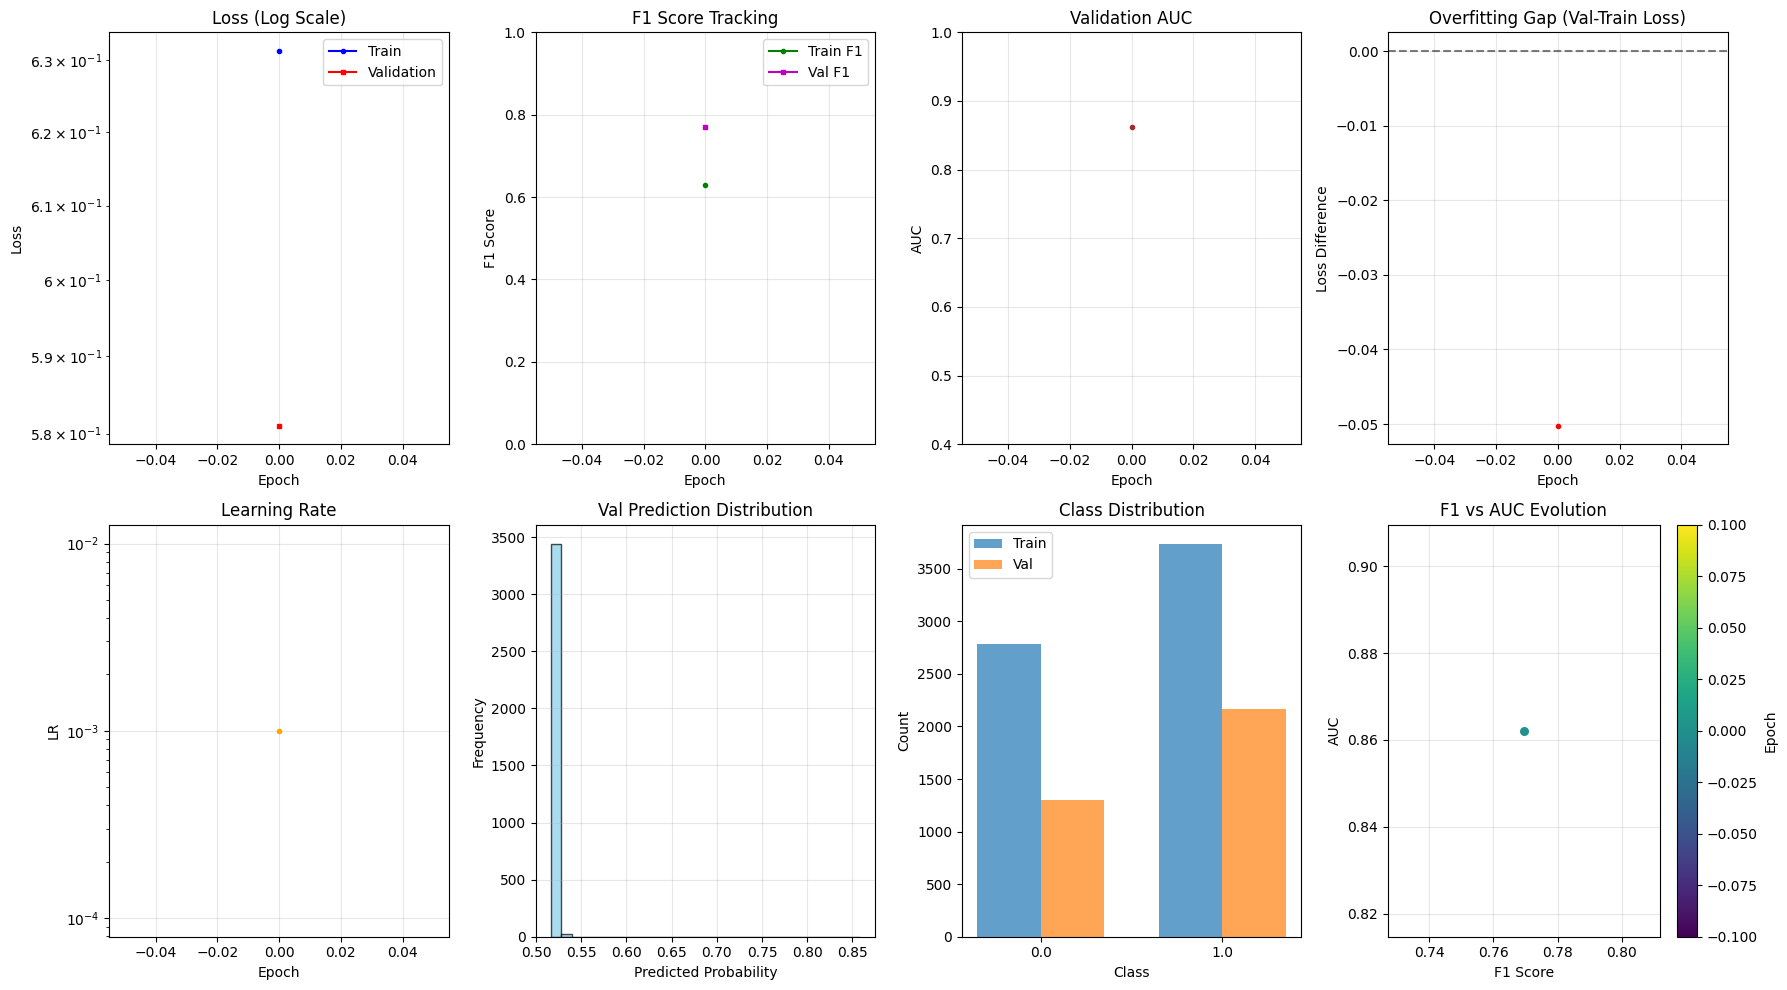

wandb: Network error (SSLError), entering retry loop.


In [ ]:
# ==============================
# ENHANCED STEP 7: ROBUST TRAINING WITH WANDB + SEEDING
# ==============================

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import random
import wandb
import time
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt

# ==============================
# RANDOM SEEDING FOR REPRODUCIBILITY
# ==============================
def set_all_seeds(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"🎲 All seeds set to {seed} for reproducibility")

# Set seeds at the start
set_all_seeds(42)

# ==============================
# WANDB SETUP WITH FIXED SETTINGS
# ==============================
WANDB_API_KEY = "4cac7a348a78f711d2890b70c3252efbe9c16fe5"  # Your API key

def setup_wandb(project_name, run_name, config=None):
    """Setup WandB with proper settings (no invalid parameters)"""
    # Clear environment and setup
    os.environ["WANDB_API_KEY"] = WANDB_API_KEY
    os.environ["WANDB_MODE"] = "online"
    
    # Login
    try:
        wandb.login(key=WANDB_API_KEY, force=True, relogin=True)
        print("✅ WandB login successful - ONLINE MODE ENABLED")
    except Exception as e:
        print(f"❌ WandB login failed: {e}")
        raise
    
    # Initialize with FIXED settings (no _disable_service)
    run = wandb.init(
        project=project_name,
        name=run_name,
        config=config,
        mode="online",
        force=True,
        reinit=True,
        settings=wandb.Settings(_service_wait=300)  # Only valid parameter
    )
    
    # Check if run is properly initialized
    if run is None:
        print("WARNING: WandB run not properly initialized!")
    else:
        print("SUCCESS: WandB run initialized!")
    
    return run

# ==============================
# ENHANCED ROBUST TRAINING FUNCTION
# ==============================

def train_lstm_robust_antioverfitting_wandb(X_train, y_train, X_val, y_val, params, model, epochs=30, use_wandb=True):
    """
    Step 7 robust training with WandB logging and proper seeding
    """
    # Set seeds for this training session
    set_all_seeds(params.get('seed', 42))
    
    # Setup WandB if requested
    if use_wandb:
        wandb_run = setup_wandb(
            project_name="lstm-attack-detection-robust",
            run_name=f"robust_training_{int(time.time())}",
            config=params
        )
        wandb.watch(model, log="all", log_freq=50)
        
        # Log model architecture
        total_params = sum(p.numel() for p in model.parameters())
        wandb.log({
            "model/total_parameters": total_params,
            "model/params_per_sample": total_params/len(X_train)
        })
    
    # Data preparation (exactly as in Step 7)
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_val = y_val.astype(np.float32)

    # NO SHUFFLING to preserve chronology (from Step 7)
    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

    # Fixed DataLoader settings for Windows
    train_loader = DataLoader(
        train_dataset, batch_size=params['batch_size'], 
        shuffle=False, pin_memory=False, num_workers=0  # Windows fix
    )
    val_loader = DataLoader(
        val_dataset, batch_size=params['batch_size'],
        shuffle=False, pin_memory=False, num_workers=0  # Windows fix
    )

    # Optimizer with weight decay (from Step 7)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=params['lr'],
        weight_decay=params['l2_reg']
    )

    # Conservative scheduler (from Step 7)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.6, 
        patience=params.get('reduce_lr_patience', 3), verbose=True
    )

    # Loss with class weights
    criterion = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([params['pos_weight']], device=device)
    )

    # Tracking variables (from Step 7)
    train_losses, val_losses = [], []
    train_f1s, val_f1s, val_aucs = [], [], []
    best_val_f1, patience_counter = 0, 0
    best_model_state = None
    best_threshold = 0.5

    print(f"Starting training: {epochs} epochs, patience={params.get('early_stopping_patience', 15)}")

    for epoch in range(epochs):
        epoch_start_time = time.time()
        
        # =============
        # TRAINING (Step 7 logic with WandB logging)
        # =============
        model.train()
        epoch_loss, train_preds_all, train_targets_all = 0, [], []
        total_grad_norm = 0
        batch_count = 0

        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            
            # ROBUST TENSOR SHAPE HANDLING (from Step 7)
            if outputs.dim() > 1:
                outputs = outputs.squeeze(-1)  # Remove only last dimension if it exists
            if y_batch.dim() > 1:
                y_batch = y_batch.squeeze(-1)  # Remove only last dimension if it exists
                
            # Ensure both tensors have same shape
            if outputs.shape != y_batch.shape:
                print(f"Shape mismatch: outputs {outputs.shape}, targets {y_batch.shape}")
                outputs = outputs.view(-1)
                y_batch = y_batch.view(-1)
            
            loss = criterion(outputs, y_batch)
            loss.backward()
            
            # Gradient clipping (from Step 7)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), params.get('gradient_clip', 1.0))
            total_grad_norm += grad_norm
            batch_count += 1
            
            optimizer.step()

            epoch_loss += loss.item()
            
            # Collect training predictions (from Step 7)
            with torch.no_grad():
                probs = torch.sigmoid(outputs).cpu().numpy().flatten()
                preds = (probs >= 0.5).astype(int)
                train_preds_all.extend(preds)
                train_targets_all.extend(y_batch.cpu().numpy().flatten())

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Training F1
        train_f1 = f1_score(train_targets_all, train_preds_all, zero_division=0)
        train_f1s.append(train_f1)
        
        avg_grad_norm = total_grad_norm / batch_count if batch_count > 0 else 0

        # =============
        # VALIDATION (Step 7 logic with WandB logging)
        # =============
        model.eval()
        val_loss, val_probs_all, val_targets_all = 0, [], []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                
                # ROBUST TENSOR SHAPE HANDLING (from Step 7)
                if outputs.dim() > 1:
                    outputs = outputs.squeeze(-1)
                if y_batch.dim() > 1:
                    y_batch = y_batch.squeeze(-1)
                    
                # Ensure both tensors have same shape
                if outputs.shape != y_batch.shape:
                    outputs = outputs.view(-1)
                    y_batch = y_batch.view(-1)
                
                if not torch.isnan(outputs).any():
                    val_loss += criterion(outputs, y_batch).item()
                    probs = torch.sigmoid(outputs).cpu().numpy().flatten()
                    val_probs_all.extend(probs)
                    val_targets_all.extend(y_batch.cpu().numpy().flatten())

        if len(val_probs_all) > 0:
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            
            val_probs_all = np.array(val_probs_all)
            val_targets_all = np.array(val_targets_all)
            
            # Calculate metrics (from Step 7)
            if len(np.unique(val_targets_all)) > 1:
                val_auc = roc_auc_score(val_targets_all, val_probs_all)
            else:
                val_auc = 0.5
            val_aucs.append(val_auc)
            
            # Best F1 across thresholds (from Step 7)
            best_val_f1_epoch = 0
            best_thresh_epoch = 0.5
            threshold_f1_scores = []
            for thresh in np.arange(0.1, 0.9, 0.05):
                preds = (val_probs_all >= thresh).astype(int)
                f1 = f1_score(val_targets_all, preds, zero_division=0)
                threshold_f1_scores.append(f1)
                if f1 > best_val_f1_epoch:
                    best_val_f1_epoch = f1
                    best_thresh_epoch = thresh
            
            val_f1s.append(best_val_f1_epoch)
            
            # Calculate additional metrics for WandB
            val_precision = precision_score(val_targets_all, (val_probs_all >= best_thresh_epoch).astype(int), zero_division=0)
            val_recall = recall_score(val_targets_all, (val_probs_all >= best_thresh_epoch).astype(int), zero_division=0)
            
            # Calculate overfitting metrics
            loss_gap = avg_val_loss - avg_train_loss
            f1_gap = train_f1 - best_val_f1_epoch if train_f1 > 0 else 0
            
            epoch_time = time.time() - epoch_start_time
            
            # LOG EVERYTHING TO WANDB
            if use_wandb:
                log_dict = {
                    # Basic metrics
                    "epoch": epoch,
                    "train/loss": avg_train_loss,
                    "train/f1": train_f1,
                    "val/loss": avg_val_loss,
                    "val/f1": best_val_f1_epoch,
                    "val/auc": val_auc,
                    "val/precision": val_precision,
                    "val/recall": val_recall,
                    "val/best_threshold": best_thresh_epoch,
                    
                    # Learning dynamics
                    "train/learning_rate": optimizer.param_groups[0]['lr'],
                    "train/gradient_norm": avg_grad_norm,
                    "train/epoch_time": epoch_time,
                    
                    # Overfitting indicators
                    "overfitting/loss_gap": loss_gap,
                    "overfitting/f1_gap": f1_gap,
                    "overfitting/loss_ratio": avg_val_loss / avg_train_loss if avg_train_loss > 0 else 1,
                    
                    # Model tracking
                    "model/patience_counter": patience_counter,
                    "model/best_val_f1": best_val_f1,
                    "model/is_best_epoch": best_val_f1_epoch > best_val_f1,
                    
                    # Data distribution
                    "data/val_pred_mean": np.mean(val_probs_all),
                    "data/val_pred_std": np.std(val_probs_all),
                    "data/val_class_balance": np.mean(val_targets_all),
                }
                
                # Add threshold analysis
                thresholds = np.arange(0.1, 0.9, 0.05)
                for i, (thresh, f1_score_thresh) in enumerate(zip(thresholds, threshold_f1_scores)):
                    log_dict[f"threshold_analysis/f1_at_{thresh:.2f}"] = f1_score_thresh
                
                wandb.log(log_dict)
                
                # Log histograms every 5 epochs
                if (epoch + 1) % 5 == 0:
                    wandb.log({
                        "histograms/val_predictions": wandb.Histogram(val_probs_all),
                        "histograms/val_targets": wandb.Histogram(val_targets_all)
                    })

            # Print progress (from Step 7)
            print(f"Epoch {epoch+1:2d} | Loss: T={avg_train_loss:.4f} V={avg_val_loss:.4f} | "
                  f"F1: T={train_f1:.4f} V={best_val_f1_epoch:.4f} | AUC: {val_auc:.4f} | "
                  f"Time: {epoch_time:.1f}s")

            # Early stopping (from Step 7)
            if best_val_f1_epoch > best_val_f1 + params.get('min_delta', 1e-4):
                best_val_f1 = best_val_f1_epoch
                best_threshold = best_thresh_epoch
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                patience_counter = 0
                print(f"    ✅ New best F1: {best_val_f1:.4f}")
                
                if use_wandb:
                    wandb.log({"events/new_best_model": True, "epoch": epoch})
            else:
                patience_counter += 1

            # Overfitting detection (from Step 7)
            if len(train_losses) > 1 and len(val_losses) > 1:
                loss_gap = avg_val_loss - avg_train_loss
                if loss_gap > 0.05 and epoch > 5:
                    print(f"    ⚠️ Loss gap detected: {loss_gap:.4f}")
                    if use_wandb:
                        wandb.log({"warnings/overfitting_detected": True, "epoch": epoch})

            # Learning rate scheduling (from Step 7)
            scheduler.step(best_val_f1_epoch)

            # Early stopping check
            if patience_counter >= params.get('early_stopping_patience', 15):
                print(f"⏹ Early stopping at epoch {epoch+1}")
                if use_wandb:
                    wandb.log({"events/early_stopping": True, "final_epoch": epoch})
                break

            # Enhanced plotting every 3 epochs (from Step 7)
            if (epoch + 1) % 3 == 0 or epoch == 0:
                plt.figure(figsize=(18, 10))

                # 1. Loss with log scale
                plt.subplot(2, 4, 1)
                plt.plot(train_losses, 'b-o', label='Train', markersize=3)
                plt.plot(val_losses, 'r-s', label='Validation', markersize=3)
                plt.title("Loss (Log Scale)")
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.yscale('log')
                plt.legend()
                plt.grid(True, alpha=0.3)

                # 2. F1 Score Comparison  
                plt.subplot(2, 4, 2)
                plt.plot(train_f1s, 'g-o', label='Train F1', markersize=3)
                plt.plot(val_f1s, 'm-s', label='Val F1', markersize=3)
                plt.title("F1 Score Tracking")
                plt.xlabel("Epoch")
                plt.ylabel("F1 Score")
                plt.ylim(0, 1)
                plt.legend()
                plt.grid(True, alpha=0.3)

                # 3. Validation AUC
                plt.subplot(2, 4, 3)
                plt.plot(val_aucs, 'brown', marker='o', markersize=3)
                plt.title("Validation AUC")
                plt.xlabel("Epoch")
                plt.ylabel("AUC")
                plt.ylim(0.4, 1.0)
                plt.grid(True, alpha=0.3)

                # 4. Overfitting indicator
                plt.subplot(2, 4, 4)
                if len(val_losses) == len(train_losses):
                    gap = np.array(val_losses) - np.array(train_losses)
                    plt.plot(gap, 'red', marker='o', markersize=3)
                    plt.title("Overfitting Gap (Val-Train Loss)")
                    plt.xlabel("Epoch")
                    plt.ylabel("Loss Difference")
                    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
                    plt.grid(True, alpha=0.3)

                # 5. Learning Rate
                plt.subplot(2, 4, 5)
                current_lr = optimizer.param_groups[0]['lr']
                lr_history = [current_lr] * (epoch + 1)  # Simplified
                plt.plot(lr_history, 'orange', marker='o', markersize=3)
                plt.title("Learning Rate")
                plt.xlabel("Epoch")
                plt.ylabel("LR")
                plt.yscale('log')
                plt.grid(True, alpha=0.3)

                # 6. Prediction Distribution
                plt.subplot(2, 4, 6)
                if len(val_probs_all) > 0:
                    plt.hist(val_probs_all, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
                plt.title("Val Prediction Distribution")
                plt.xlabel("Predicted Probability")
                plt.ylabel("Frequency")
                plt.grid(True, alpha=0.3)

                # 7. Class Balance
                plt.subplot(2, 4, 7)
                train_unique, train_counts = np.unique(train_targets_all, return_counts=True)
                val_unique, val_counts = np.unique(val_targets_all, return_counts=True)
                
                x_pos = np.arange(len(train_unique))
                width = 0.35
                plt.bar(x_pos - width/2, train_counts, width, label='Train', alpha=0.7)
                plt.bar(x_pos + width/2, val_counts, width, label='Val', alpha=0.7)
                plt.title("Class Distribution")
                plt.xlabel("Class")
                plt.ylabel("Count")
                plt.legend()
                plt.xticks(x_pos, train_unique)

                # 8. F1 vs AUC
                plt.subplot(2, 4, 8)
                if len(val_f1s) > 0 and len(val_aucs) > 0:
                    plt.scatter(val_f1s, val_aucs, c=range(len(val_f1s)), cmap='viridis', s=30)
                    plt.colorbar(label='Epoch')
                plt.title("F1 vs AUC Evolution")
                plt.xlabel("F1 Score")
                plt.ylabel("AUC")
                plt.grid(True, alpha=0.3)

                plt.tight_layout()
                plt.show()
                
                # Log plot to WandB
                if use_wandb:
                    wandb.log({"training_plots": wandb.Image(plt)})
                    plt.close()

        else:
            print(f"⚠️ No valid validation data at epoch {epoch+1}")
            if use_wandb:
                wandb.log({"events/no_valid_validation_data": True, "epoch": epoch})
            break

    # Restore best model (from Step 7)
    if best_model_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
        print(f"✅ Restored best model with validation F1: {best_val_f1:.4f}")
    else:
        print("⚠️ No improvement found, using final model")

    # Log final training summary to WandB
    if use_wandb:
        wandb.log({
            "final/best_val_f1": best_val_f1,
            "final/best_threshold": best_threshold,
            "final/total_epochs": len(train_losses),
            "final/converged": patience_counter < params.get('early_stopping_patience', 15)
        })
        
        # Log training curves as summary
        wandb.run.summary["train_loss_curve"] = train_losses
        wandb.run.summary["val_loss_curve"] = val_losses
        wandb.run.summary["train_f1_curve"] = train_f1s
        wandb.run.summary["val_f1_curve"] = val_f1s
        wandb.run.summary["val_auc_curve"] = val_aucs

    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_f1s': train_f1s,
        'val_f1s': val_f1s,
        'val_aucs': val_aucs,
        'best_val_f1': best_val_f1,
        'best_threshold': best_threshold
    }

# ==============================
# DEBUG FUNCTION FROM STEP 7
# ==============================

def debug_tensor_shapes(model, X_sample, y_sample):
    """Debug function to check tensor shapes (from Step 7)"""
    print("\n=== TENSOR SHAPE DEBUGGING ===")
    
    model.eval()
    with torch.no_grad():
        X_tensor = torch.from_numpy(X_sample[:5].astype(np.float32)).to(device)
        y_tensor = torch.from_numpy(y_sample[:5].astype(np.float32)).to(device)
        
        print(f"Input X shape: {X_tensor.shape}")
        print(f"Input y shape: {y_tensor.shape}")
        
        outputs = model(X_tensor)
        print(f"Raw model output shape: {outputs.shape}")
        print(f"Raw model output: {outputs}")
        
        # Test different squeeze operations
        squeezed_once = outputs.squeeze(-1) if outputs.dim() > 1 else outputs
        print(f"After squeeze(-1): {squeezed_once.shape}")
        
        # What we need for loss function
        if y_tensor.dim() > 1:
            y_tensor_fixed = y_tensor.squeeze(-1)
        else:
            y_tensor_fixed = y_tensor
        print(f"Target tensor final shape: {y_tensor_fixed.shape}")
        
        # Test if they match now
        print(f"Shapes match: {squeezed_once.shape == y_tensor_fixed.shape}")
        
        return squeezed_once.shape, y_tensor_fixed.shape

# ==============================
# MAIN EXECUTION WITH STEP 7 LOGIC + WANDB
# ==============================

print("\n=== ENHANCED STEP 7: Robust LSTM Training with WandB ===")

# Create model (use your existing AdvancedLSTM class)
final_model = AdvancedLSTM(
    input_dim=X_train_seq.shape[2],
    hidden_dim=best_params['hidden_dim'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout'],
    use_attention=best_params['use_attention'],
    bidirectional=best_params['bidirectional']
).to(device)

# Add seeding to best_params
enhanced_params = best_params.copy()
enhanced_params.update({
    'seed': 42,
    'early_stopping_patience': 15,
    'gradient_clip': 1.0,
    'reduce_lr_patience': 3,
    'min_delta': 1e-4,
    'epochs': 100
})

total_params = sum(p.numel() for p in final_model.parameters())
print(f"Model parameters: {total_params:,}")
print(f"Parameters per training sample: {total_params/len(X_train_seq):.2f}")

# Debug tensor shapes before training (from Step 7)
print("\n🔍 Debugging tensor shapes...")
debug_tensor_shapes(final_model, X_train_seq, y_train_seq)

# Execute enhanced robust training with WandB
print("\n🚀 Starting enhanced robust training with WandB...")
final_model, training_history = train_lstm_robust_antioverfitting_wandb(
    X_train_seq, y_train_seq, X_val_seq, y_val_seq,
    enhanced_params, final_model, epochs=enhanced_params['epochs'], use_wandb=True
)

print(f"\n✅ Training completed!")
if training_history['val_f1s']:
    print(f"Best validation F1: {max(training_history['val_f1s']):.4f}")
    print(f"Best validation AUC: {max(training_history['val_aucs']):.4f}")

# ==============================
# FINAL TEST EVALUATION WITH WANDB (Step 7 logic)
# ==============================
print("\n=== Final Test Evaluation ===")

final_model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test_seq.astype(np.float32)).to(device)
    test_outputs = final_model(X_test_tensor)
    
    # ROBUST SHAPE HANDLING (from Step 7)
    if test_outputs.dim() > 1:
        test_outputs = test_outputs.squeeze(-1)
    
    test_probs = torch.sigmoid(test_outputs).cpu().numpy().flatten()

# Use the optimal threshold found during validation
test_preds = (test_probs >= training_history['best_threshold']).astype(int)

# Calculate comprehensive test metrics
test_f1 = f1_score(y_test_seq, test_preds, zero_division=0)
if len(np.unique(y_test_seq)) > 1:
    test_auc = roc_auc_score(y_test_seq, test_probs)
else:
    test_auc = 0.5

test_precision = precision_score(y_test_seq, test_preds, zero_division=0)
test_recall = recall_score(y_test_seq, test_preds, zero_division=0)
test_cm = confusion_matrix(y_test_seq, test_preds)

# Log comprehensive test results to WandB
tn, fp, fn, tp = test_cm.ravel()
wandb.log({
    "test/f1": test_f1,
    "test/auc": test_auc,
    "test/precision": test_precision,
    "test/recall": test_recall,
    "test/threshold": training_history['best_threshold'],
    "test/true_negatives": tn,
    "test/false_positives": fp,
    "test/false_negatives": fn,
    "test/true_positives": tp,
    "test/false_negative_rate": fn/(fn+tp) if (fn+tp) > 0 else 0,
    "test/false_positive_rate": fp/(fp+tn) if (fp+tn) > 0 else 0,
    "test/specificity": tn/(tn+fp) if (tn+fp) > 0 else 0,
    "test/sensitivity": tp/(tp+fn) if (tp+fn) > 0 else 0
})

# Log confusion matrix as heatmap
wandb.log({
    "test/confusion_matrix": wandb.plot.confusion_matrix(
        preds=test_preds,
        y_true=y_test_seq,
        class_names=["Benign", "Attack"]
    )
})

print(f"\n" + "=" * 50)
print("FINAL TEST RESULTS")
print("=" * 50)
print(f"F1 Score: {test_f1:.4f}")
print(f"AUC Score: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Threshold: {training_history['best_threshold']:.3f}")
print(f"\nConfusion Matrix:")
print(f"               Predicted")
print(f"           Benign  Attack")
print(f"Actual Benign   {test_cm[0,0]:6d}  {test_cm[0,1]:6d}")
print(f"       Attack   {test_cm[1,0]:6d}  {test_cm[1,1]:6d}")

# ==============================
# OVERFITTING ANALYSIS WITH WANDB (from Step 7)
# ==============================
print("\n=== Overfitting Analysis ===")

if len(training_history['train_losses']) > 5 and len(training_history['val_losses']) > 5:
    final_train_loss = training_history['train_losses'][-1]
    final_val_loss = training_history['val_losses'][-1]
    min_train_loss = min(training_history['train_losses'])
    
    loss_ratio = final_val_loss / final_train_loss
    print(f"Final loss ratio (Val/Train): {loss_ratio:.2f}")
    
    # Log overfitting analysis to WandB
    wandb.log({
        "analysis/loss_ratio": loss_ratio,
        "analysis/min_train_loss": min_train_loss,
        "analysis/final_train_loss": final_train_loss,
        "analysis/final_val_loss": final_val_loss
    })
    
    if loss_ratio > 3:
        print("🚨 HIGH overfitting detected (Val loss >> Train loss)")
        wandb.log({"analysis/overfitting_level": "HIGH"})
    elif loss_ratio > 1.5:
        print("⚠️ Moderate overfitting detected")
        wandb.log({"analysis/overfitting_level": "MODERATE"})
    else:
        print("✅ Good loss ratio - minimal overfitting")
        wandb.log({"analysis/overfitting_level": "MINIMAL"})
    
    # Check for training loss collapse
    if min_train_loss < 0.01:
        print("⚠️ Training loss very low - possible memorization")
        wandb.log({"analysis/possible_memorization": True})
    
    # F1 gap analysis (from Step 7)
    if training_history['train_f1s'] and training_history['val_f1s']:
        f1_gap = max(training_history['train_f1s']) - max(training_history['val_f1s'])
        print(f"F1 gap (Train - Val): {f1_gap:.4f}")
        
        wandb.log({"analysis/f1_gap": f1_gap})
        
        if f1_gap > 0.2:
            print("🚨 Large F1 gap - significant overfitting")
            wandb.log({"analysis/f1_overfitting": "SIGNIFICANT"})
        elif f1_gap > 0.1:
            print("⚠️ Moderate F1 gap")
            wandb.log({"analysis/f1_overfitting": "MODERATE"})
        else:
            print("✅ Good F1 generalization")
            wandb.log({"analysis/f1_overfitting": "MINIMAL"})

# Training summary (from Step 7)
print("\n=== Training Summary ===")
print("If you're still seeing overfitting:")
print("1. Reduce hidden_dim further (try 32 or 16)")
print("2. Increase dropout to 0.6-0.8") 
print("3. Reduce sequence length")
print("4. Add more data augmentation")
print("5. Consider simpler models (non-LSTM)")

# ==============================
# SAVE MODEL AND RESULTS WITH WANDB
# ==============================

# Save model (from Step 7)
torch.save(final_model.state_dict(), "enhanced_robust_lstm_model.pth")
print("💾 Model saved as enhanced_robust_lstm_model.pth")

# Prepare comprehensive results
results = {
    'training_history': training_history,
    'test_metrics': {
        'f1': test_f1,
        'auc': test_auc,
        'precision': test_precision,
        'recall': test_recall,
        'threshold': training_history['best_threshold'],
        'confusion_matrix': test_cm.tolist()
    },
    'model_params': enhanced_params,
    'overfitting_analysis': {
        'loss_ratio': loss_ratio if 'loss_ratio' in locals() else None,
        'f1_gap': f1_gap if 'f1_gap' in locals() else None
    }
}

# Save results locally
import json
with open("enhanced_robust_lstm_results.json", "w") as f:
    json.dump(results, f, indent=2, default=str)

# Log artifacts to WandB
wandb.save("enhanced_robust_lstm_model.pth")
wandb.save("enhanced_robust_lstm_results.json")

# Final summary to WandB
wandb.run.summary.update({
    "final_test_f1": test_f1,
    "final_test_auc": test_auc,
    "final_test_precision": test_precision,
    "final_test_recall": test_recall,
    "final_threshold": training_history['best_threshold'],
    "model_parameters": total_params,
    "reproducible_seed": enhanced_params['seed']
})

print(f"\n💾 All files saved and logged to WandB!")
print(f"✅ Enhanced Step 7 training completed successfully!")
print(f"🔗 Check WandB dashboard for comprehensive training analytics!")

# Finish WandB run
wandb.finish()

print("\n" + "=" * 60)
print("ENHANCED STEP 7 COMPLETE - FILES SAVED:")
print("=" * 60)
print("📁 Model: enhanced_robust_lstm_model.pth")
print("📁 Results: enhanced_robust_lstm_results.json") 
print("🔗 WandB: Check your dashboard for detailed training logs!")
print("🎲 All training was seeded for reproducibility")
print("=" * 60)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

def debug_data_differences():
    """
    Debug function to identify exactly what's different between the two testing approaches.
    """
    print("=" * 80)
    print("DEBUGGING DATA DIFFERENCES")
    print("=" * 80)
    
    # Method 1: Full dataset (like your "corrected model loading and testing v3")
    print("\nMethod 1: Full Dataset Approach")
    print("-" * 40)
    
    X_full_1 = datadf.drop(columns=["Label"]).to_numpy(dtype=np.float32)
    y_full_1 = datadf["Label"].to_numpy(dtype=np.int32)
    
    X_test_seq_1, y_test_seq_1 = create_sequences(
        X_full_1, 
        y_full_1, 
        sequence_length=seq_length,
        label_strategy='last'
    )
    
    print(f"Full dataset raw shape: {X_full_1.shape}")
    print(f"Full dataset sequences: {X_test_seq_1.shape}")
    print(f"Full dataset labels: {y_test_seq_1.shape}")
    print(f"Label distribution: {np.bincount(y_test_seq_1.astype(int))}")
    print(f"Attack percentage: {np.mean(y_test_seq_1):.4f}")
    print(f"First 10 labels: {y_test_seq_1[:10]}")
    print(f"Last 10 labels: {y_test_seq_1[-10:]}")
    
    # Method 2: Chronological split (like universal tester)
    print("\nMethod 2: Chronological Split Approach")
    print("-" * 40)
    
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = chrono_split_train_val_test(
        datadf, 
        label_col="Label", 
        train_ratio=0.7, 
        val_ratio=0.15
    )
    
    X_test_seq_2, y_test_seq_2 = create_sequences(
        X_test, 
        y_test, 
        sequence_length=seq_length,
        label_strategy='last'
    )
    
    print(f"Test split raw shape: {X_test.shape}")
    print(f"Test split sequences: {X_test_seq_2.shape}")
    print(f"Test split labels: {y_test_seq_2.shape}")
    print(f"Label distribution: {np.bincount(y_test_seq_2.astype(int))}")
    print(f"Attack percentage: {np.mean(y_test_seq_2):.4f}")
    print(f"First 10 labels: {y_test_seq_2[:10]}")
    print(f"Last 10 labels: {y_test_seq_2[-10:]}")
    
    # Compare the data
    print("\nCOMPARISON")
    print("-" * 40)
    print(f"Size difference: {X_test_seq_1.shape[0]} vs {X_test_seq_2.shape[0]}")
    print(f"Attack rate difference: {np.mean(y_test_seq_1):.4f} vs {np.mean(y_test_seq_2):.4f}")
    
    if X_test_seq_1.shape[0] == X_test_seq_2.shape[0]:
        print("Same number of sequences - checking if data is identical...")
        if np.array_equal(X_test_seq_1, X_test_seq_2):
            print("✅ Features are identical")
        else:
            print("❌ Features are different!")
            
        if np.array_equal(y_test_seq_1, y_test_seq_2):
            print("✅ Labels are identical")
        else:
            print("❌ Labels are different!")
    else:
        print("❌ Different dataset sizes - this explains the discrepancy!")
    
    return X_test_seq_1, y_test_seq_1, X_test_seq_2, y_test_seq_2

def test_model_on_both_datasets(model, X_seq_1, y_seq_1, X_seq_2, y_seq_2, device):
    """
    Test the same model on both datasets to see prediction differences.
    """
    print("\n" + "=" * 80)
    print("TESTING SAME MODEL ON BOTH DATASETS")
    print("=" * 80)
    
    model.eval()
    
    def evaluate_dataset(X_seq, y_seq, dataset_name):
        print(f"\nTesting on {dataset_name}...")
        
        X_tensor = torch.tensor(X_seq, dtype=torch.float32)
        y_tensor = torch.tensor(y_seq, dtype=torch.float32)
        
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=64, shuffle=False)
        
        all_preds = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for X_batch, y_batch in loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                probs = torch.sigmoid(outputs)
                preds = torch.round(probs)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)
        
        accuracy = np.mean(all_preds == all_labels)
        
        print(f"  Samples: {len(all_labels):,}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Attack rate (true): {np.mean(all_labels):.4f}")
        print(f"  Attack rate (pred): {np.mean(all_preds):.4f}")
        print(f"  Mean probability: {np.mean(all_probs):.4f}")
        print(f"  Prob std: {np.std(all_probs):.4f}")
        
        return all_preds, all_labels, all_probs
    
    # Test on both datasets
    preds_1, labels_1, probs_1 = evaluate_dataset(X_seq_1, y_seq_1, "Full Dataset")
    preds_2, labels_2, probs_2 = evaluate_dataset(X_seq_2, y_seq_2, "Chronological Test Split")
    
    return preds_1, labels_1, probs_1, preds_2, labels_2, probs_2

# Run the debugging
print("Starting systematic debugging...")

# Step 1: Compare the datasets
X_seq_1, y_seq_1, X_seq_2, y_seq_2 = debug_data_differences()

# Step 2: Test same model on both datasets
if 'model2' in globals():
    preds_1, labels_1, probs_1, preds_2, labels_2, probs_2 = test_model_on_both_datasets(
        model2, X_seq_1, y_seq_1, X_seq_2, y_seq_2, device
    )
    
    print("\n" + "=" * 80)
    print("SUMMARY OF DIFFERENCES")
    print("=" * 80)
    
    print(f"\nDataset sizes:")
    print(f"  Full dataset: {len(y_seq_1):,} sequences")
    print(f"  Test split: {len(y_seq_2):,} sequences")
    print(f"  Ratio: {len(y_seq_2)/len(y_seq_1):.3f}")
    
    print(f"\nClass distributions:")
    print(f"  Full dataset - Attack rate: {np.mean(y_seq_1):.4f}")
    print(f"  Test split - Attack rate: {np.mean(y_seq_2):.4f}")
    
    print(f"\nModel performance:")
    print(f"  Full dataset - Accuracy: {np.mean(preds_1 == labels_1):.4f}")
    print(f"  Test split - Accuracy: {np.mean(preds_2 == labels_2):.4f}")
    
    print(f"\nPrediction characteristics:")
    print(f"  Full dataset - Mean pred prob: {np.mean(probs_1):.4f}")
    print(f"  Test split - Mean pred prob: {np.mean(probs_2):.4f}")
    
    # Check temporal distribution
    if len(y_seq_1) > len(y_seq_2):
        test_start_idx = len(y_seq_1) - len(y_seq_2)
        print(f"\nTemporal check:")
        print(f"  Test split should be the LAST {len(y_seq_2)} sequences from full dataset")
        print(f"  Checking if test split matches full dataset[{test_start_idx}:]...")
        
        # Compare the tail of full dataset with test split
        if np.array_equal(y_seq_1[test_start_idx:], y_seq_2):
            print("  ✅ Test split correctly matches the tail of full dataset")
        else:
            print("  ❌ Test split does NOT match the tail of full dataset")
            print("     This indicates different preprocessing or splitting!")
    
else:
    print("❌ model2 not found. Please load your model first.")

print("\n" + "=" * 80)
print("CONCLUSION:")
print("The results should be different because:")
print("1. Full dataset includes training data (data leakage)")
print("2. Test split uses only unseen chronological test data")
print("3. Different class distributions between full vs test")
print("\nThe UNIVERSAL TESTER result is correct for model evaluation.")
print("=" * 80)

Starting systematic debugging...
DEBUGGING DATA DIFFERENCES

Method 1: Full Dataset Approach
----------------------------------------
Full dataset raw shape: (553749, 50)
Full dataset sequences: (553740, 10, 50)
Full dataset labels: (553740,)
Label distribution: [264817 288923]
Attack percentage: 0.5218
First 10 labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Last 10 labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Method 2: Chronological Split Approach
----------------------------------------
Test split raw shape: (83063, 50)
Test split sequences: (83054, 10, 50)
Test split labels: (83054,)
Label distribution: [83054]
Attack percentage: 0.0000
First 10 labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Last 10 labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

COMPARISON
----------------------------------------
Size difference: 553740 vs 83054
Attack rate difference: 0.5218 vs 0.0000
❌ Different dataset sizes - this explains the discrepancy!

TESTING SAME MODEL ON BOTH DATASETS

Testing on Full Dataset...


KeyboardInterrupt: 

In [23]:
# ==============================
# FINAL LSTM MODEL TRAINING WITH SPECIFIC HYPERPARAMETERS
# ==============================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, roc_auc_score
import wandb
import pickle


# Your specific hyperparameters
final_params = {
    'epochs': 100,
    'sequence_length': 128,
    'pos_weight': 0.88654,
    'num_layers': 1,
    'min_delta': 0.0000014444,
    'lr': 0.00011505,
    'l2_reg': 0.000034745,
    'l1_reg': 0.000072167,
    'early_stopping_patience': 35,
    'hidden_dim': 4,
    'gradient_clip': 4.21752,
    'dropout': 0.29761,
    'batch_size': 512,
    'bidirectional': True,  # Default choice
    'use_attention': True,  # Default choice
    'wandb_project': "lstm-cybersecurity-fixed"
}

print("=== TRAINING FINAL MODEL WITH SPECIFIC HYPERPARAMETERS ===")
print("Hyperparameters:")
for k, v in final_params.items():
    print(f"   {k}: {v}")

# Prepare data with the specified sequence length
def adjust_seq(x, target_len):
    """Adjust sequence length by padding or truncating"""
    cur = x.shape[1]
    if target_len == cur:
        return x
    if target_len < cur:
        return x[:, -target_len:, :]  # Take last target_len timesteps
    pad = target_len - cur
    return np.pad(x, ((0,0), (pad,0), (0,0)), mode='constant')  # Pad at beginning

# Adjust sequence lengths for all datasets
seq_len = final_params['sequence_length']
X_train_final = adjust_seq(X_train_seq, seq_len)
X_val_final = adjust_seq(X_val_seq, seq_len)
X_test_final = adjust_seq(X_test_seq, seq_len)

print(f"\nData shapes after sequence adjustment:")
print(f"Train: {X_train_final.shape}, Val: {X_val_final.shape}, Test: {X_test_final.shape}")

def preprocess_data_fixed(X_train, X_val, X_test, y_train, y_val, y_test):
    """
    FIXED: More conservative preprocessing to preserve signal
    """
    print("=== FIXED Data Preprocessing ===")
    
    # Convert to numpy if needed
    X_train = np.array(X_train, dtype=np.float32)
    X_val = np.array(X_val, dtype=np.float32)
    X_test = np.array(X_test, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32)
    y_val = np.array(y_val, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)
    
    # Clean data
    def clean_sequences(X, y):
        valid_mask = ~(np.isnan(X).any(axis=(1,2)) | np.isinf(X).any(axis=(1,2)) | 
                      np.isnan(y) | np.isinf(y))
        return X[valid_mask], y[valid_mask]
    
    X_train, y_train = clean_sequences(X_train, y_train)
    X_val, y_val = clean_sequences(X_val, y_val)
    X_test, y_test = clean_sequences(X_test, y_test)
    
    print(f"After cleaning - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    
    # CONSERVATIVE scaling - preserve more signal
    original_shape_train = X_train.shape
    original_shape_val = X_val.shape
    original_shape_test = X_test.shape
    
    # Reshape to (samples * timesteps, features)
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    X_val_flat = X_val.reshape(-1, X_val.shape[-1])
    X_test_flat = X_test.reshape(-1, X_test.shape[-1])
    
    # Use StandardScaler (less aggressive than RobustScaler)
    scaler = StandardScaler()
    X_train_flat = scaler.fit_transform(X_train_flat)
    X_val_flat = scaler.transform(X_val_flat)
    X_test_flat = scaler.transform(X_test_flat)
    
    pickle.dump(scaler, open('saved_scaler.pkl', 'wb'))

    # Reshape back
    X_train = X_train_flat.reshape(original_shape_train)
    X_val = X_val_flat.reshape(original_shape_val)
    X_test = X_test_flat.reshape(original_shape_test)
    
    # REMOVED: Aggressive clipping that can remove signal
    # Only clip extreme outliers (>6 sigma)
    clip_value = 6.0
    X_train = np.clip(X_train, -clip_value, clip_value)
    X_val = np.clip(X_val, -clip_value, clip_value)
    X_test = np.clip(X_test, -clip_value, clip_value)
    
    # Ensure labels are properly shaped
    y_train = y_train.reshape(-1)
    y_val = y_val.reshape(-1)
    y_test = y_test.reshape(-1)
    
    # More conservative pos_weight calculation
    train_pos_ratio = np.mean(y_train)
    val_pos_ratio = np.mean(y_val)
    
    print(f"Class balance - Train: {train_pos_ratio:.3f}, Val: {val_pos_ratio:.3f}")
    
    # Less aggressive pos_weight
    if train_pos_ratio > 0:
        pos_weight = np.sqrt((1 - train_pos_ratio) / train_pos_ratio)  # Square root for less aggressive weighting
        pos_weight = np.clip(pos_weight, 0.8, 3.0)  # Much tighter bounds
    else:
        pos_weight = 1.0
    
    print(f"Calculated pos_weight: {pos_weight:.2f}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, pos_weight

# Preprocess data
X_train_c, X_val_c, X_test_c, y_train_c, y_val_c, y_test_c, scaler, calculated_pos_weight = preprocess_data_fixed(
    X_train_final, X_val_final, X_test_final, y_train_seq, y_val_seq, y_test_seq
)

print(f"Using specified pos_weight: {final_params['pos_weight']} (calculated: {calculated_pos_weight:.5f})")

# Create the model
final_model = AdvancedLSTM(
    input_dim=X_train_c.shape[2],
    hidden_dim=final_params['hidden_dim'],
    num_layers=final_params['num_layers'],
    dropout=final_params['dropout'],
    bidirectional=final_params['bidirectional'],
    use_attention=final_params['use_attention']
).to(device)

print(f"\nModel created with {sum(p.numel() for p in final_model.parameters())} parameters")

# Initialize W&B with comprehensive config
wandb_config = {
    # Specified hyperparameters
    'sequence_length': final_params['sequence_length'],
    'pos_weight': final_params['pos_weight'],
    'num_layers': final_params['num_layers'],
    'lr': final_params['lr'],
    'l2_reg': final_params['l2_reg'],
    'l1_reg': final_params['l1_reg'],
    'hidden_dim': final_params['hidden_dim'],
    'gradient_clip': final_params['gradient_clip'],
    'early_stopping_patience': final_params['early_stopping_patience'],
    'dropout': final_params['dropout'],
    'batch_size': final_params['batch_size'],
    'bidirectional': final_params['bidirectional'],
    'use_attention': final_params['use_attention'],
    'epochs': final_params['epochs'],
    
    # Model and data info
    'model_params': sum(p.numel() for p in final_model.parameters()),
    'device': str(device),
    'train_samples': len(X_train_c),
    'val_samples': len(X_val_c),
    'test_samples': len(X_test_c),
    'input_features': X_train_c.shape[2],
    'sequence_length_actual': X_train_c.shape[1],
    'train_pos_ratio': float(np.mean(y_train_c)),
    'val_pos_ratio': float(np.mean(y_val_c)),
    'test_pos_ratio': float(np.mean(y_test_c)),
    
    # Training setup
    'model_type': 'FixedLSTM',
    'optimizer_type': 'Adam',
    'loss_function': 'BCEWithLogitsLoss',
    'scheduler_type': 'ReduceLROnPlateau',
    'data_normalization': 'StandardScaler',
    'training_mode': 'final_model_specific_hyperparams'
}

# Initialize W&B run
run = wandb.init(
    project=final_params["wandb_project"],
    name="best_model_final_test",
    config=wandb_config,
    tags=["final_model", "specific_hyperparams", "best_model_final_test"],
    reinit=True
)

wandb.watch(final_model, log="all", log_freq=100)

print(f"\nStarting training - logging to W&B project: {final_params['wandb_project']}")
print(f"Run name: best_model_final_test")

try:
    # Prepare data loaders
    X_train_c = X_train_c.astype(np.float32)
    X_val_c = X_val_c.astype(np.float32)
    y_train_c = y_train_c.astype(np.float32)
    y_val_c = y_val_c.astype(np.float32)

    train_loader = DataLoader(
        TensorDataset(torch.from_numpy(X_train_c), torch.from_numpy(y_train_c)),
        batch_size=final_params['batch_size'], 
        shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(torch.from_numpy(X_val_c), torch.from_numpy(y_val_c)),
        batch_size=final_params['batch_size'], 
        shuffle=False
    )

    # Setup optimizer and scheduler
    optimizer = torch.optim.Adam(
        final_model.parameters(),
        lr=final_params['lr'],
        weight_decay=final_params['l2_reg'],
        betas=(0.9, 0.999)
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.7, patience=7, verbose=True, min_lr=5e-6
    )

    criterion = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([final_params['pos_weight']], device=device)
    )

    # Training loop
    train_losses, val_losses = [], []
    train_f1s, val_f1s, val_aucs = [], [], []
    best_val_f1, patience_counter = 0.0, 0
    best_model_state = None
    performance_history = []

    final_model.to(device)

    for epoch in range(final_params['epochs']):
        # --- TRAINING PHASE ---
        final_model.train()
        epoch_loss = 0.0
        train_preds_all, train_targets_all = [], []

        for batch_idx, (Xb, yb) in enumerate(train_loader):
            Xb = Xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = final_model(Xb).view(-1)
            loss = criterion(logits, yb.view(-1))
            
            # Add L1 regularization if specified
            if final_params['l1_reg'] > 0:
                l1_penalty = sum(p.abs().sum() for p in final_model.parameters())
                loss = loss + final_params['l1_reg'] * l1_penalty

            loss.backward()
            torch.nn.utils.clip_grad_norm_(final_model.parameters(), final_params['gradient_clip'])
            optimizer.step()

            epoch_loss += loss.item()

            # Collect predictions for F1 calculation
            with torch.no_grad():
                probs = torch.sigmoid(logits).detach().cpu().numpy().flatten()
                preds = (probs >= 0.5).astype(int)
                train_preds_all.extend(preds.tolist())
                train_targets_all.extend(yb.detach().cpu().numpy().flatten().tolist())

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Calculate training F1
        if len(set(train_targets_all)) > 1:
            train_f1 = f1_score(train_targets_all, train_preds_all, zero_division=0)
        else:
            train_f1 = 0.0
        train_f1s.append(train_f1)

        # --- VALIDATION PHASE ---
        final_model.eval()
        val_loss_sum = 0.0
        val_probs_all, val_targets_all = [], []
        
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb = Xb.to(device)
                yb = yb.to(device)
                logits = final_model(Xb).view(-1)
                val_loss_sum += criterion(logits, yb.view(-1)).item()
                
                probs = torch.sigmoid(logits).detach().cpu().numpy().flatten()
                val_probs_all.extend(probs.tolist())
                val_targets_all.extend(yb.detach().cpu().numpy().flatten().tolist())

        avg_val_loss = val_loss_sum / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate validation metrics
        if len(np.unique(val_targets_all)) > 1:
            val_auc = roc_auc_score(val_targets_all, val_probs_all)
        else:
            val_auc = 0.5
        val_aucs.append(val_auc)

        # Find best validation F1 across thresholds
        best_val_f1_epoch = 0.0
        vp = np.array(val_probs_all)
        vt = np.array(val_targets_all)
        for thresh in np.arange(0.3, 0.7, 0.05):
            preds = (vp >= thresh).astype(int)
            f1 = f1_score(vt, preds, zero_division=0)
            if f1 > best_val_f1_epoch:
                best_val_f1_epoch = f1
        val_f1s.append(best_val_f1_epoch)

        # Combined performance metric
        current_perf = (train_f1 + best_val_f1_epoch + val_auc) / 3.0
        performance_history.append(current_perf)

        # Calculate metrics for logging
        loss_gap = avg_val_loss - avg_train_loss
        grad_norms = [p.grad.norm().item() for p in final_model.parameters() if p.grad is not None]
        avg_grad_norm = np.mean(grad_norms) if grad_norms else 0.0
        max_grad_norm = np.max(grad_norms) if grad_norms else 0.0

        # Log to console
        print(f"Epoch {epoch+1:2d}/{final_params['epochs']} | "
              f"Loss: T={avg_train_loss:.4f} V={avg_val_loss:.4f} Gap={loss_gap:.4f}")
        print(f"         | F1: T={train_f1:.4f} V={best_val_f1_epoch:.4f} | "
              f"AUC: {val_auc:.4f} | Perf: {current_perf:.4f}")

        # Comprehensive logging to W&B
        log_dict = {
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "loss_gap": loss_gap,
            "train_f1": train_f1,
            "val_f1": best_val_f1_epoch,
            "val_auc": val_auc,
            "combined_performance": current_perf,
            "learning_rate": optimizer.param_groups[0]['lr'],
            "patience_counter": patience_counter,
            "gradients/avg_norm": avg_grad_norm,
            "gradients/max_norm": max_grad_norm,
            "training/overfitting_gap": loss_gap,
            "model_state/weight_norm": sum(p.norm().item() for p in final_model.parameters()),
            "predictions/val_prob_mean": np.mean(val_probs_all),
            "predictions/val_prob_std": np.std(val_probs_all),
        }
        wandb.log(log_dict)

        # Early stopping and best model tracking
        if best_val_f1_epoch > best_val_f1:
            best_val_f1 = best_val_f1_epoch
            best_model_state = {k: v.detach().cpu().clone() for k, v in final_model.state_dict().items()}
            patience_counter = 0
            print(f"    ✓ New best F1: {best_val_f1:.4f}")
            wandb.log({
                "best_val_f1": best_val_f1,
                "best_epoch": epoch + 1,
                "best_model_saved": 1
            })
        else:
            patience_counter += 1

        # Early stopping check
        if patience_counter >= final_params['early_stopping_patience']:
            print(f"Early stopping after {patience_counter} epochs without improvement")
            wandb.log({"early_stop": 1, "early_stop_epoch": epoch + 1})
            break

        scheduler.step(current_perf)

    # Restore best model
    if best_model_state is not None:
        final_model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
        print(f"\nRestored best model with validation F1: {best_val_f1:.4f}")

    # --- FINAL TEST EVALUATION ---
    print("\n=== FINAL TEST EVALUATION ===")
    final_model.eval()

    with torch.no_grad():
        # Get test predictions
        X_test_tensor = torch.from_numpy(X_test_c.astype(np.float32)).to(device)
        test_logits = final_model(X_test_tensor)
        test_probs = torch.sigmoid(test_logits).detach().cpu().numpy().flatten()

        # Get validation predictions for threshold optimization
        X_val_tensor = torch.from_numpy(X_val_c.astype(np.float32)).to(device)
        val_probs = torch.sigmoid(final_model(X_val_tensor)).detach().cpu().numpy().flatten()

        # Find best threshold on validation set
        best_threshold, best_val_f1_thresh = 0.5, 0.0
        for th in np.arange(0.3, 0.7, 0.05):
            vpred = (val_probs >= th).astype(int)
            vf1 = f1_score(y_val_c, vpred, zero_division=0)
            if vf1 > best_val_f1_thresh:
                best_val_f1_thresh = vf1
                best_threshold = float(th)

        # Apply best threshold to test set
        test_preds = (test_probs >= best_threshold).astype(int)
        test_f1 = f1_score(y_test_c, test_preds, zero_division=0)
        test_auc = roc_auc_score(y_test_c, test_probs) if len(np.unique(y_test_c)) > 1 else 0.5

        print(f"Final Test Results:")
        print(f"   F1 Score: {test_f1:.4f}")
        print(f"   AUC Score: {test_auc:.4f}")
        print(f"   Best Threshold: {best_threshold:.3f}")
        print(f"   Test Samples: {len(y_test_c)}")

        # Log final test results
        final_test_results = {
            "final_test/f1_score": test_f1,
            "final_test/auc_score": test_auc,
            "final_test/best_threshold": best_threshold,
            "final_test/test_samples": len(y_test_c),
            "final_test/test_pos_ratio": float(np.mean(y_test_c)),
            "final_test/completed": 1,
            "summary/total_epochs_trained": epoch + 1,
            "summary/best_val_f1": best_val_f1,
            "summary/early_stopped": int(patience_counter >= final_params['early_stopping_patience']),
            "summary/final_lr": optimizer.param_groups[0]['lr']
        }

        # Include all hyperparameters in final results
        for k, v in final_params.items():
            if isinstance(v, (int, float, bool, str)):
                final_test_results[f"hyperparams/{k}"] = v

        wandb.log(final_test_results)

        print(f"\n✓ Training completed and logged to W&B run: best_model_final_test")
        print(f"✓ All results saved to W&B project: {final_params['wandb_project']}")
except Exception as e: 
        print(f"Error during training: {e}") 
        wandb.log({"training_error": str(e)}) 
        raise 
finally: 
    wandb.finish()
    # --- SAVE MODEL AND HYPERPARAMETERS LOCALLY ---
    # Save model
    torch.save(final_model.state_dict(), "saved_model.pth")
    print(f"\n✓ Model saved locally as: saved_model.pth")

    # Save hyperparameters
    import json
    with open("saved_parameters.json", "w") as f:
        json.dump(final_params, f, indent=4)
    print("✓ Hyperparameters saved locally as: saved_parameters.json")

    print("\n" + "="*60)
    print("FINAL MODEL TRAINING COMPLETED")
    print("="*60)


=== TRAINING FINAL MODEL WITH SPECIFIC HYPERPARAMETERS ===
Hyperparameters:
   epochs: 100
   sequence_length: 128
   pos_weight: 0.88654
   num_layers: 1
   min_delta: 1.4444e-06
   lr: 0.00011505
   l2_reg: 3.4745e-05
   l1_reg: 7.2167e-05
   early_stopping_patience: 35
   hidden_dim: 4
   gradient_clip: 4.21752
   dropout: 0.29761
   batch_size: 512
   bidirectional: True
   use_attention: True
   wandb_project: lstm-cybersecurity-fixed

Data shapes after sequence adjustment:
Train: (13675, 128, 50), Val: (7264, 128, 50), Test: (7264, 128, 50)
=== FIXED Data Preprocessing ===
After cleaning - Train: 13675, Val: 7264, Test: 7264
Class balance - Train: 0.560, Val: 0.365
Calculated pos_weight: 0.89
Using specified pos_weight: 0.88654 (calculated: 0.88654)
Initializing AdvancedLSTM:
  Input dim: 50
  Hidden dim: 4
  Num layers: 1
  Dropout: 0.29761
  Attention: True
  Bidirectional: True
  Total parameters: 2,137
  Trainable parameters: 2,137

Model created with 2137 parameters



Starting training - logging to W&B project: lstm-cybersecurity-fixed
Run name: best_model_final_test
Epoch  1/100 | Loss: T=0.7131 V=0.6426 Gap=-0.0705
         | F1: T=0.0000 V=0.5347 | AUC: 0.6060 | Perf: 0.3802
    ✓ New best F1: 0.5347
Epoch  2/100 | Loss: T=0.7070 V=0.6419 Gap=-0.0651
         | F1: T=0.0000 V=0.5427 | AUC: 0.6947 | Perf: 0.4125
    ✓ New best F1: 0.5427
Epoch  3/100 | Loss: T=0.7015 V=0.6378 Gap=-0.0637
         | F1: T=0.0000 V=0.6229 | AUC: 0.7962 | Perf: 0.4730
    ✓ New best F1: 0.6229
Epoch  4/100 | Loss: T=0.6957 V=0.6329 Gap=-0.0628
         | F1: T=0.0000 V=0.7153 | AUC: 0.8322 | Perf: 0.5158
    ✓ New best F1: 0.7153
Epoch  5/100 | Loss: T=0.6885 V=0.6279 Gap=-0.0606
         | F1: T=0.0000 V=0.7681 | AUC: 0.8531 | Perf: 0.5404
    ✓ New best F1: 0.7681
Epoch  6/100 | Loss: T=0.6824 V=0.6234 Gap=-0.0589
         | F1: T=0.0000 V=0.7936 | AUC: 0.8640 | Perf: 0.5525
    ✓ New best F1: 0.7936
Epoch  7/100 | Loss: T=0.6776 V=0.6194 Gap=-0.0581
         | F1

best_epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▇▇▇██
best_model_saved,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_f1,▁▁▃▅▆▇▇▇███████████████████████
combined_performance,▁▁▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄███████████████████
early_stop,▁
early_stop_epoch,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
final_test/auc_score,▁
final_test/best_threshold,▁
final_test/completed,▁
+34,...



✓ Model saved locally as: saved_model.pth
✓ Hyperparameters saved locally as: saved_parameters.json

FINAL MODEL TRAINING COMPLETED
